In [64]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy
import matplotlib
import tqdm
from scipy import integrate, fft, sparse
import pandas as pd
import seaborn as sns
import random
import anndata
import os
from sklearn.metrics import confusion_matrix
import loompy as lp

import anndata
import scanpy as sc

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import kneighbors_graph

import igraph as ig
import leidenalg as la


In [65]:
import sys
import importlib
sys.path.insert(0, '/home/tchari/monod/src/')

In [66]:
import monod
#importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, inference, analysis, mminference

In [67]:
import warnings
warnings.filterwarnings('ignore', category=PendingDeprecationWarning) 

In [68]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [69]:
#From https://github.com/pachterlab/CGCCP_2023/blob/main/Code/Preprint/Preprocess_Data.ipynb, B08 sample

#Already selected for hvgs
ds = lp.connect('/home/tchari/counts/allen_bivi/loom/B08_processed_hv.loom')
ds

In [71]:
meta = pd.DataFrame()
meta['cell_type'] = ds.ca['Cell Type']
meta['cell_barcode'] = ds.ca['barcode']
meta['cluster_id'] = ds.ca['cluster_id']
meta['class_label'] = ds.ca['class_label']
meta['sub_label'] = ds.ca['cluster_label']

uniqs = np.unique(meta['cell_type'])
cell_type_dict = dict(zip(uniqs,range(len(uniqs))))
meta['cell_type_id'] = [cell_type_dict[i] for i in meta['cell_type']]

print(meta.head())
#Just in case
counts = ds.layers['counts'][:,:] #U,S x cells for 2000 hvgs, Raw counts

  cell_type      cell_barcode  cluster_id    class_label     sub_label  \
0     L5 IT  AAACCCAAGTGAACAT          42  Glutamatergic  L5 IT Tcap_2   
1   L2/3 IT  AAACCCAAGTTGAATG          40  Glutamatergic       L2/3 IT   
2     L5 IT  AAACCCACACGATAGG          42  Glutamatergic  L5 IT Tcap_2   
3   L2/3 IT  AAACCCACAGAGGGTT          40  Glutamatergic       L2/3 IT   
4     L6 CT  AAACCCAGTACTAAGA          60  Glutamatergic  L6 CT Cpa6_1   

   cell_type_id  
0             4  
1             2  
2             4  
3             2  
4             6  


In [72]:
meta[meta['cell_type'].isin(['L2/3 IT','L6 CT'])]

cell_type      cell_barcode  cluster_id    class_label     sub_label  \
1      L2/3 IT  AAACCCAAGTTGAATG          40  Glutamatergic       L2/3 IT   
3      L2/3 IT  AAACCCACAGAGGGTT          40  Glutamatergic       L2/3 IT   
4        L6 CT  AAACCCAGTACTAAGA          60  Glutamatergic  L6 CT Cpa6_1   
8      L2/3 IT  AAACCCATCATAGGCT          40  Glutamatergic       L2/3 IT   
9      L2/3 IT  AAACGAAAGAAGCGAA          40  Glutamatergic       L2/3 IT   
...        ...               ...         ...            ...           ...   
6400     L6 CT  TTTGGAGCAAGAGGTC          60  Glutamatergic  L6 CT Cpa6_1   
6401     L6 CT  TTTGGAGCACAGCATT          60  Glutamatergic  L6 CT Cpa6_1   
6402   L2/3 IT  TTTGGAGCACCTGTCT          40  Glutamatergic       L2/3 IT   
6413   L2/3 IT  TTTGTTGAGGGCCAAT          40  Glutamatergic       L2/3 IT   
6416   L2/3 IT  TTTGTTGTCCAAACCA          40  Glutamatergic       L2/3 IT   

      cell_type_id  
1                2  
3                2  
4                6  
8                2  
9                2  
...            ...  
6400             6  
6401             6  
6402             2  
6413             2  
6416             2  

[2156 rows x 6 columns]

In [73]:
meta[meta['cell_type'].isin(['Vip'])]

cell_type      cell_barcode  cluster_id class_label    sub_label  \
56         Vip  AAAGGTATCGCATTGA          20   GABAergic     Vip Gpc3   
63         Vip  AAAGTCCGTCCAAATC          20   GABAergic     Vip Gpc3   
77         Vip  AAATGGACAGGACAGT          13   GABAergic   Vip Igfbp6   
92         Vip  AACAACCTCGTTGCCT          21   GABAergic    Vip C1ql1   
107        Vip  AACAGGGGTGCCGTAC          21   GABAergic    Vip C1ql1   
...        ...               ...         ...         ...          ...   
6270       Vip  TTGCTGCGTACTGCCG          18   GABAergic  Vip Cbln4_1   
6315       Vip  TTGTTGTAGAGCATTA          21   GABAergic    Vip C1ql1   
6323       Vip  TTTACCAAGCTGTTCA          11   GABAergic  Vip Htr1f_1   
6324       Vip  TTTACCAGTAAGTCAA          17   GABAergic    Vip Lypd1   
6377       Vip  TTTCGATAGGTACCTT          12   GABAergic  Vip Htr1f_2   

      cell_type_id  
56              19  
63              19  
77              19  
92              19  
107             19  
...            ...  
6270            19  
6315            19  
6323            19  
6324            19  
6377            19  

[233 rows x 6 columns]

In [74]:
#Save with standard names
all_counts = counts.T
allS = all_counts[:,2000:]
allU = all_counts[:,0:2000]
retAdata = anndata.AnnData(
			X=allS,
			layers={
				'spliced': allS,
				'unspliced': allU
			},
			obs=pd.DataFrame({'barcode': ds.ca['barcode']},index=ds.ca['barcode']),
			var=pd.DataFrame({'gene_name': ds.ra['gene_name'][0:2000]},index=ds.ra['gene_name'][0:2000])
		)

retAdata.write_loom('/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom')

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [75]:
ds.close()

In [76]:
meta['cell_type'] = [i.replace(' ','_') for i in meta['cell_type']]
meta['cell_type'] = [i.replace('/','-') for i in meta['cell_type']]

In [77]:
meta['cell_type'].value_counts()

L5_IT         2395
L6_CT         1333
L2-3_IT        823
L6_IT          489
Sst            271
L5-6_NP        251
Vip            233
Lamp5          192
Pvalb          114
Oligo           82
L6b             66
Astro           49
Sncg            45
Endo            21
Macrophage      17
OPC             17
L5_ET            9
VLMC             7
L6_IT_Car3       3
SMC              1
Name: cell_type, dtype: int64

In [78]:
cell_type_dict

{'Astro': 0,
 'Endo': 1,
 'L2/3 IT': 2,
 'L5 ET': 3,
 'L5 IT': 4,
 'L5/6 NP': 5,
 'L6 CT': 6,
 'L6 IT': 7,
 'L6 IT Car3': 8,
 'L6b': 9,
 'Lamp5': 10,
 'Macrophage': 11,
 'OPC': 12,
 'Oligo': 13,
 'Pvalb': 14,
 'SMC': 15,
 'Sncg': 16,
 'Sst': 17,
 'VLMC': 18,
 'Vip': 19}

## **Initialize/Filter Data for Inference**

In [82]:
chosen = [['L6_CT','L2-3_IT','Vip','Oligo']] #[['L5_IT','L2-3_IT','L6_IT'],['L6_CT','L2-3_IT','L6_IT']] 
individs = []
for names in chosen:
    individs += [[i] for i in names]

In [84]:
num_ks = 3
ks = [1,5,10] # [2,3,4] Change to 1, 3, 5?

In [85]:
dataset_meta = ['correct_B08_processed_hv']
print('dataset_meta: ', dataset_meta)
print()



#DUSP9_MAPK1__DUSP9_MAPK1 may have 'multiple transcriptional states'
subcluster_names = []
for r in range(len(chosen)):
    subcluster_names += [chosen[r]]*num_ks

subcluster_names += individs

sub_names_only = ['_'.join(n) for n in subcluster_names]
for i in range(num_ks*len(chosen)):
    sub_names_only[i] = sub_names_only[i]+'_k'+str(ks[i%num_ks])
    
cluster_names = []
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in sub_names_only]   #To save
print('dataset_names: ', dataset_names)
print('len(dataset_names): ',len(dataset_names))
print()

raw_data_locations = [dataset_meta[0] for y in sub_names_only]
transcriptome_filepath = '/home/tchari/perturbCME/notebooks/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/tchari/counts/allen_bivi/loom/'+x+'.loom' for x in raw_data_locations] 
print('loom_filepaths: ',loom_filepaths)

n_datasets = len(loom_filepaths)

dataset_meta:  ['correct_B08_processed_hv']

dataset_names:  ['allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5', 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10', 'allen_correct_B08_processed_hv_L6_CT', 'allen_correct_B08_processed_hv_L2-3_IT', 'allen_correct_B08_processed_hv_Vip', 'allen_correct_B08_processed_hv_Oligo']
len(dataset_names):  7

loom_filepaths:  ['/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom', '/home/tchari/counts/allen_bivi/loom/correct_B08_processed_hv.loom']


In [86]:
print(subcluster_names)

[['L6_CT', 'L2-3_IT', 'Vip', 'Oligo'], ['L6_CT', 'L2-3_IT', 'Vip', 'Oligo'], ['L6_CT', 'L2-3_IT', 'Vip', 'Oligo'], ['L6_CT'], ['L2-3_IT'], ['Vip'], ['Oligo']]


Dataset correct_B08_processed_hv. 
	6418 barcodes in loom, 6124 pass filter. AAACCCAAGTGAACATAAACCCAAGTTGAATGAAACCCACACGATAGGAAACCCACAGAGGGTTAAACCCAGTACTAAGAAAACCCAGTACTGGGAAAACCCAGTCGTATGTAAACCCATCATACAGCAAACCCATCATAGGCTAAACGAAAGAAGCGAAAAACGAAAGCCGCACTAAACGAAAGTCGAAATAAACGAACATTGACCAAAACGAAGTATCGTTGAAACGAAGTATGCGTTAAACGAAGTTTAGAGAAAACGAATCCAGTTCCAAACGAATCGCTGACGAAACGCTAGGCTTAGGAAACGCTAGGTTGGTGAAACGCTGTTCGGCCAAAACGCTTCATTGGTGAAACGCTTCGACGATTAAAGAACCAGAACGCAAAAGAACCAGGACGATAAAGAACGTACCTAGTAAAGAACGTGGCATCCAAAGAACGTTCCGCAGAAAGGATAGCTGTCCGAAAGGATCAACCAACTAAAGGATCAAGAGTTAAAAGGATGTAGTTACCAAAGGATGTCTTACAGAAAGGATTCACTGAACAAAGGATTCAGCTGATAAAGGGCAGCACCCACAAAGGGCAGCATTGTCAAAGGGCAGCGTGTTTAAAGGGCAGTTAGTGAAAAGGGCGTCAGACTTAAAGGGCGTCGCACGTAAAGGGCGTGACTCTAAAAGGGCGTTTCGTTTAAAGGGCTCACTTGTTAAAGGGCTCCATCTATAAAGGGCTCGGTTAGTAAAGGGCTCTTGAGCAAAAGGTAAGATGGTATAAAGGTAAGCCACAAGAAAGGTAAGGTAAAGGAAAGGTAAGTCGAATAAAAGGTAAGTGATAACAAAGGTACAATACGCTAAAGGTACACCGTACGAAAGGTAGTAGGATATAAAGGTATCCTCTCGAAAAGGTATCGCATTGAAAAGGTATCTC

	['L6_CT', 'L2-3_IT', 'Vip', 'Oligo']: 2471 cells in annotations. 2471 in loom. 2420 pass filter.
	['L6_CT', 'L2-3_IT', 'Vip', 'Oligo']: 2471 cells in annotations. 2471 in loom. 2420 pass filter.
	['L6_CT', 'L2-3_IT', 'Vip', 'Oligo']: 2471 cells in annotations. 2471 in loom. 2420 pass filter.
	['L6_CT']: 1333 cells in annotations. 1333 in loom. 1312 pass filter.
	['L2-3_IT']: 823 cells in annotations. 823 in loom. 804 pass filter.
	['Vip']: 233 cells in annotations. 233 in loom. 226 pass filter.
	['Oligo']: 82 cells in annotations. 82 in loom. 78 pass filter.
mkdir: cannot create directory ‘./figs’: File exists


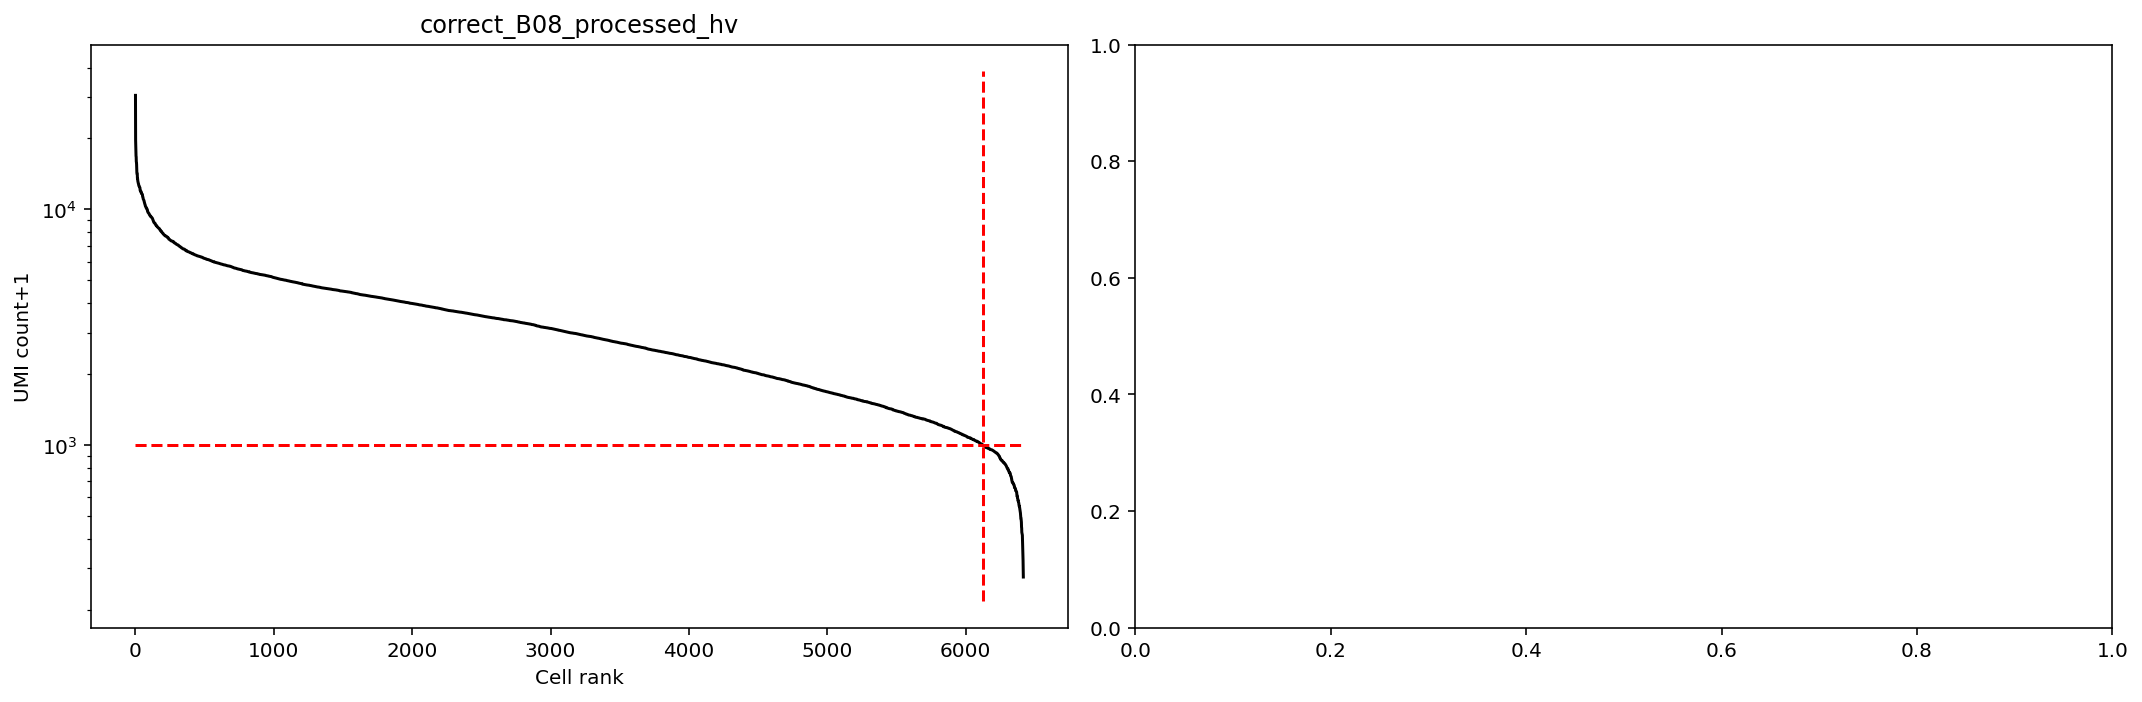

In [87]:
cf = []
thr_lb = [1e3]*len(dataset_meta)*2

fig1,ax1 = plt.subplots(1,len(dataset_meta)*2,figsize=(15,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(subcluster_names)*k]
    dataset_name = raw_data_locations[len(subcluster_names)*k]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1[k],viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = meta['cell_barcode'].sum()
        annot_bcs_in_loom = meta['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        
        #if k==0:
        for subcluster in subcluster_names:
            annot_bcs = meta[(meta['cell_type'].isin(subcluster))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')



    ax1[k].set_title(dataset_name)
    
!mkdir ./figs    
fig_dir = './figs/'
fig_string = fig_dir + 'kneeplots_sizes_top_allenB08_forMM.png'
fig1.tight_layout()
plt.savefig(fig_string,dpi=450)

In [88]:
all_assigns = [list(meta['cell_type'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(all_assigns))

2420


In [89]:
assigns = [all_assigns]*num_ks 

In [90]:
sub_assigns = [list(meta['sub_label'][meta['cell_barcode'] == i])[0] for i in bcs[cf[0]]]
print(len(sub_assigns))

2420


In [91]:
all_sub_assigns = [sub_assigns]*num_ks 

## **Gene Filtering**

In [92]:
import logging, sys
logging.basicConfig(stream=sys.stdout)
log = logging.getLogger()
log.setLevel(logging.INFO)

In [23]:
!mkdir ./fits

INFO:root:Beginning data preprocessing and filtering.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2420 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:547 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2420 cells detected.
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:547 genes retained after expression filter.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5 already exists.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2420 cells detecte

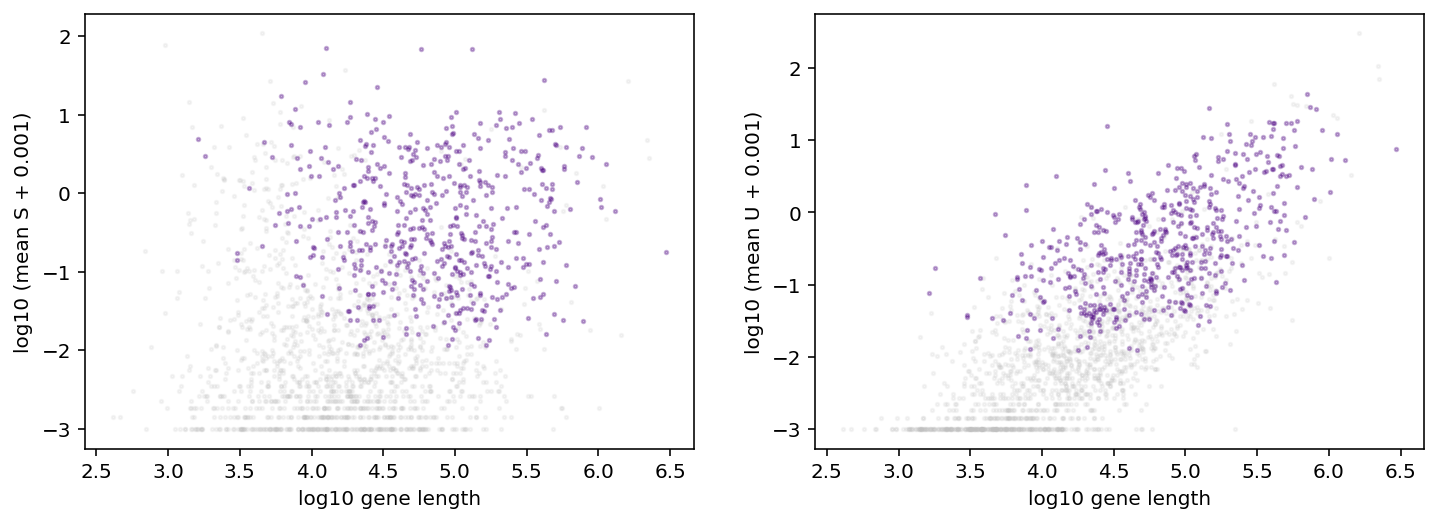

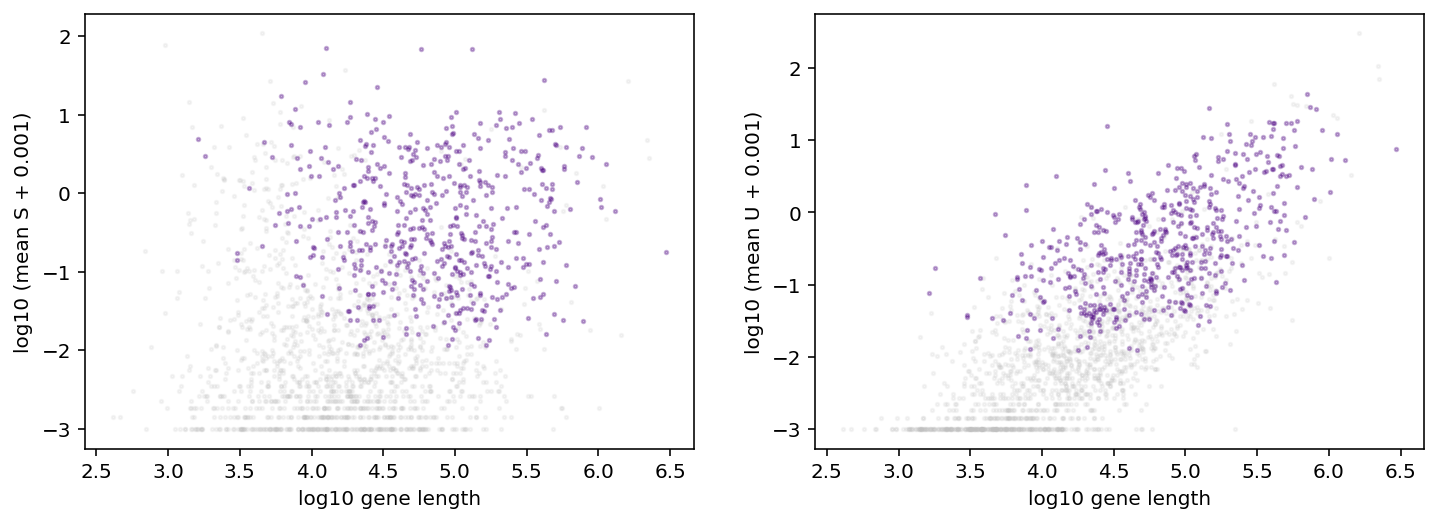

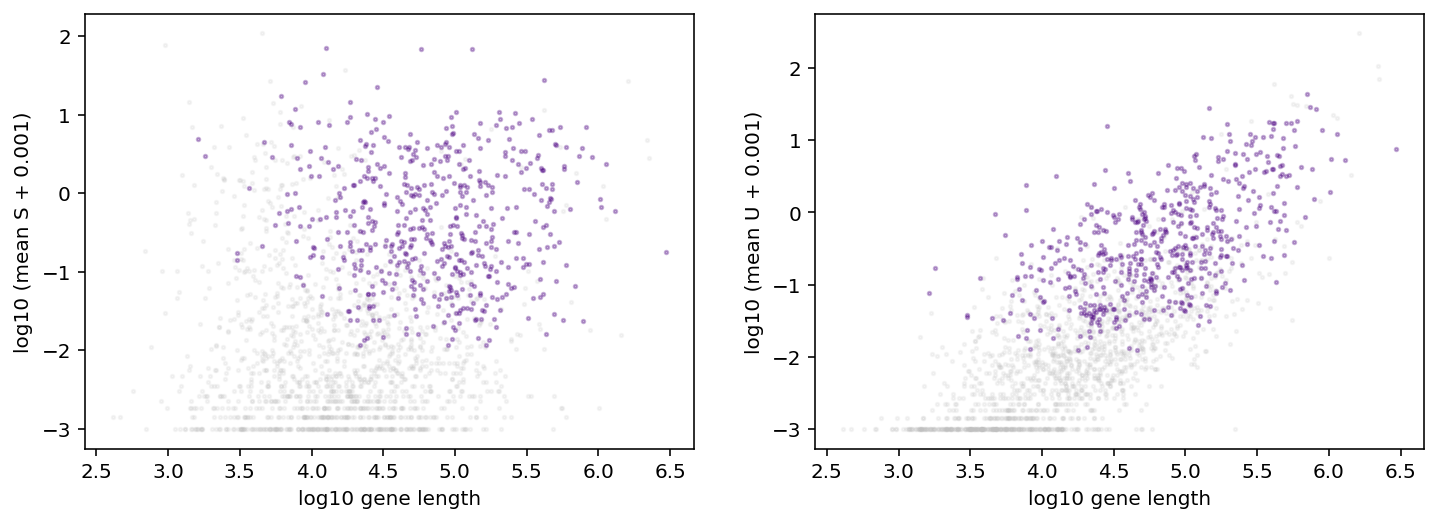

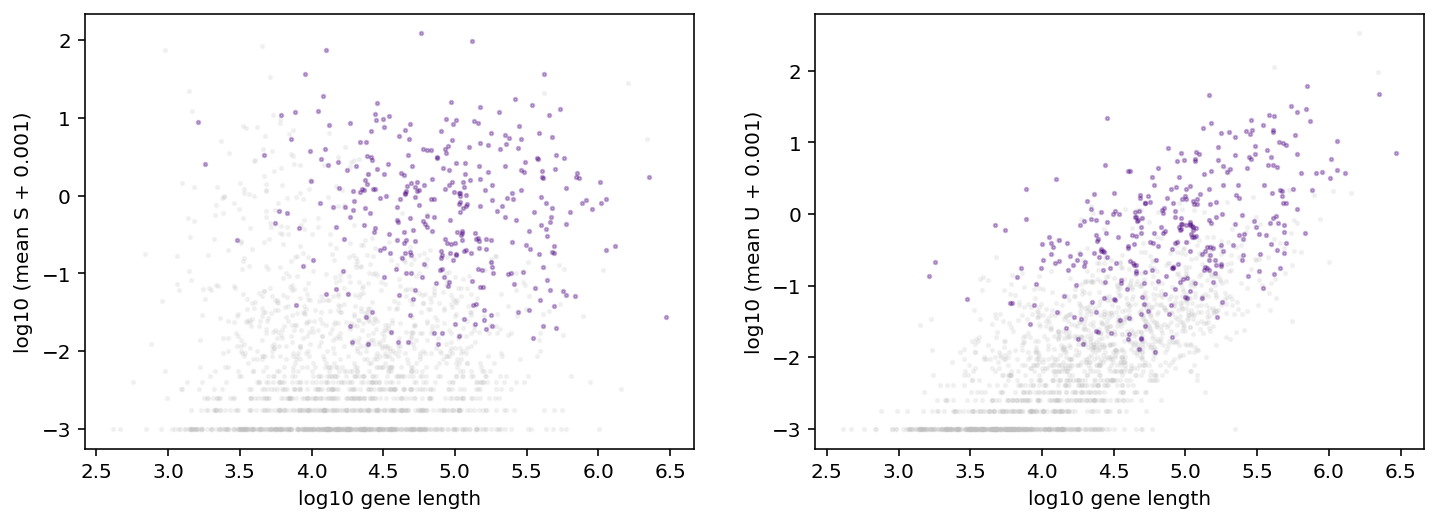

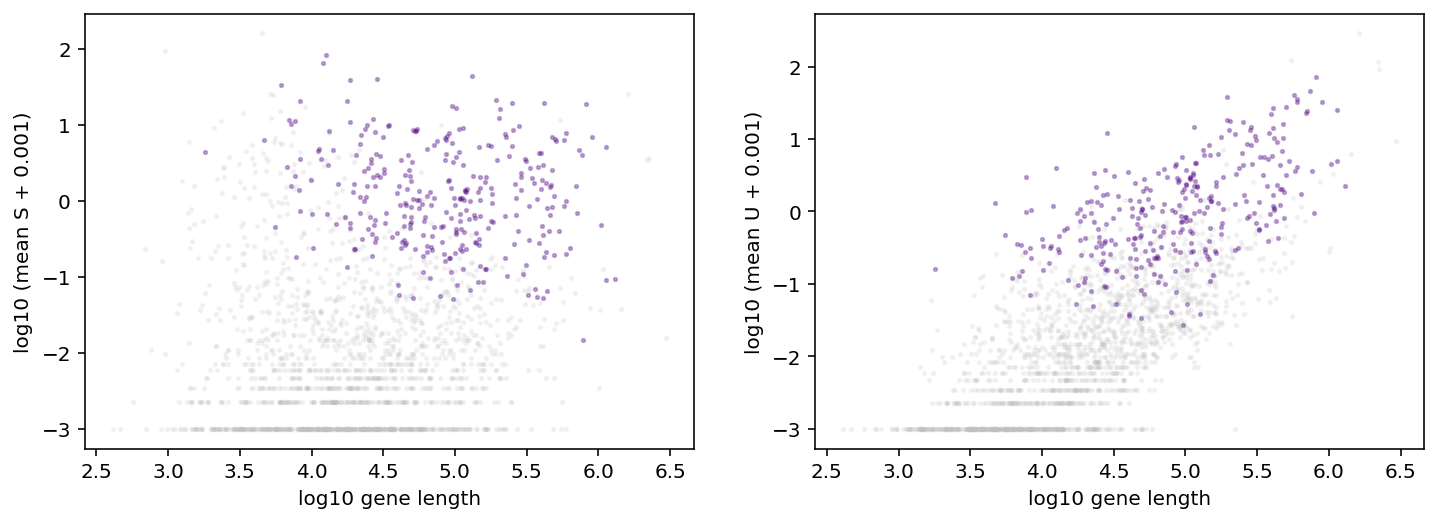

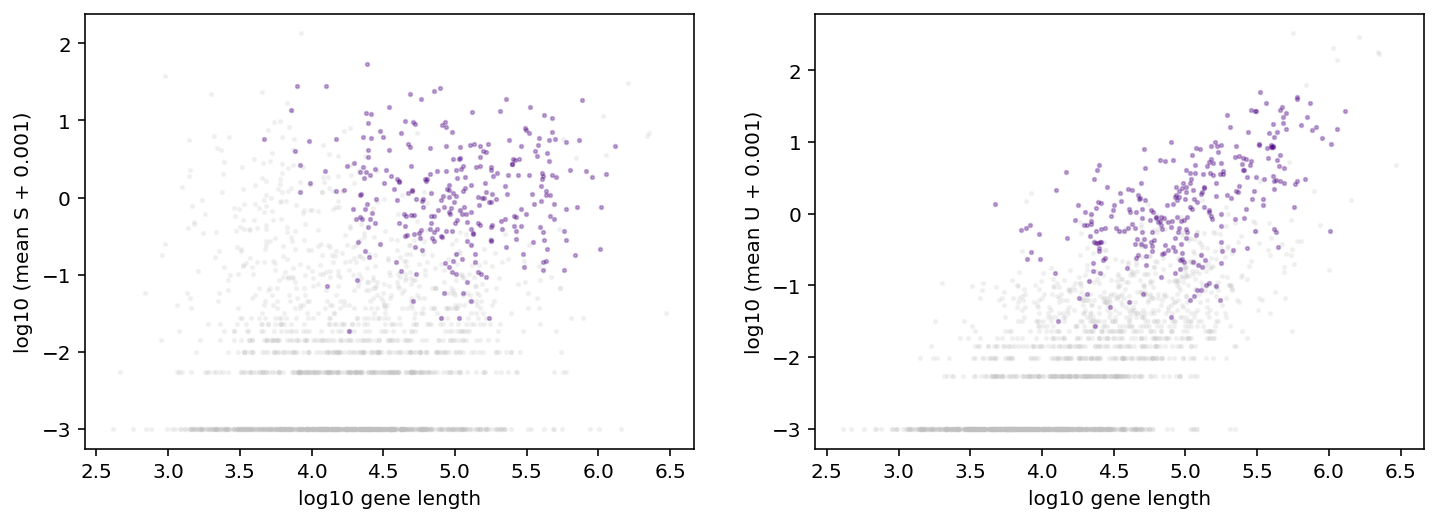

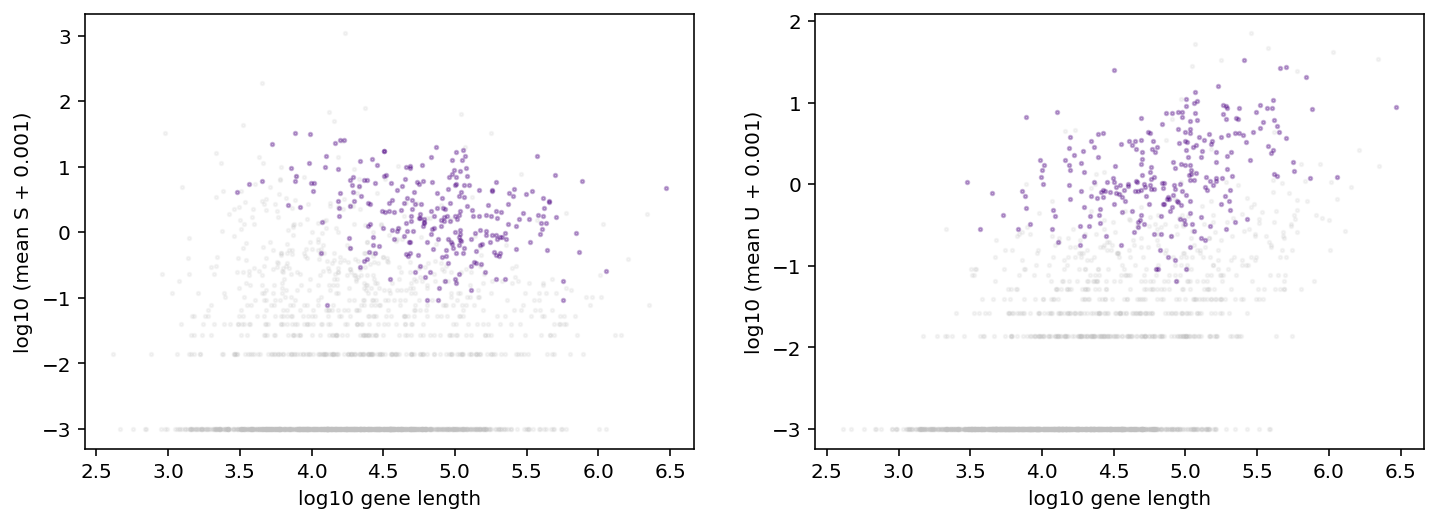

In [120]:
dir_string,dataset_strings = monod.preprocess.construct_batch(loom_filepaths, \
                                             transcriptome_filepath, \
                                             dataset_names, \
                                             attribute_names=attribute_names,\
                                             batch_location='./fits',meta='allen_B08_sizes_MM',batch_id=1,\
                                             datestring='230503', n_genes=1000,\
                                             exp_filter_threshold=None,cf=cf)  #1000

In [121]:
dir_string = './fits/gg_230503_025_allen_B08_sizes_MM_1'
dataset_strings = [ dir_string+'/'+item for item in dataset_names]
print(dataset_strings)

['./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip', './fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo']


Check k-means inits

In [122]:
all_groups_kmeans = []

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
(2420, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
(2420, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root

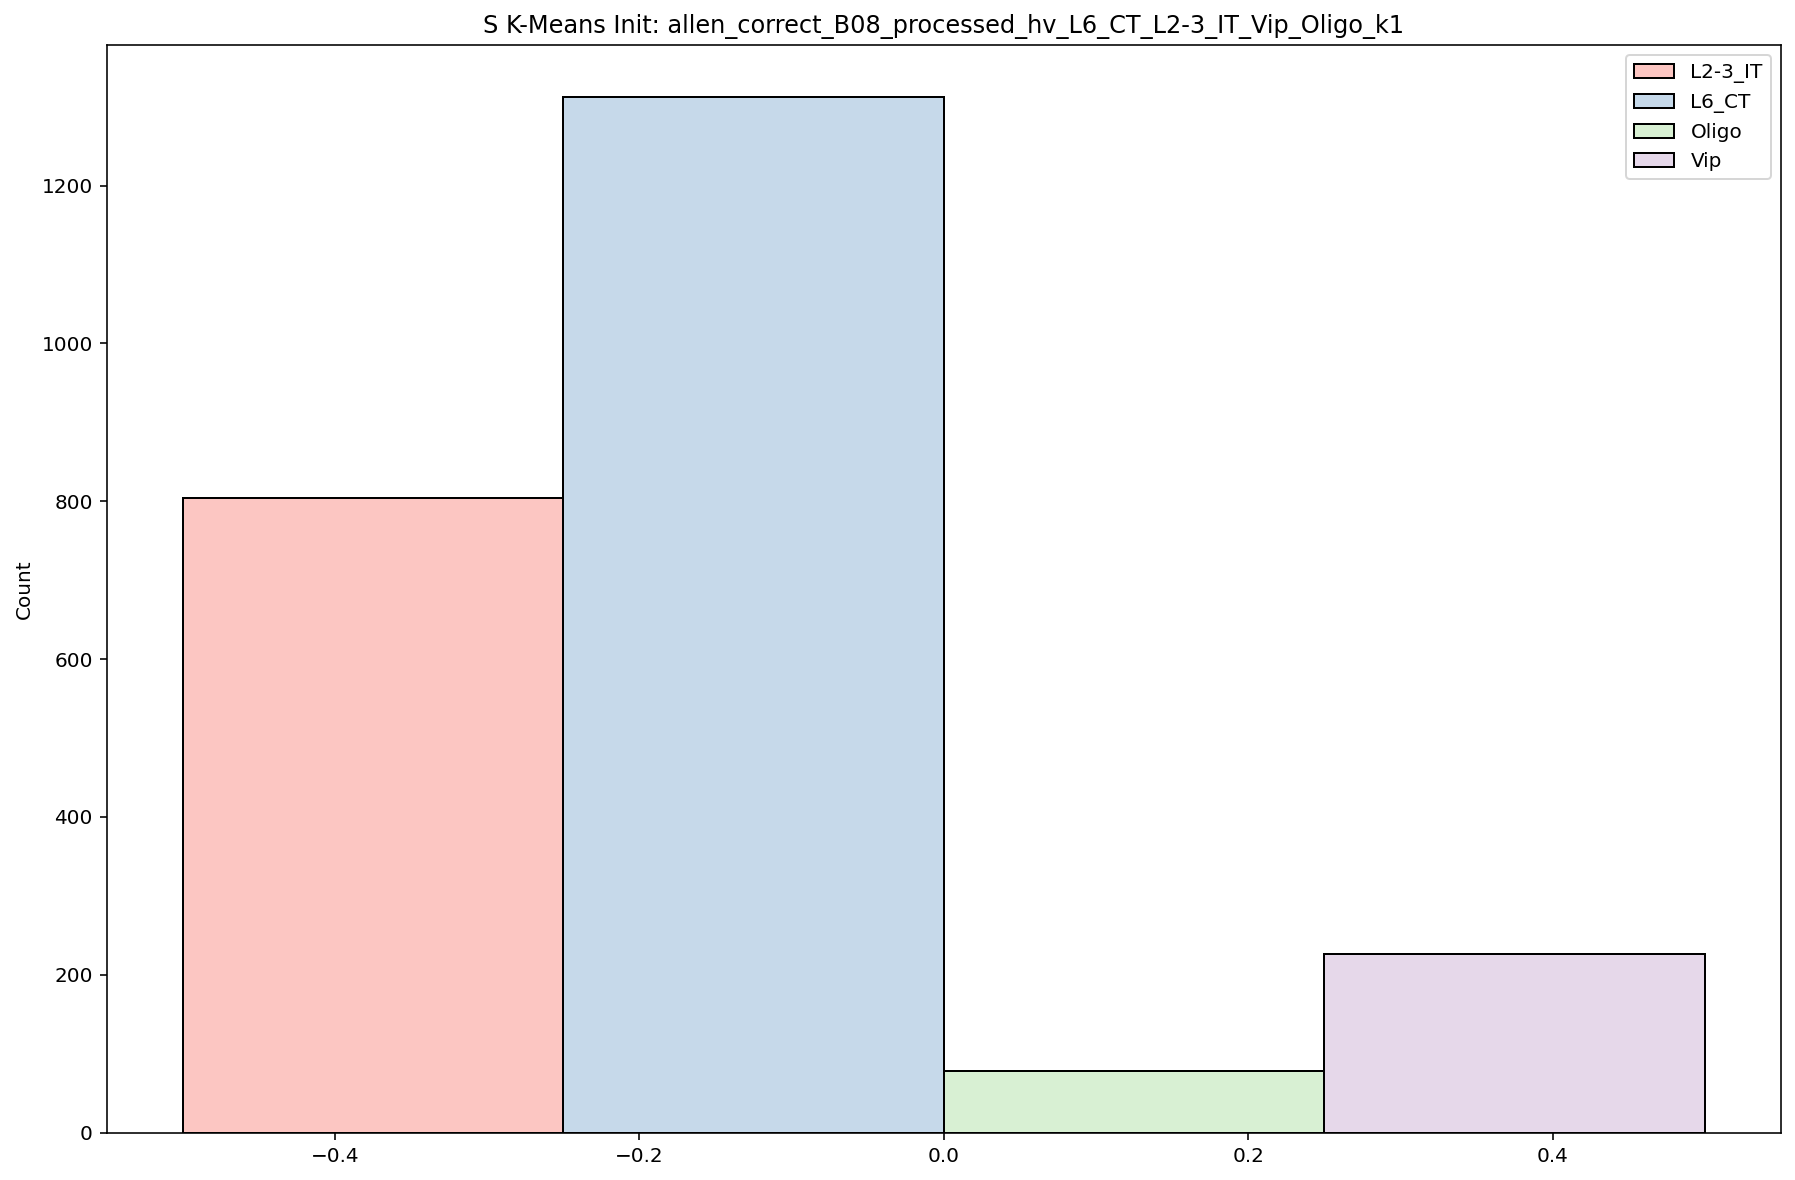

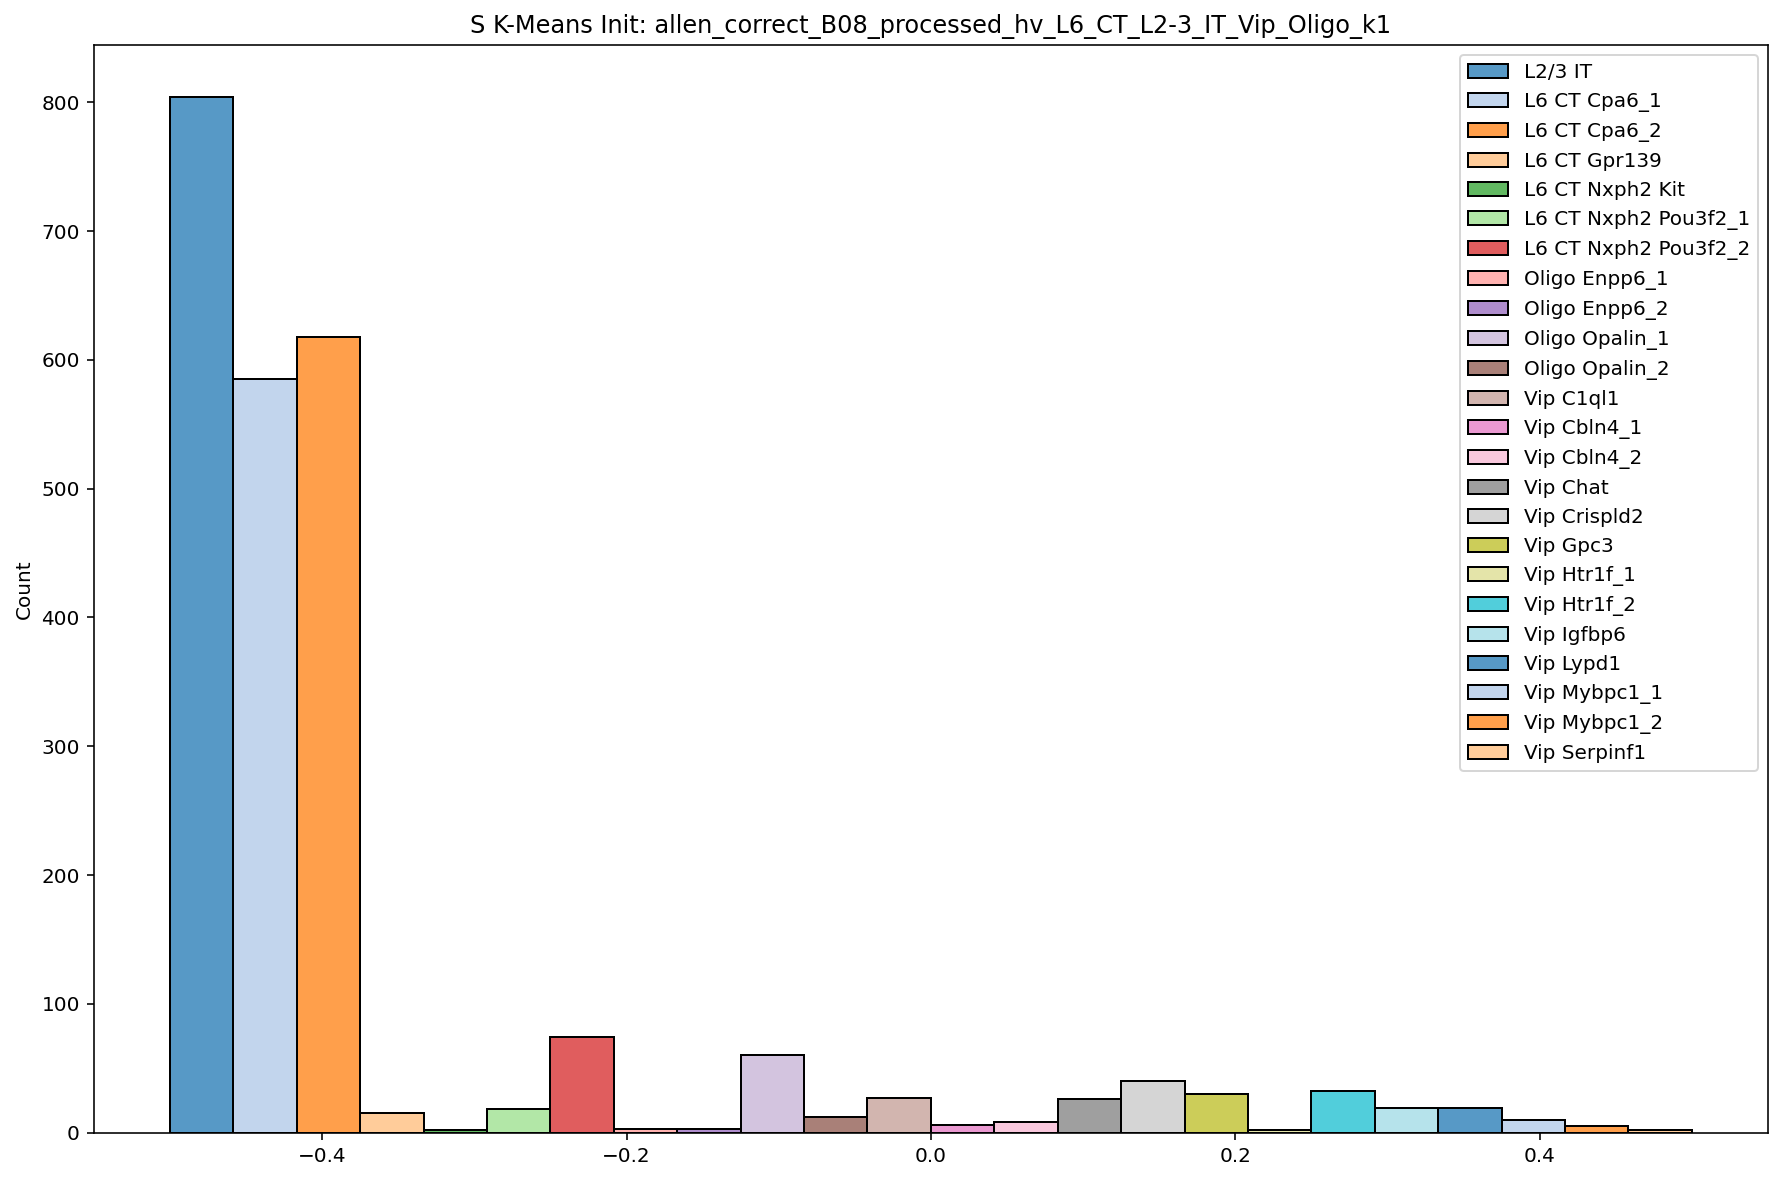

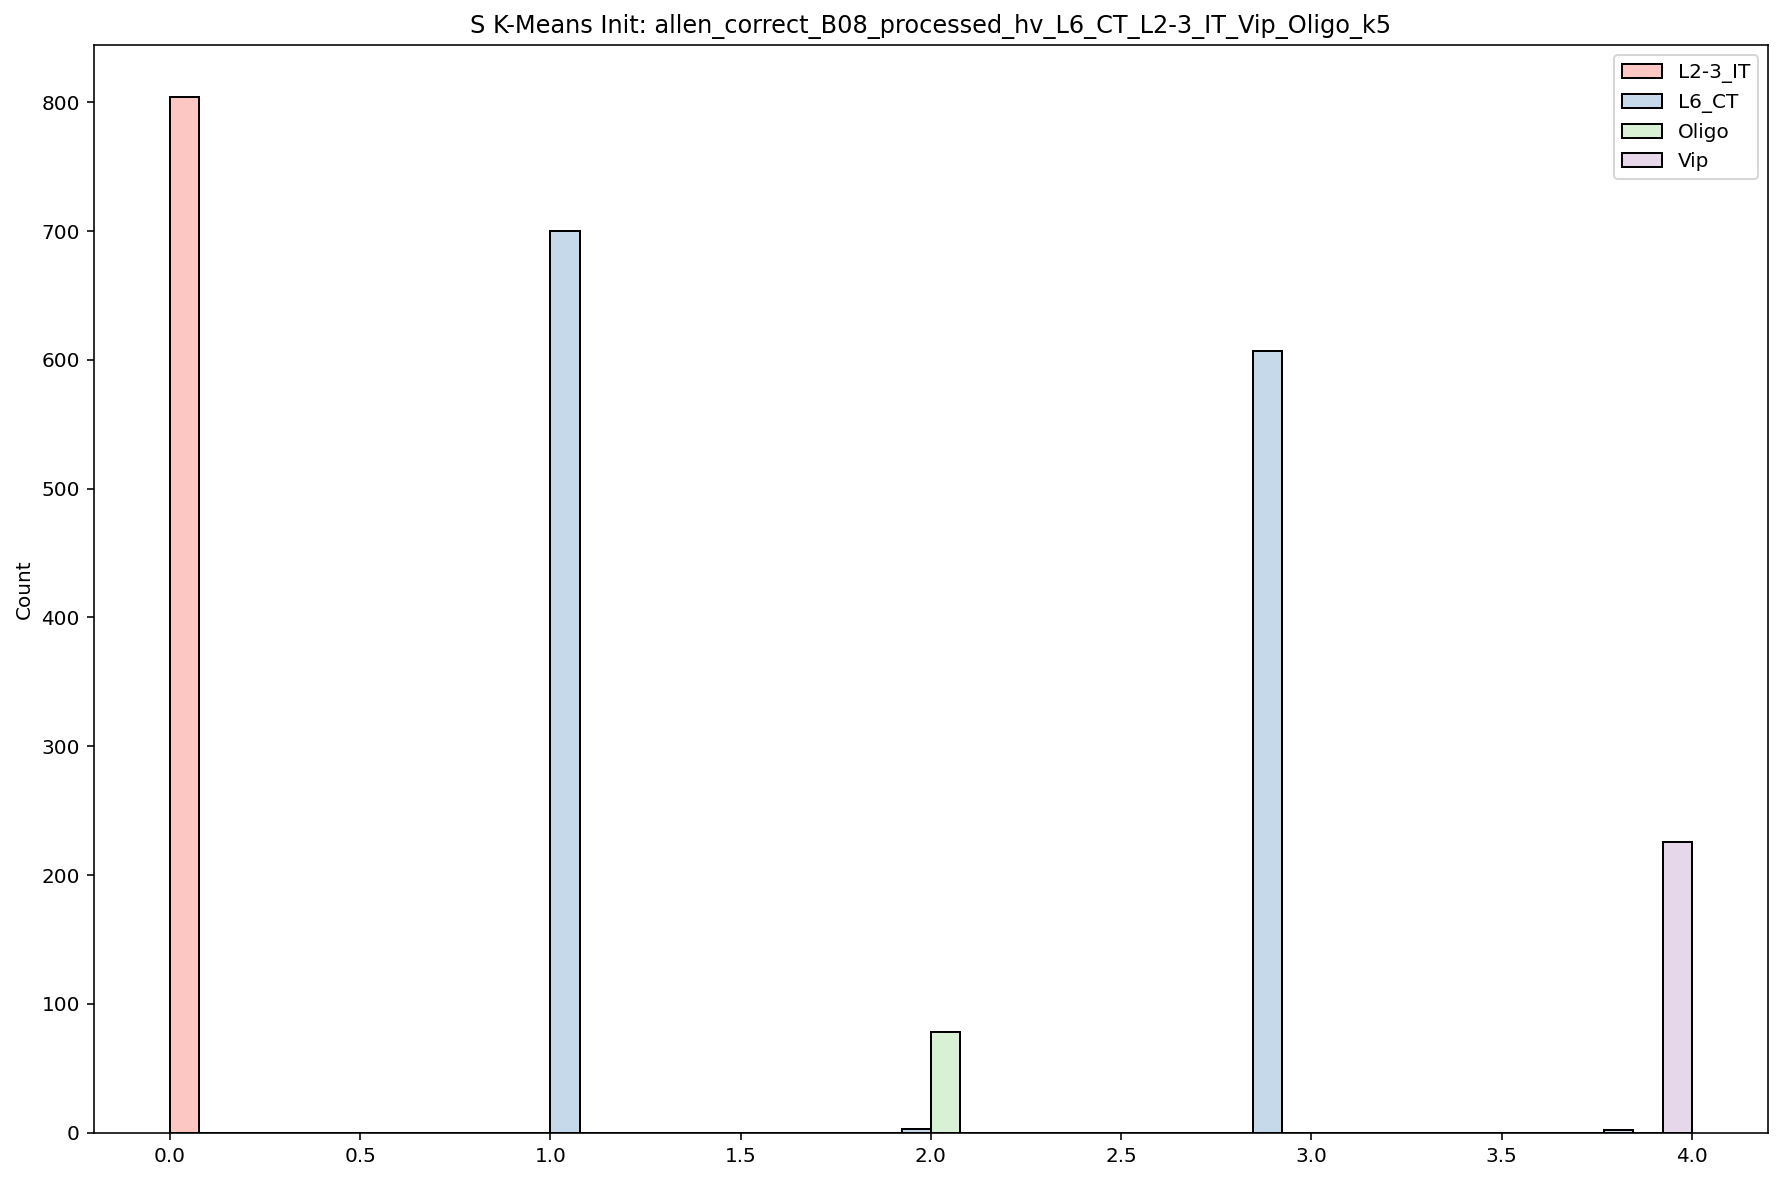

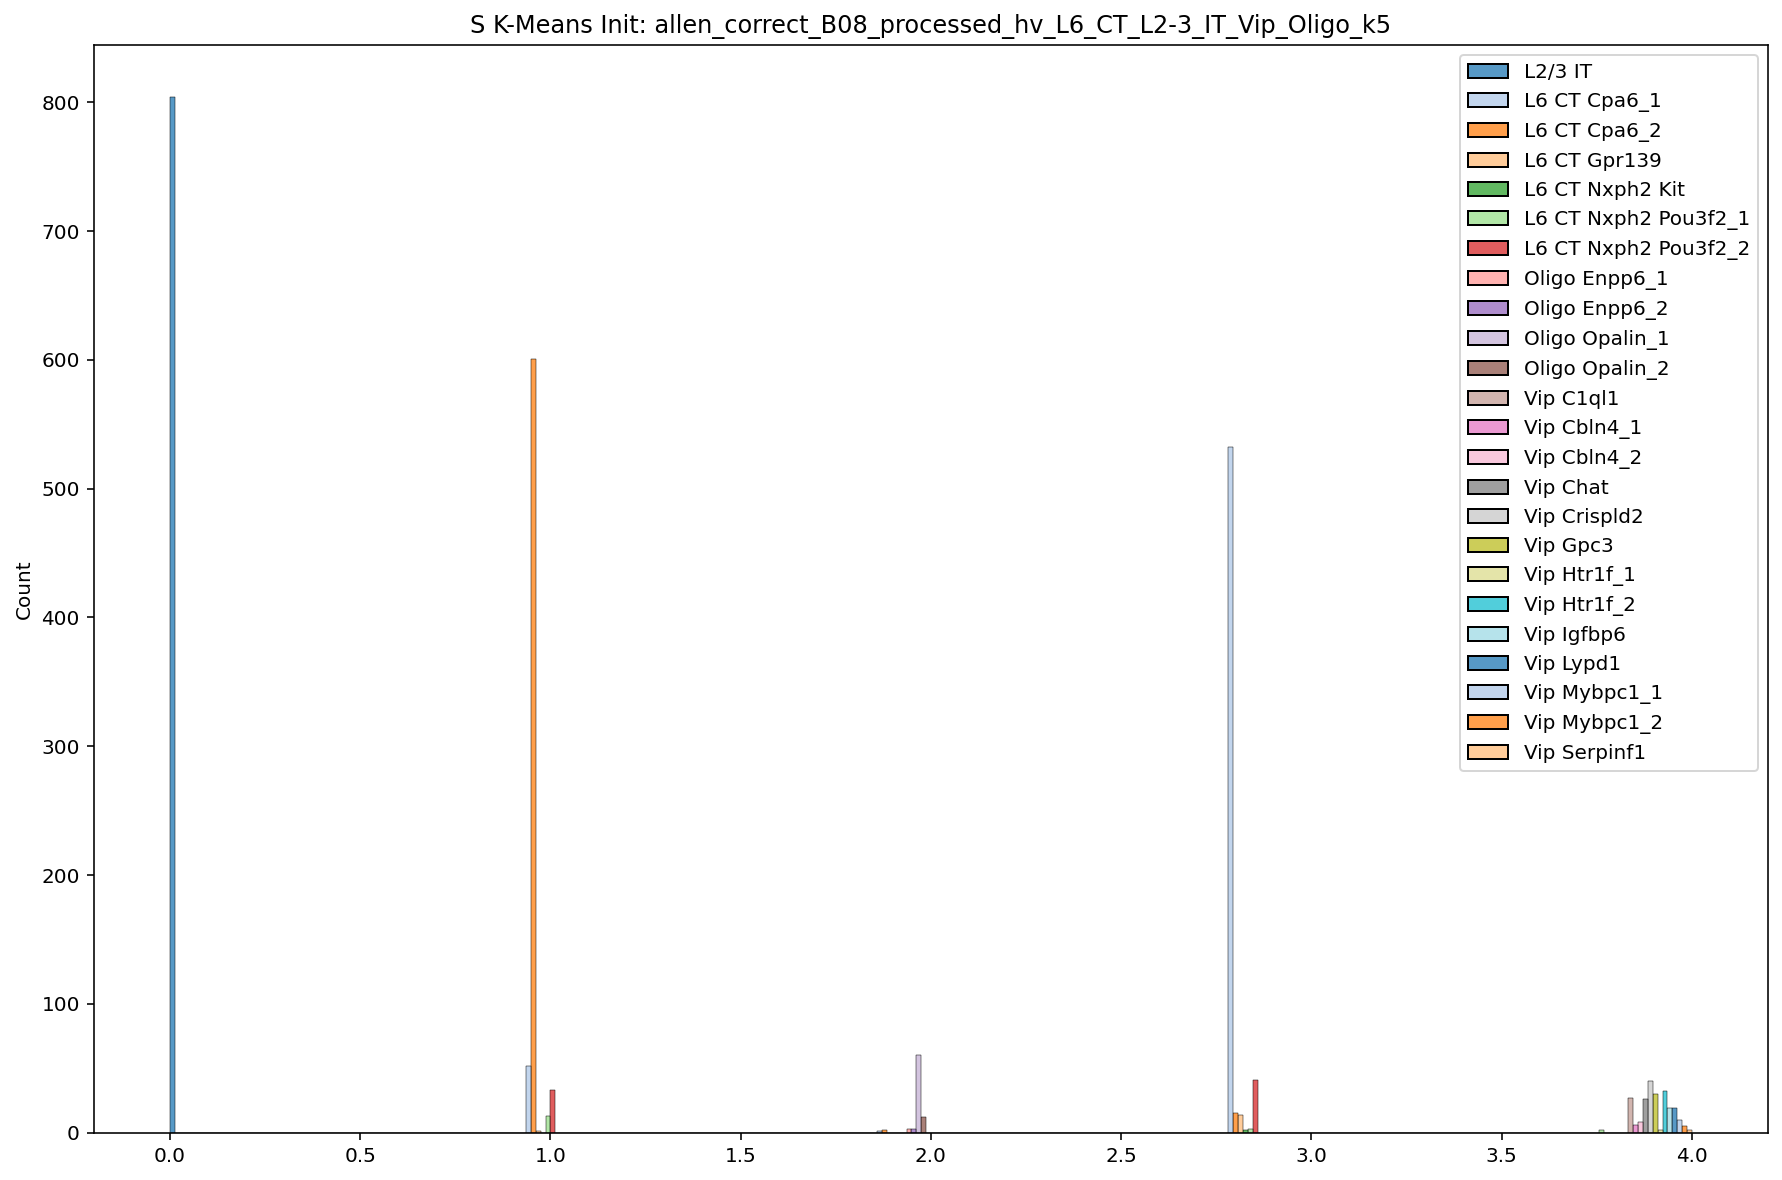

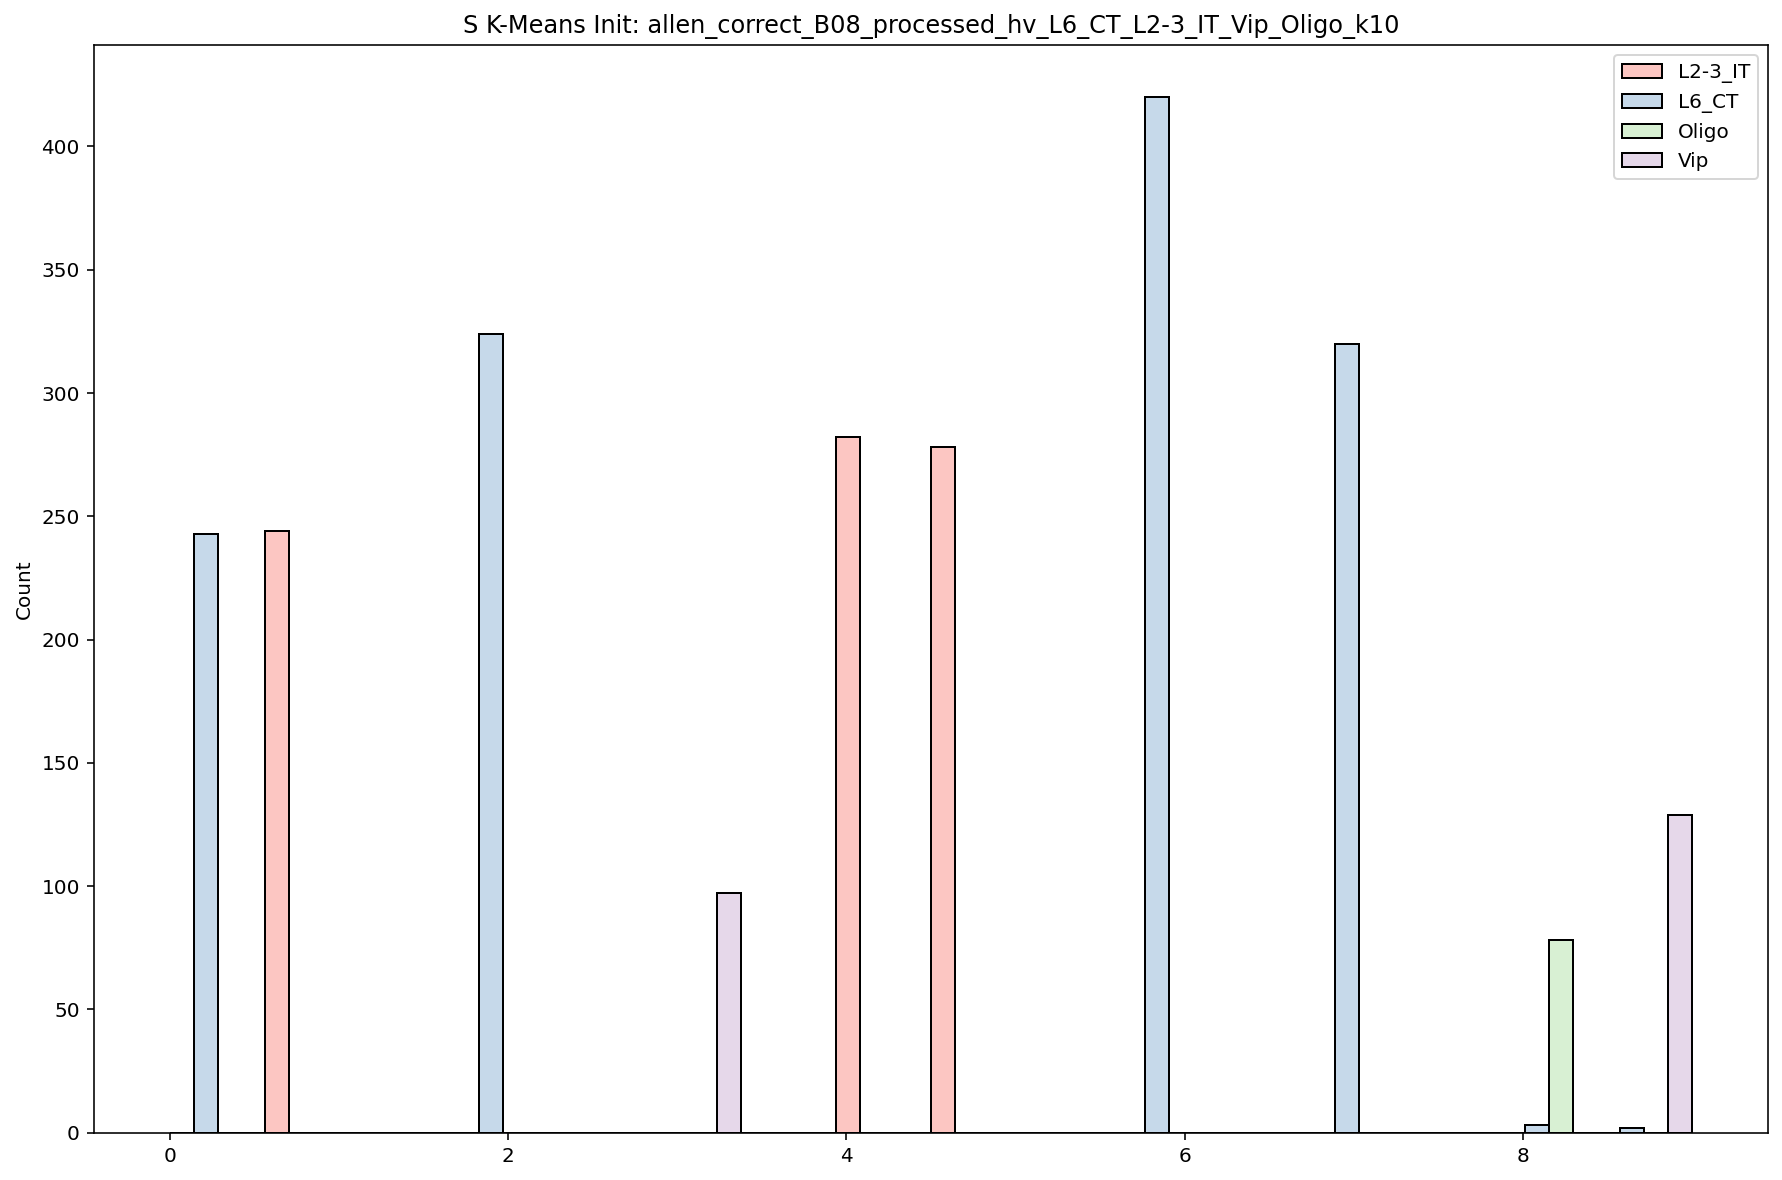

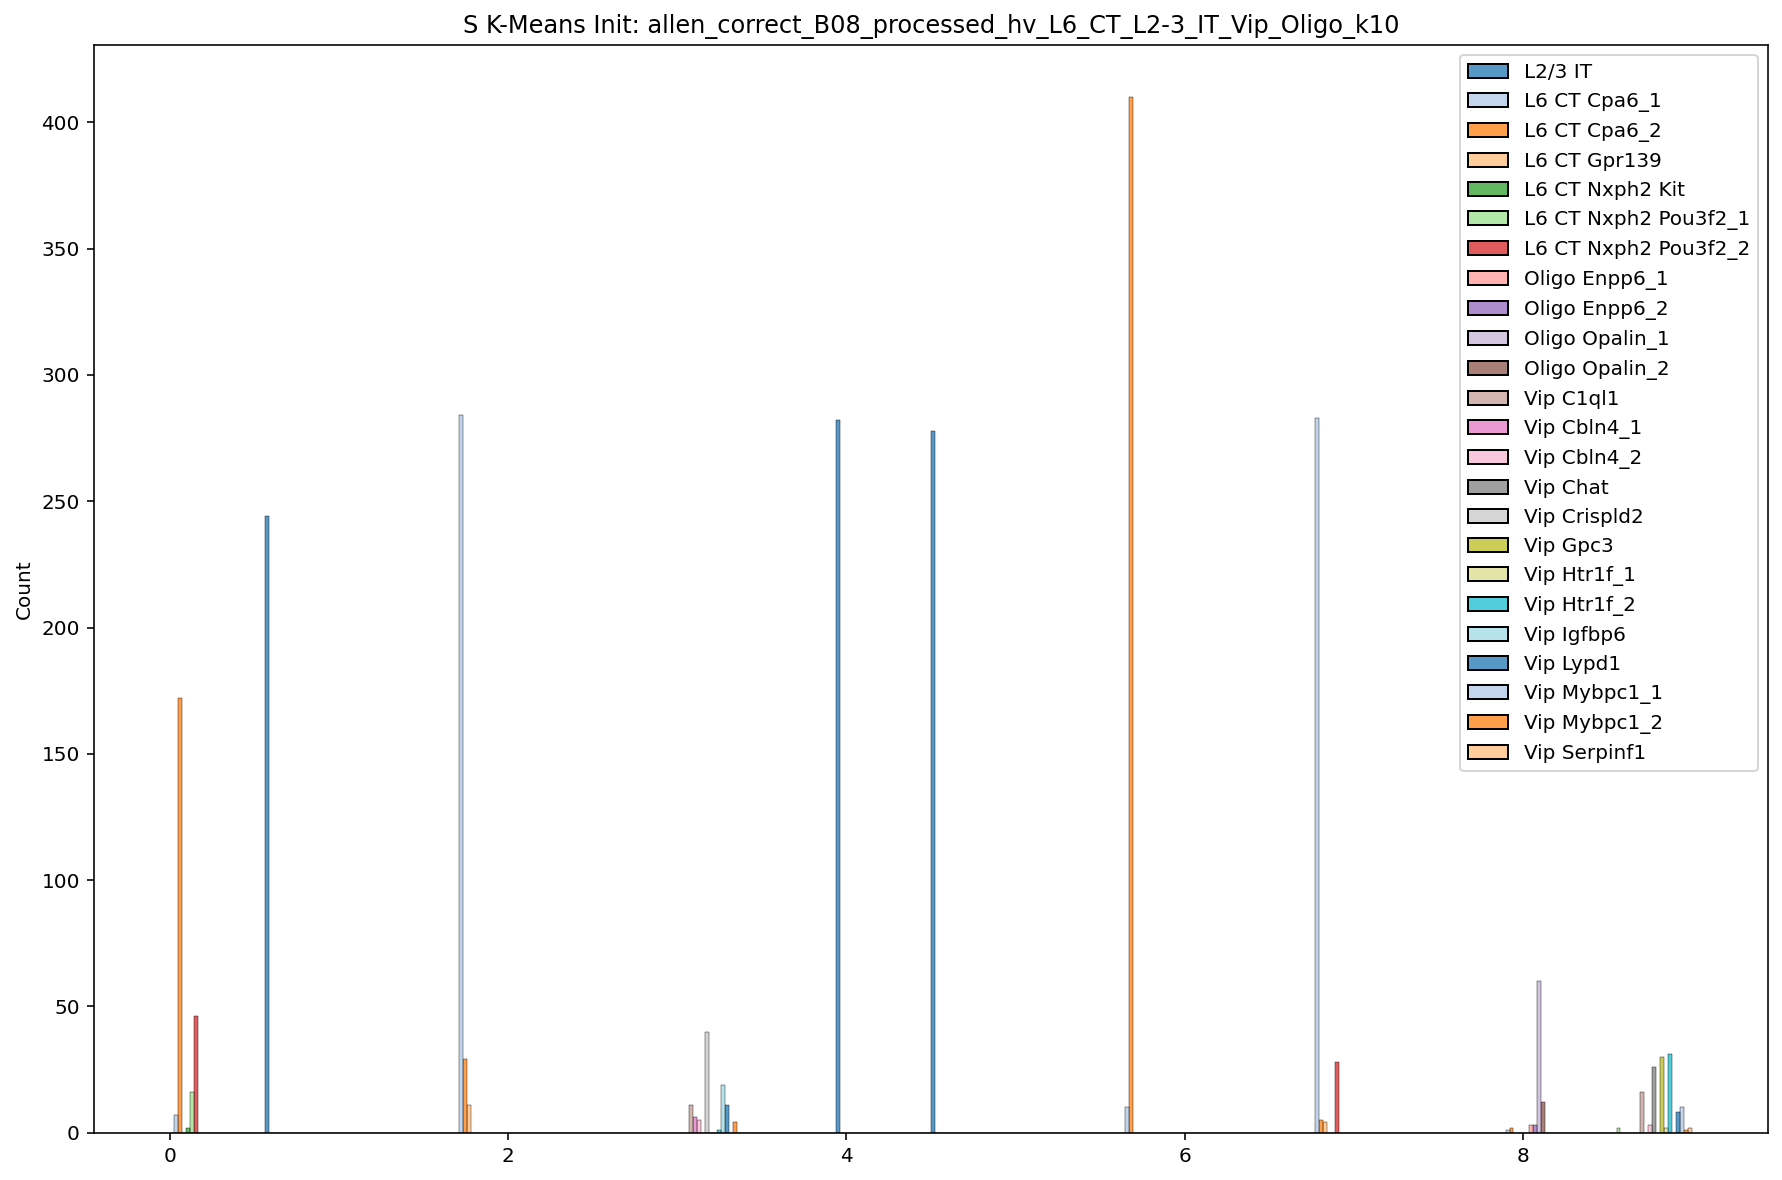

In [123]:
#For easier demonstration
#Check initializations of clusters
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('S K-Means Init: '+dataset_names[which])
    
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('S K-Means Init: '+dataset_names[which])
    
    




INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
(2420, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
(2420, 1000)
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root

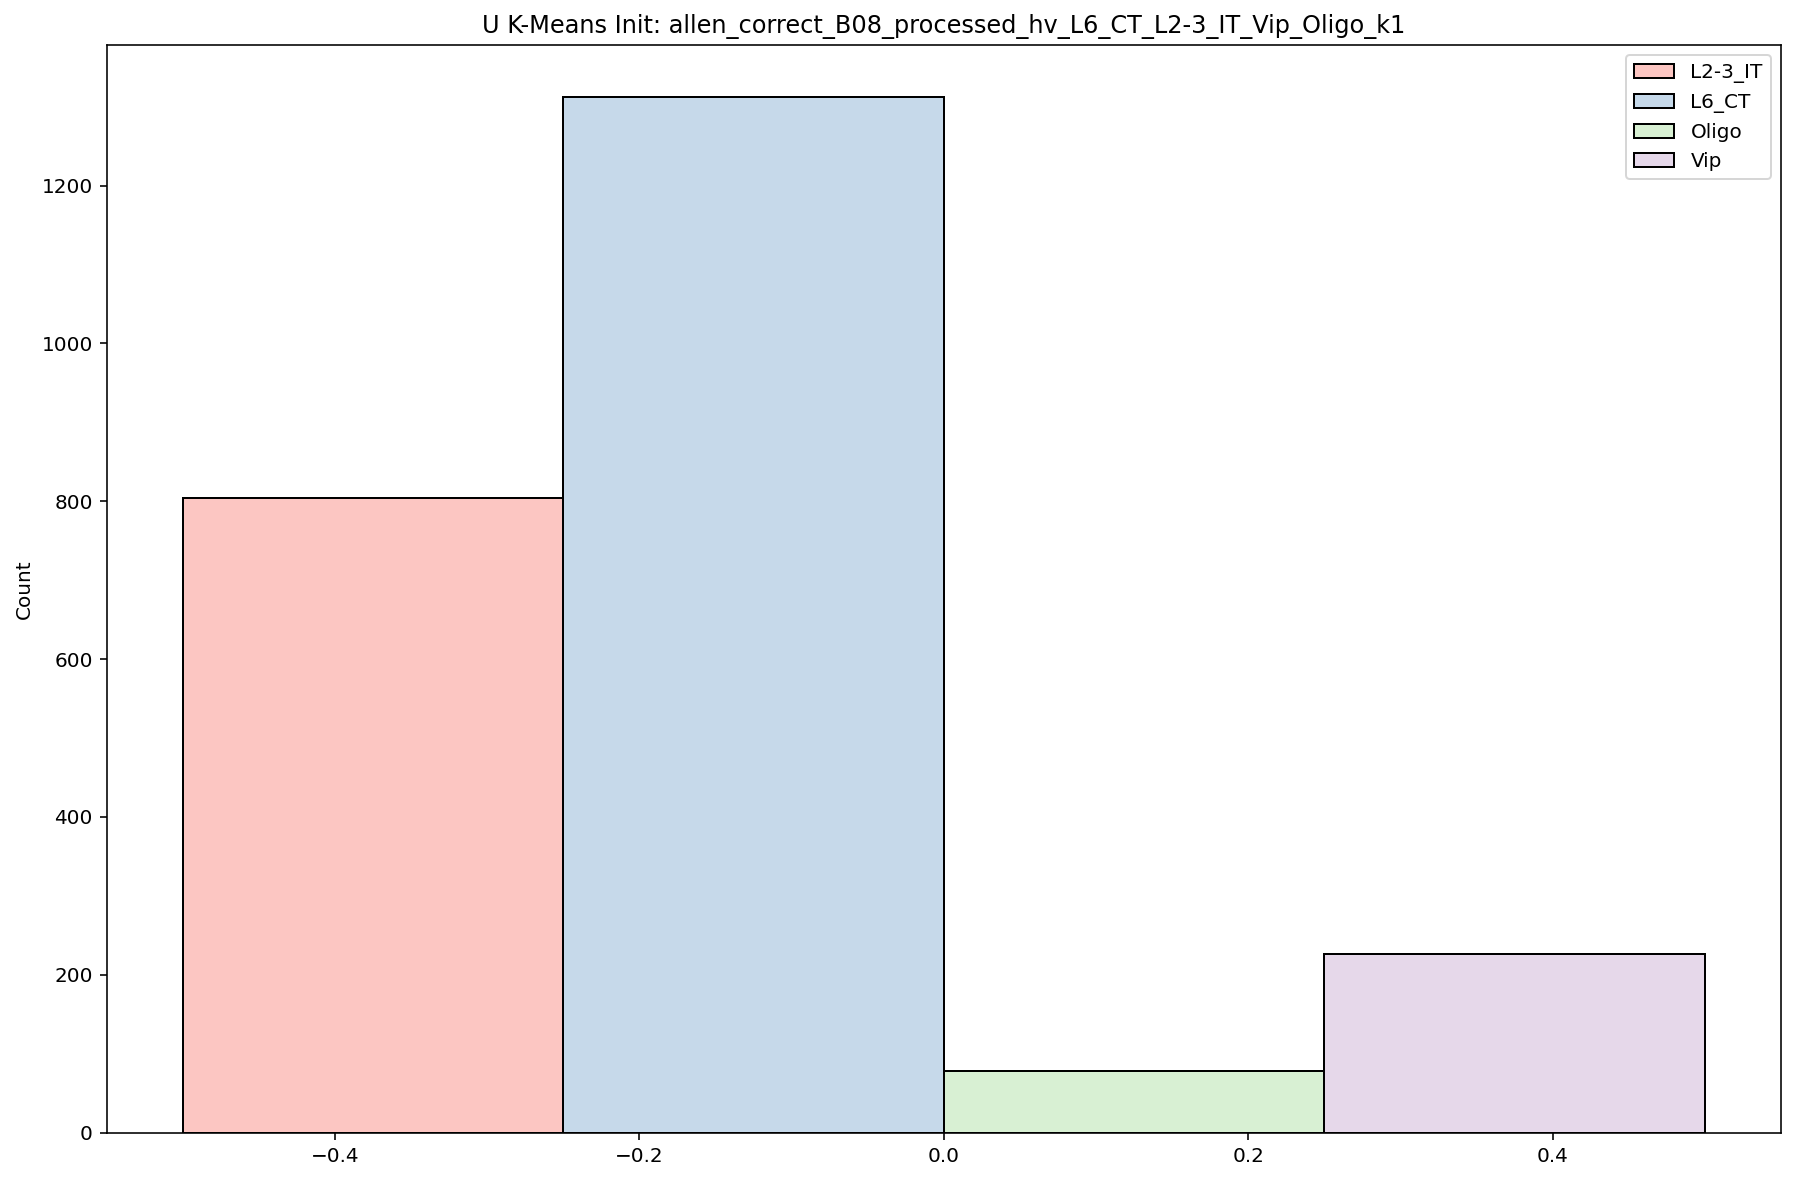

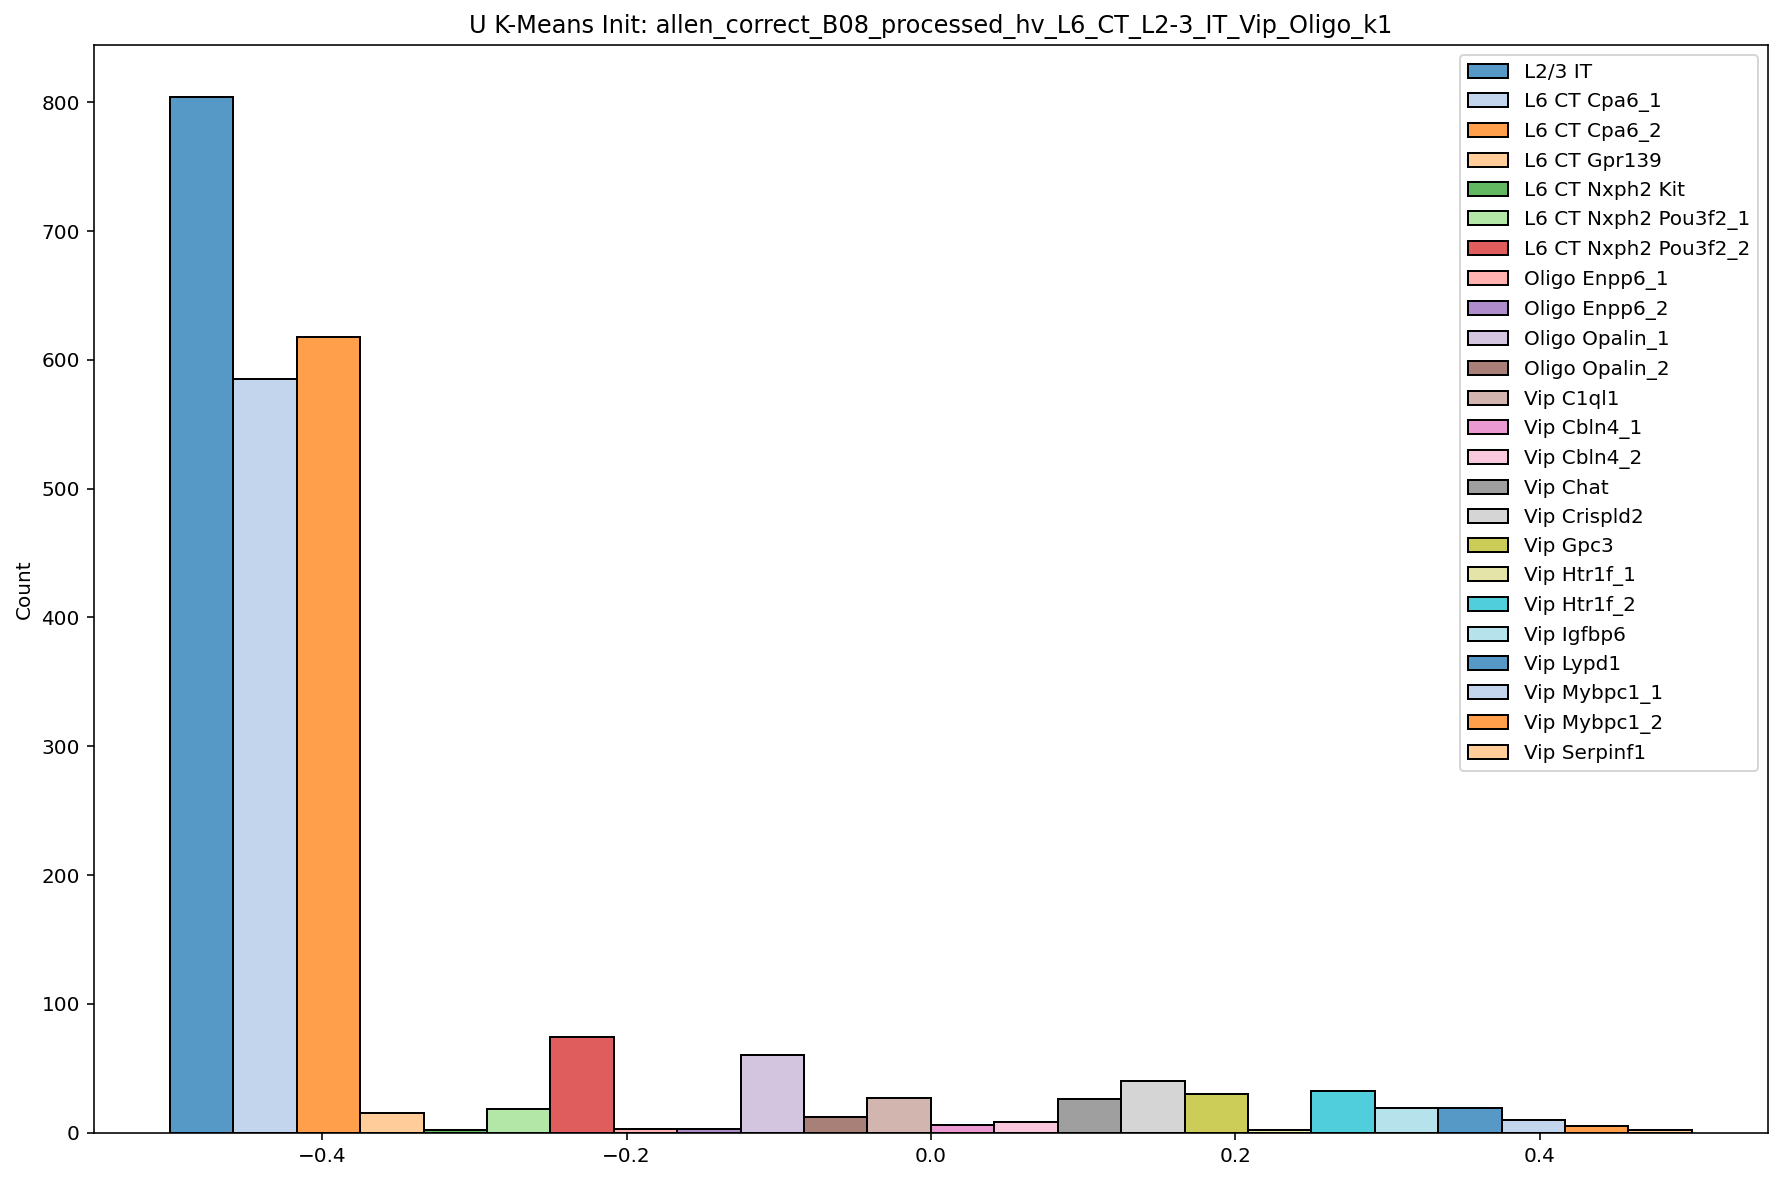

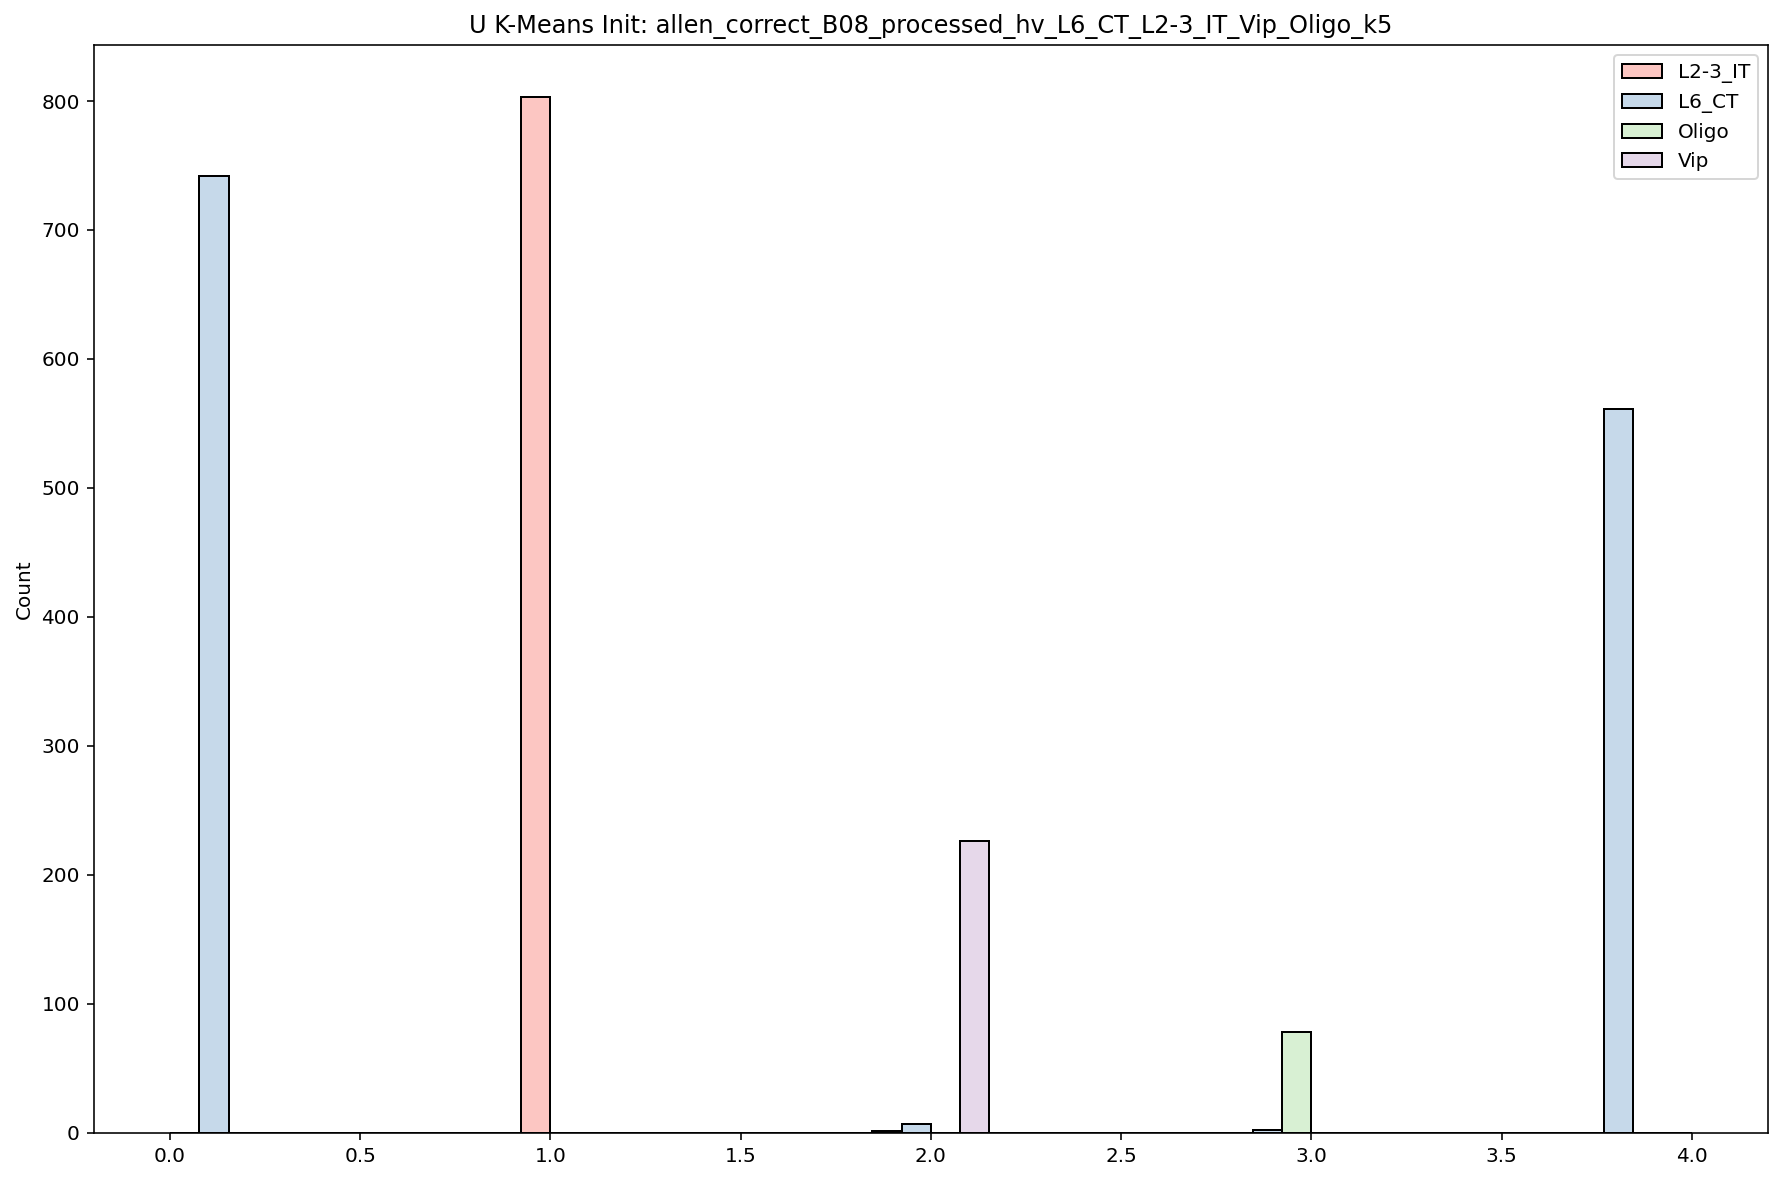

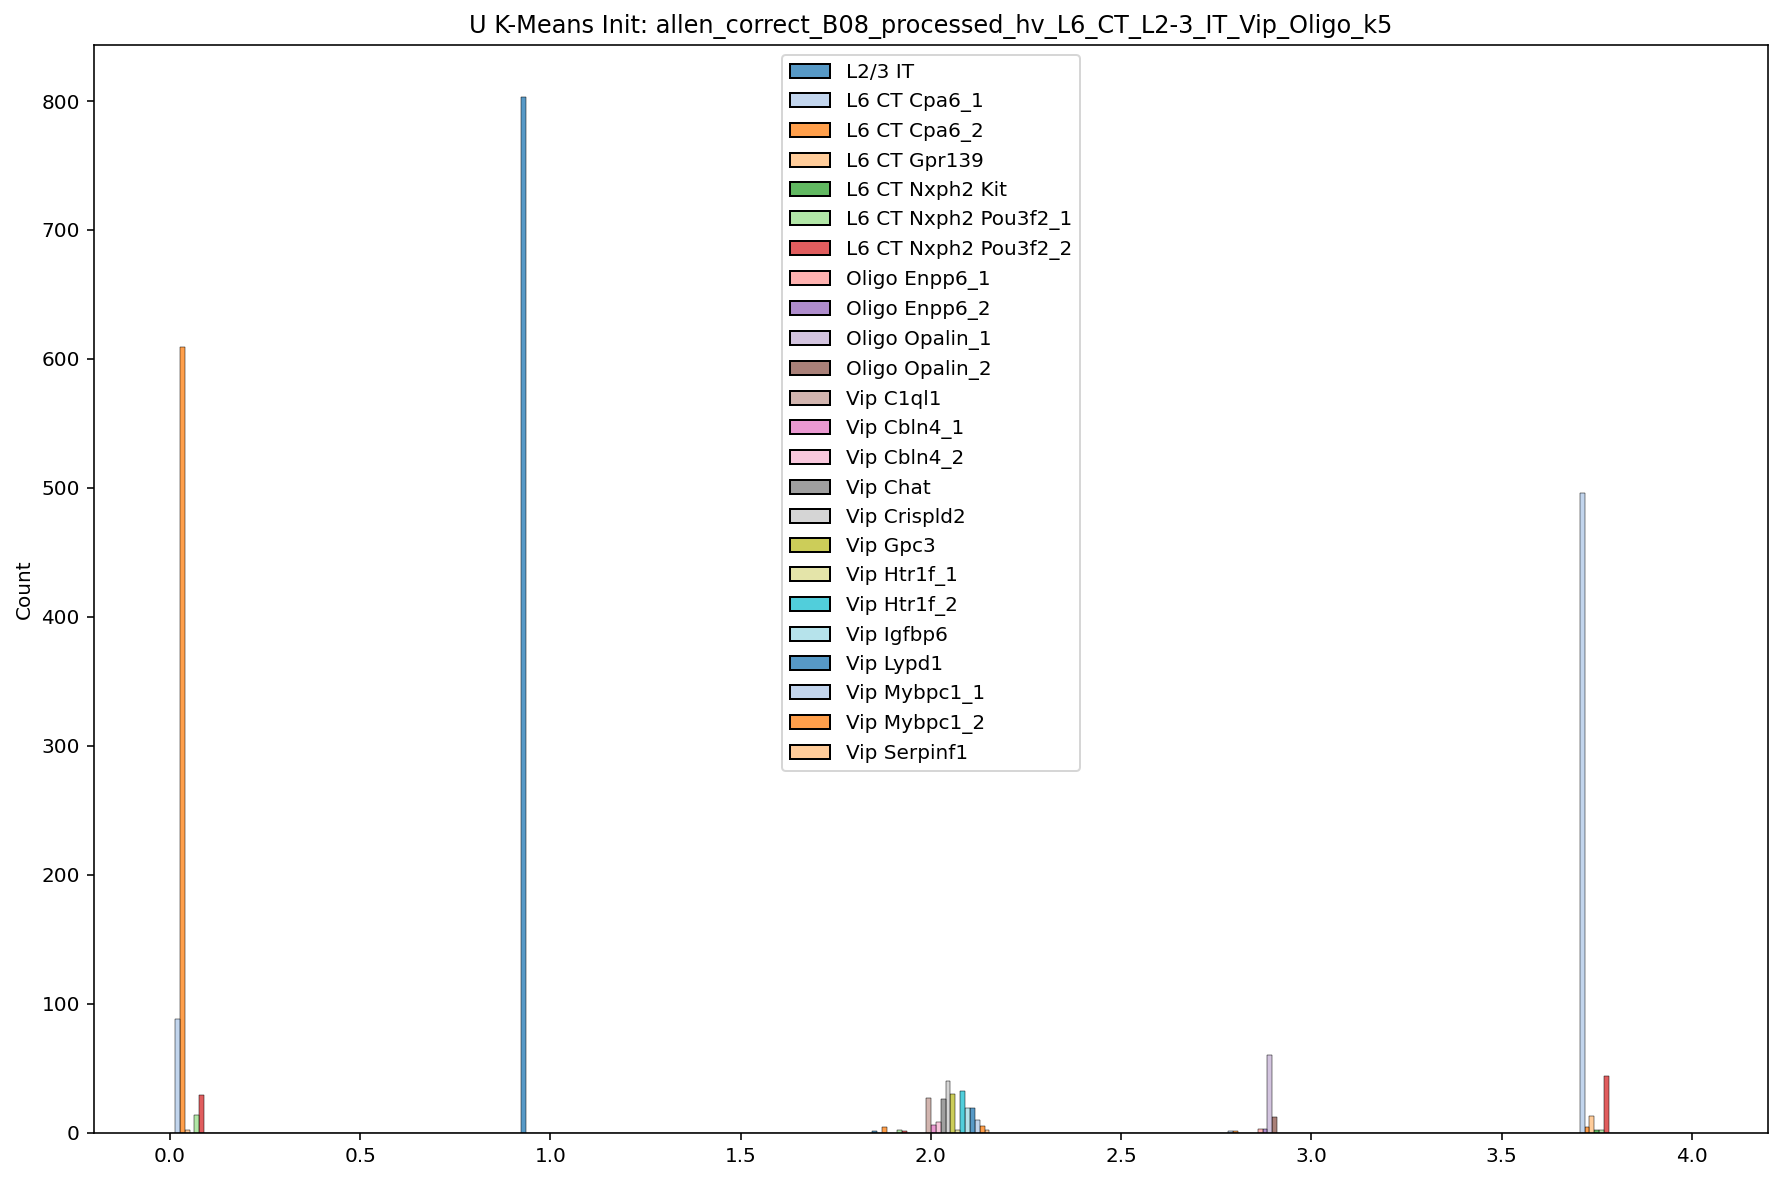

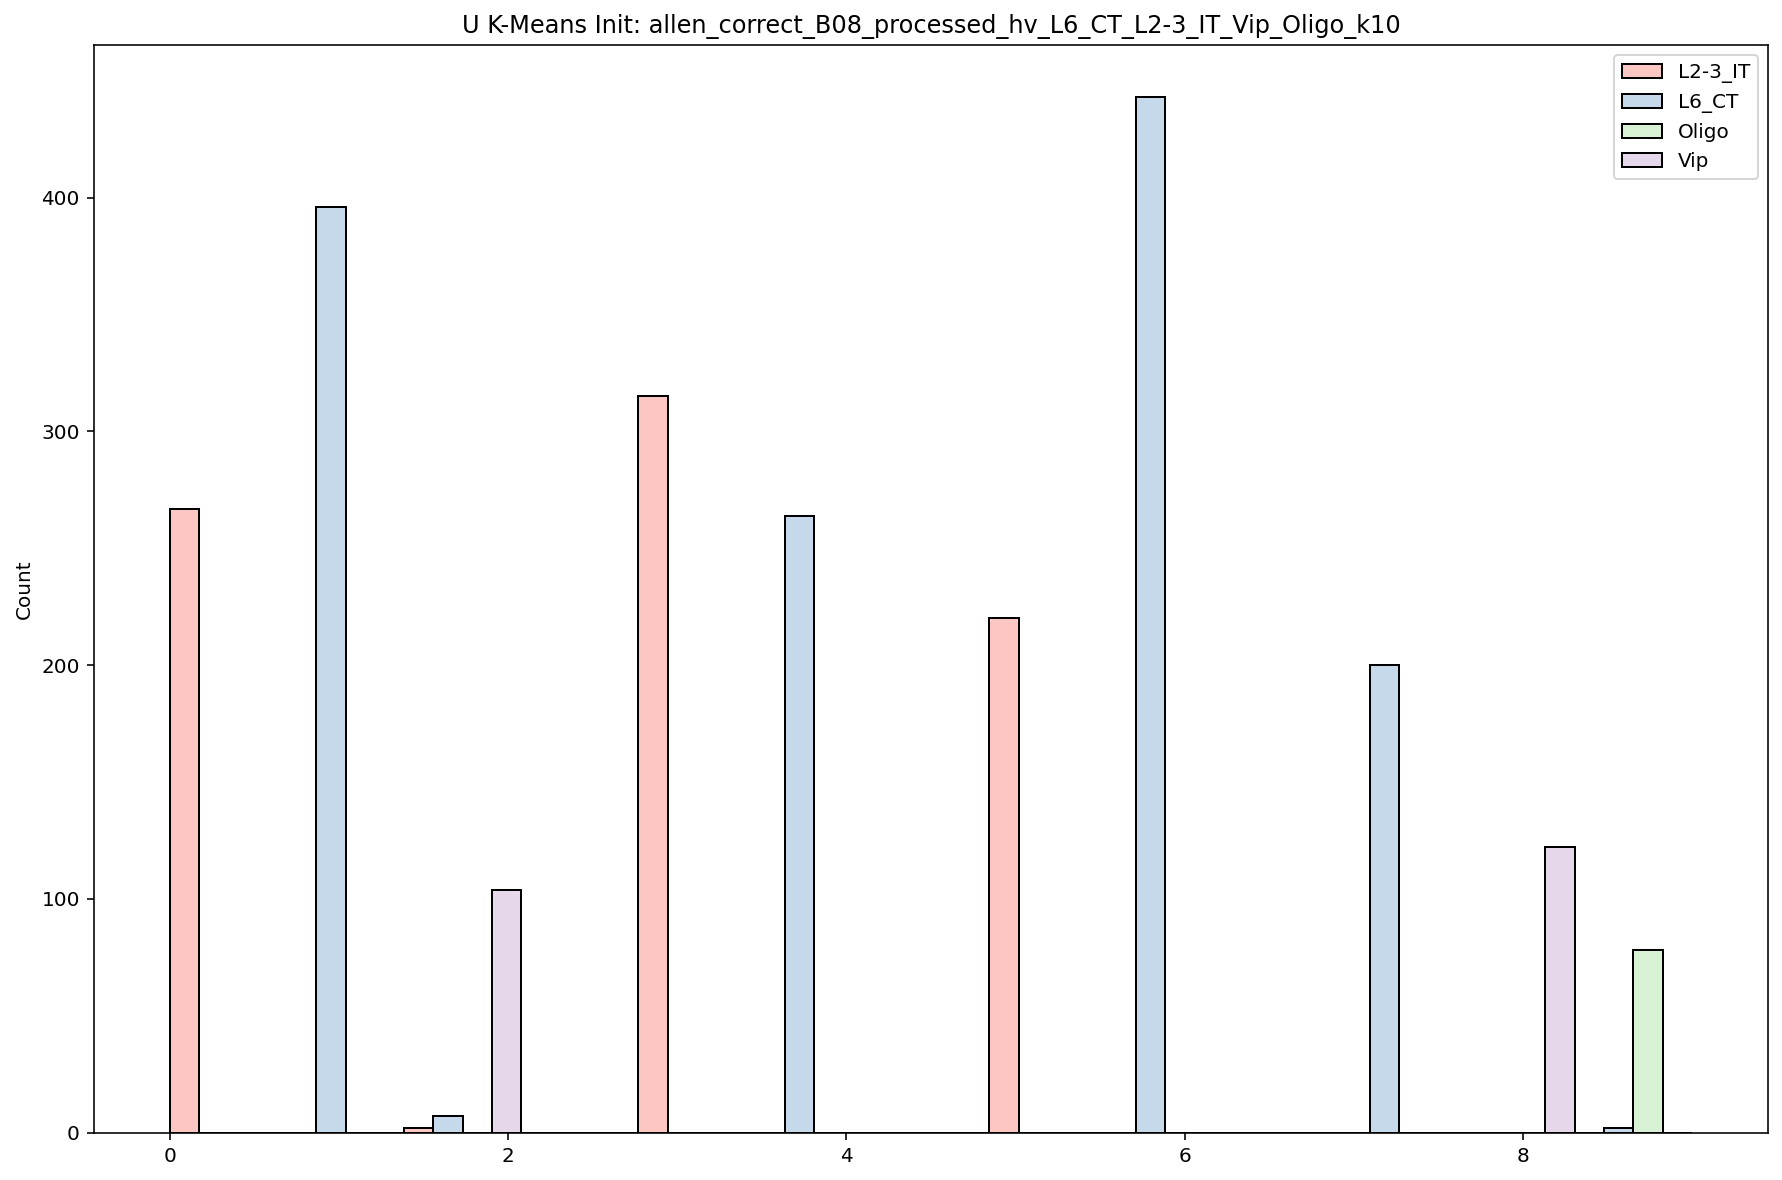

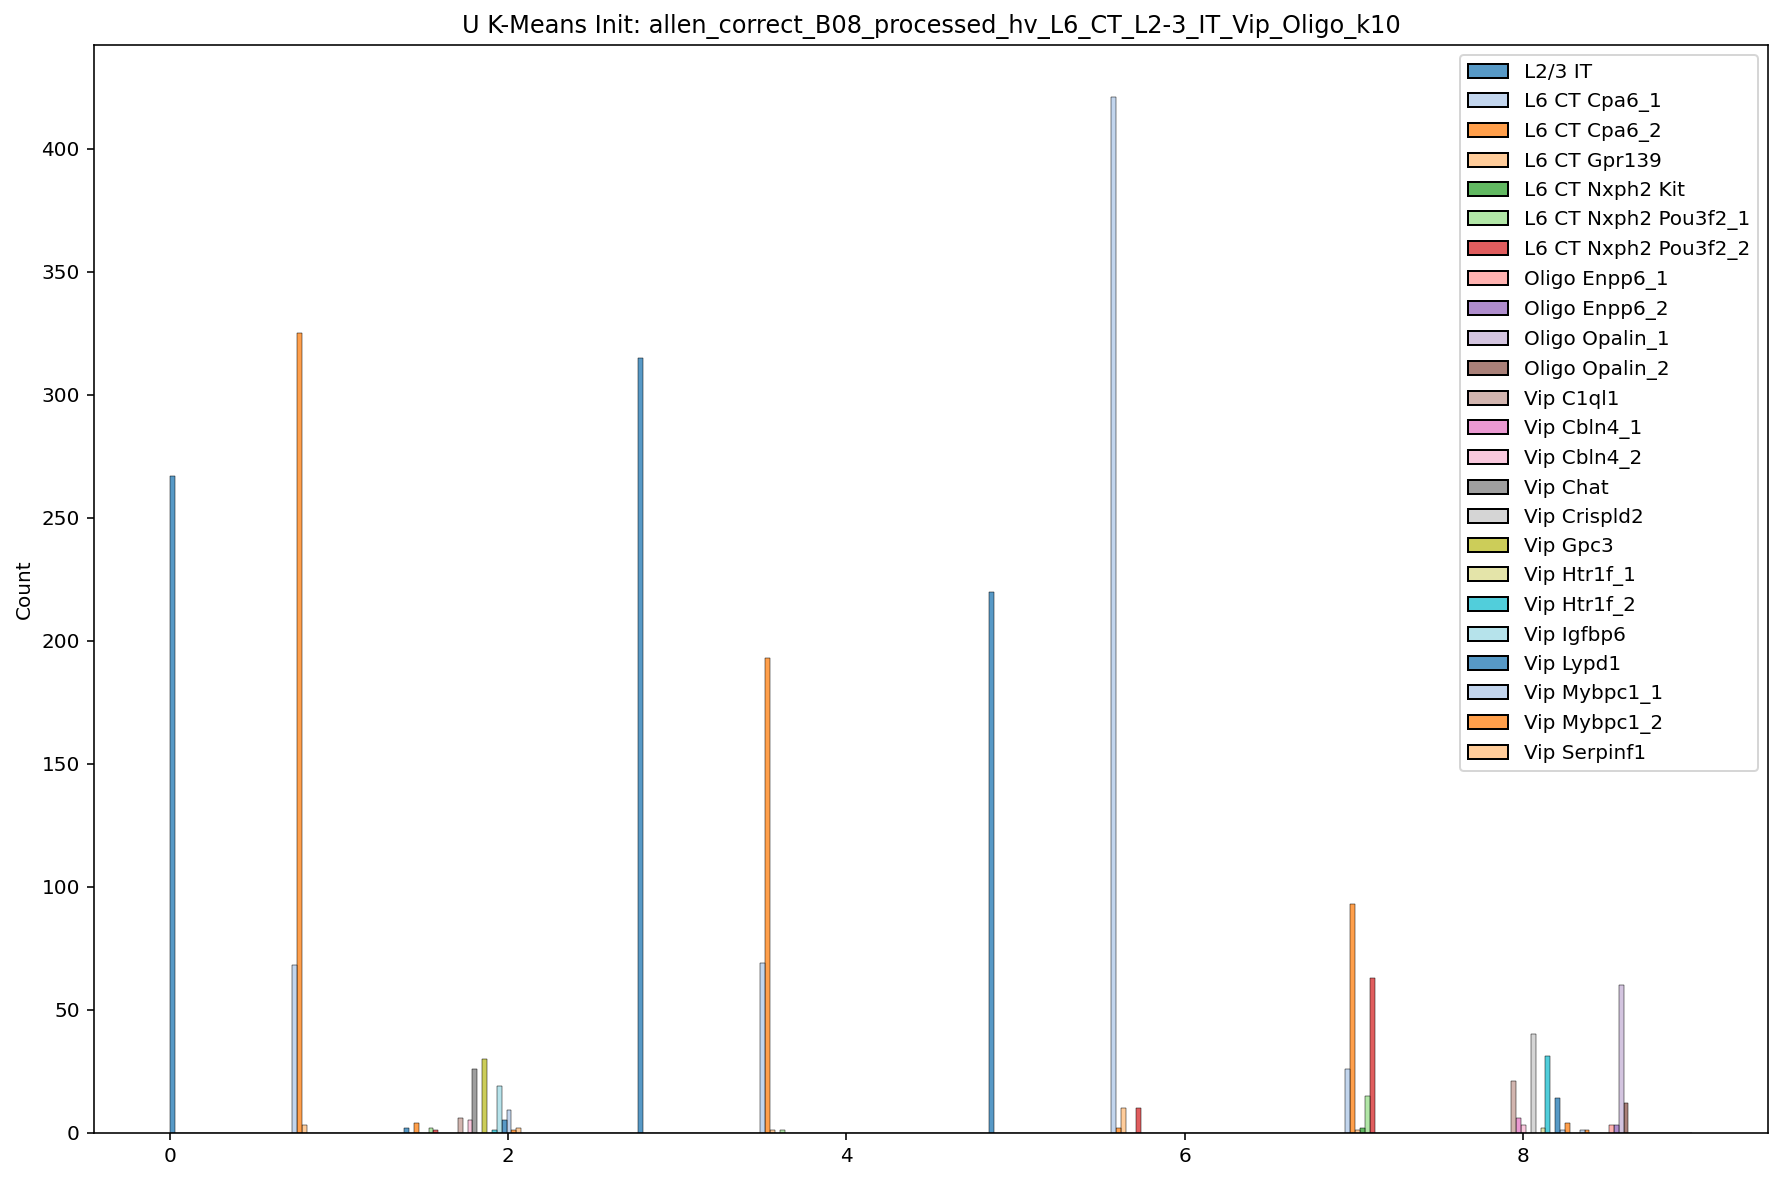

In [124]:
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False,dataset_attr_names=attribute_names,cf=cf[which])

    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)
    print(S_t.shape)

    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(S_t)
    labs = kmeans.labels_


    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('U K-Means Init: '+dataset_names[which])
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('U K-Means Init: '+dataset_names[which])


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2000 features observed, 1

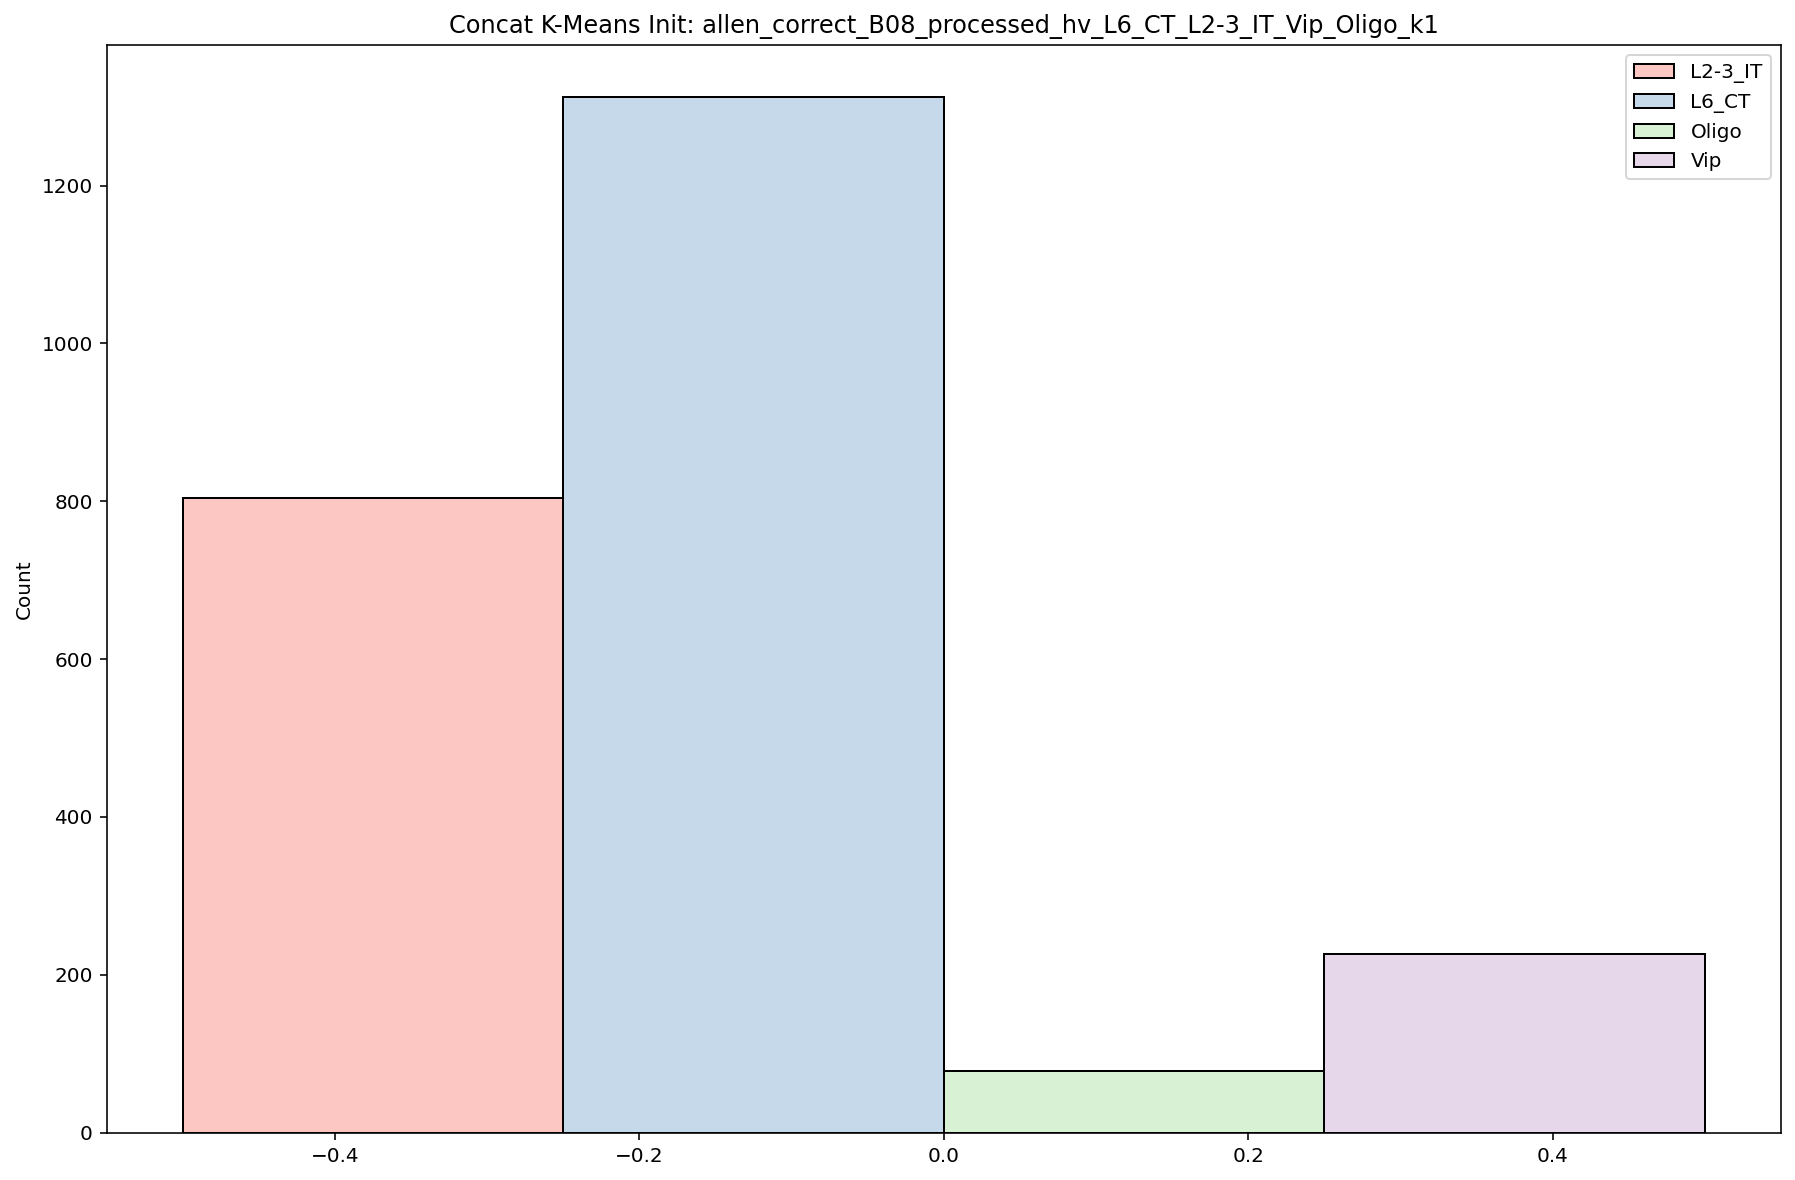

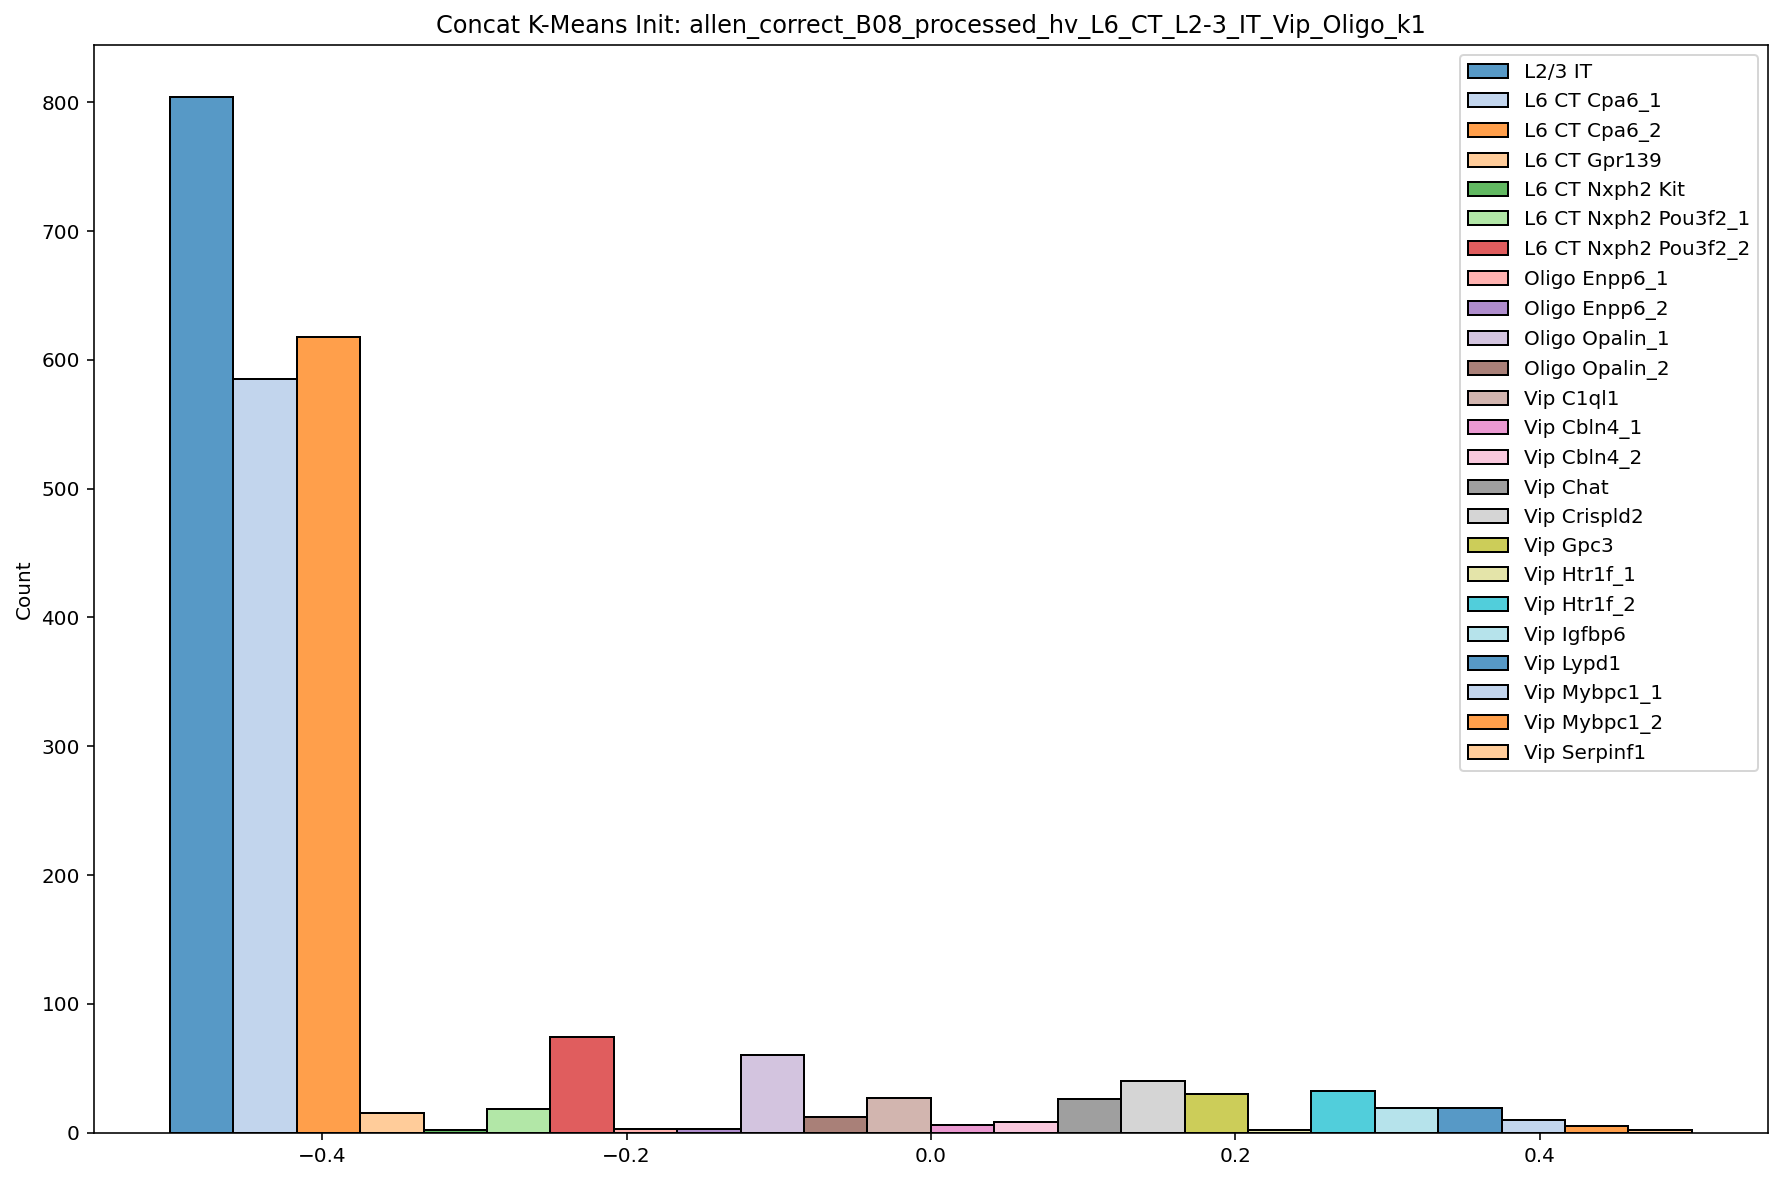

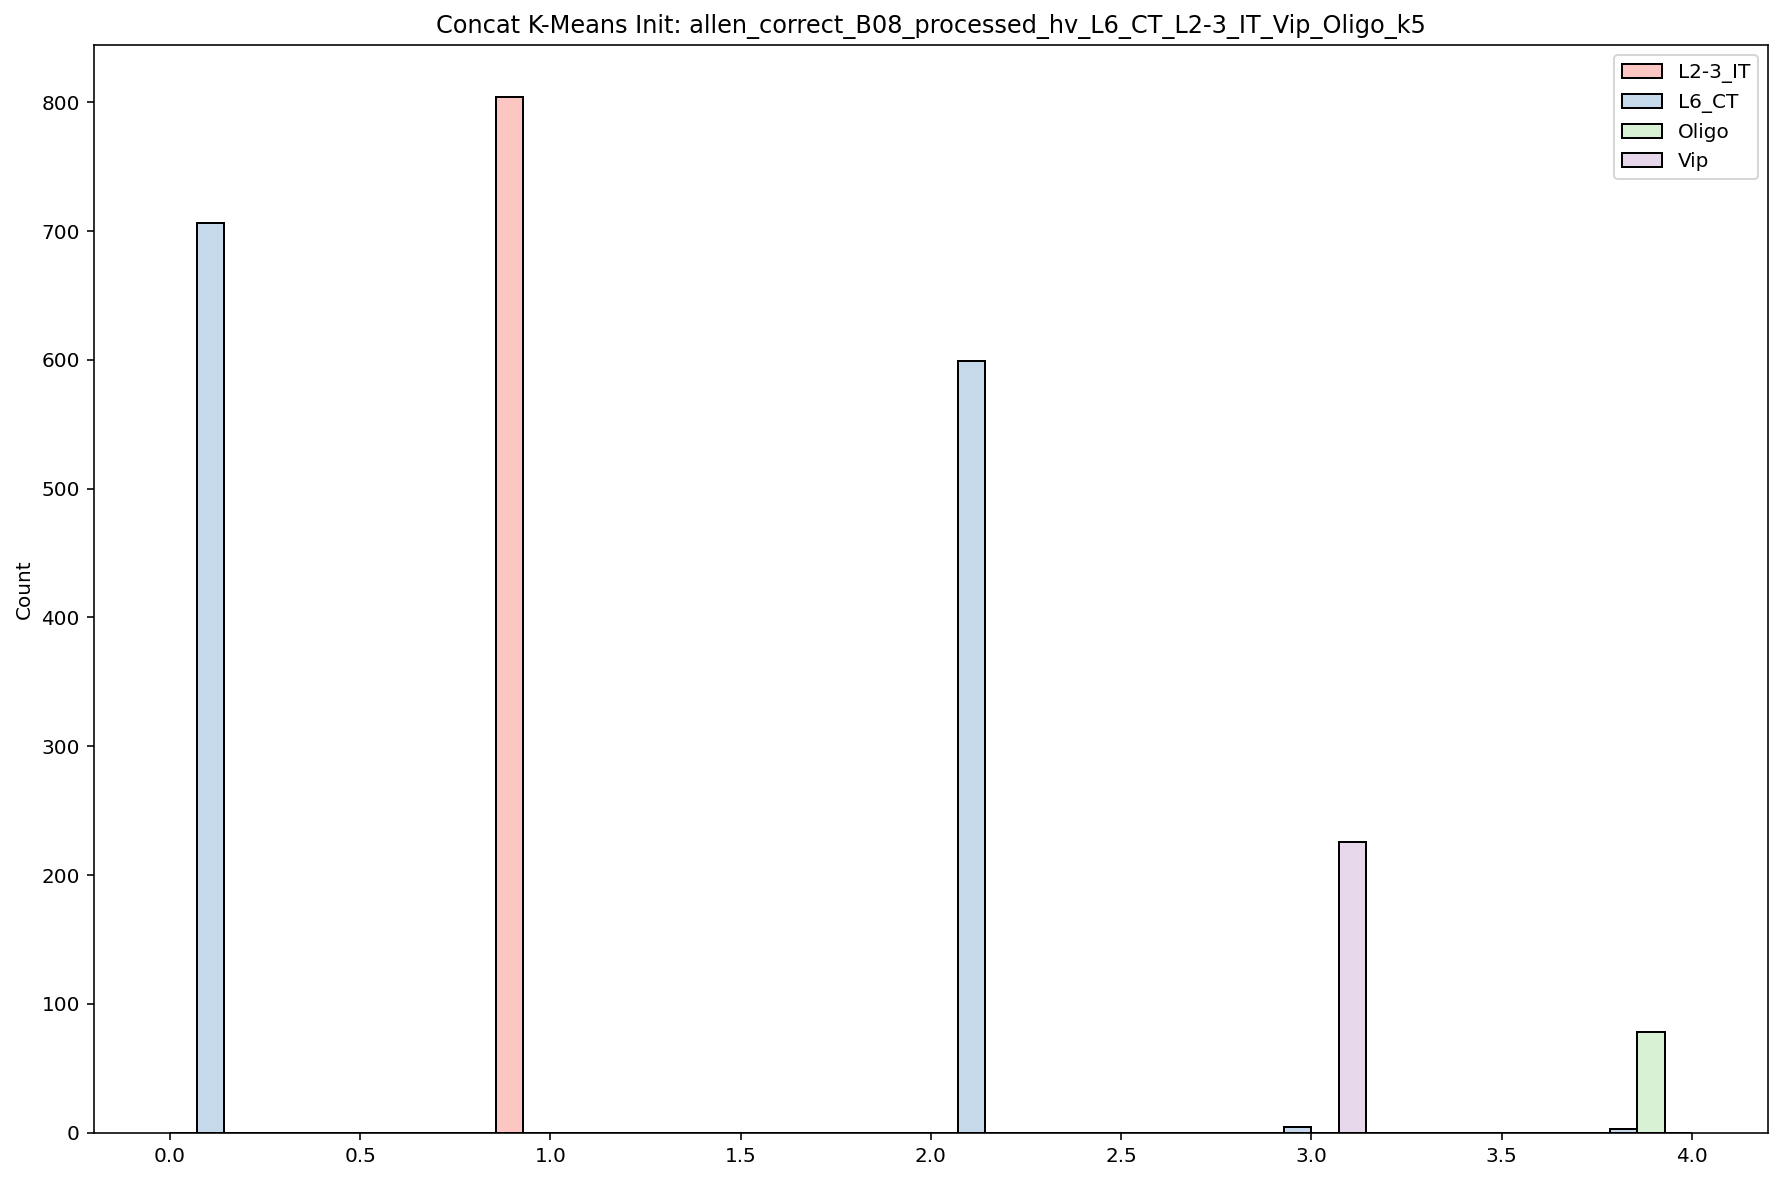

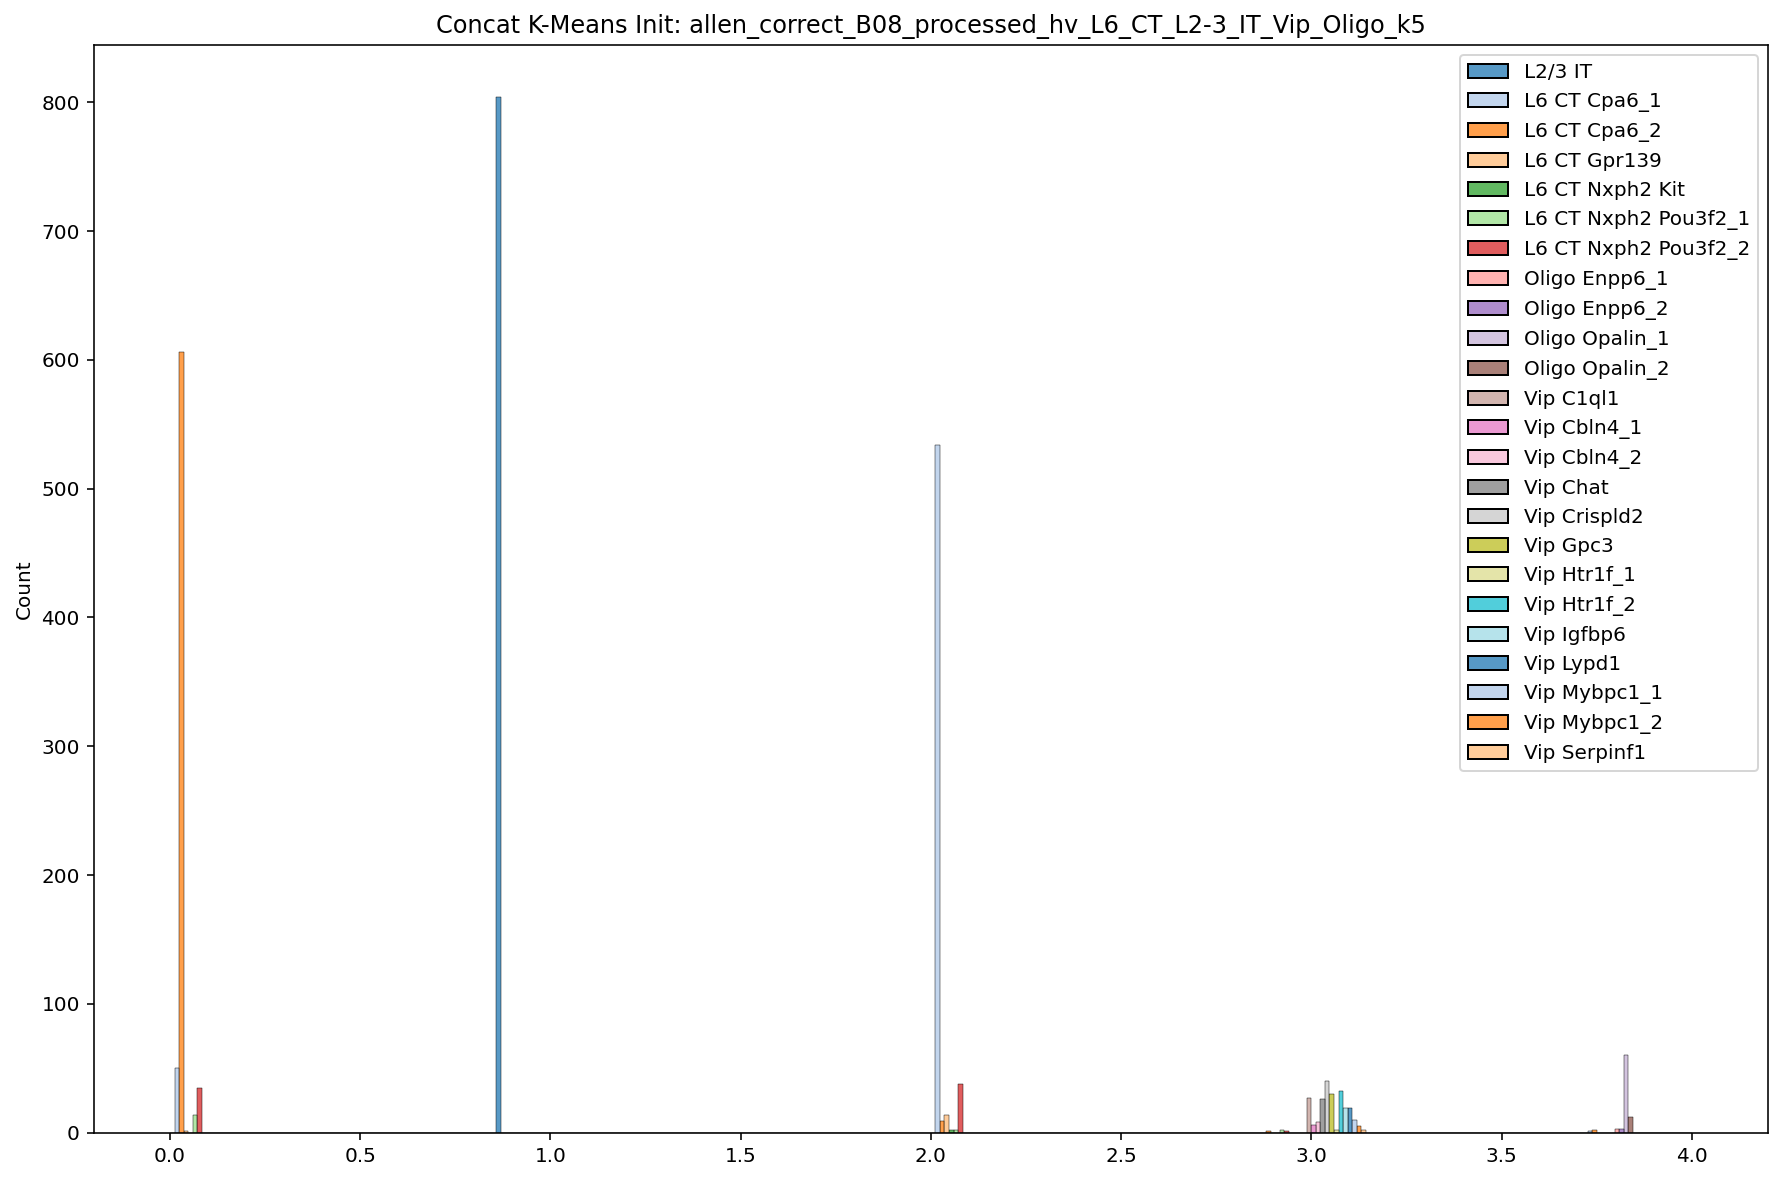

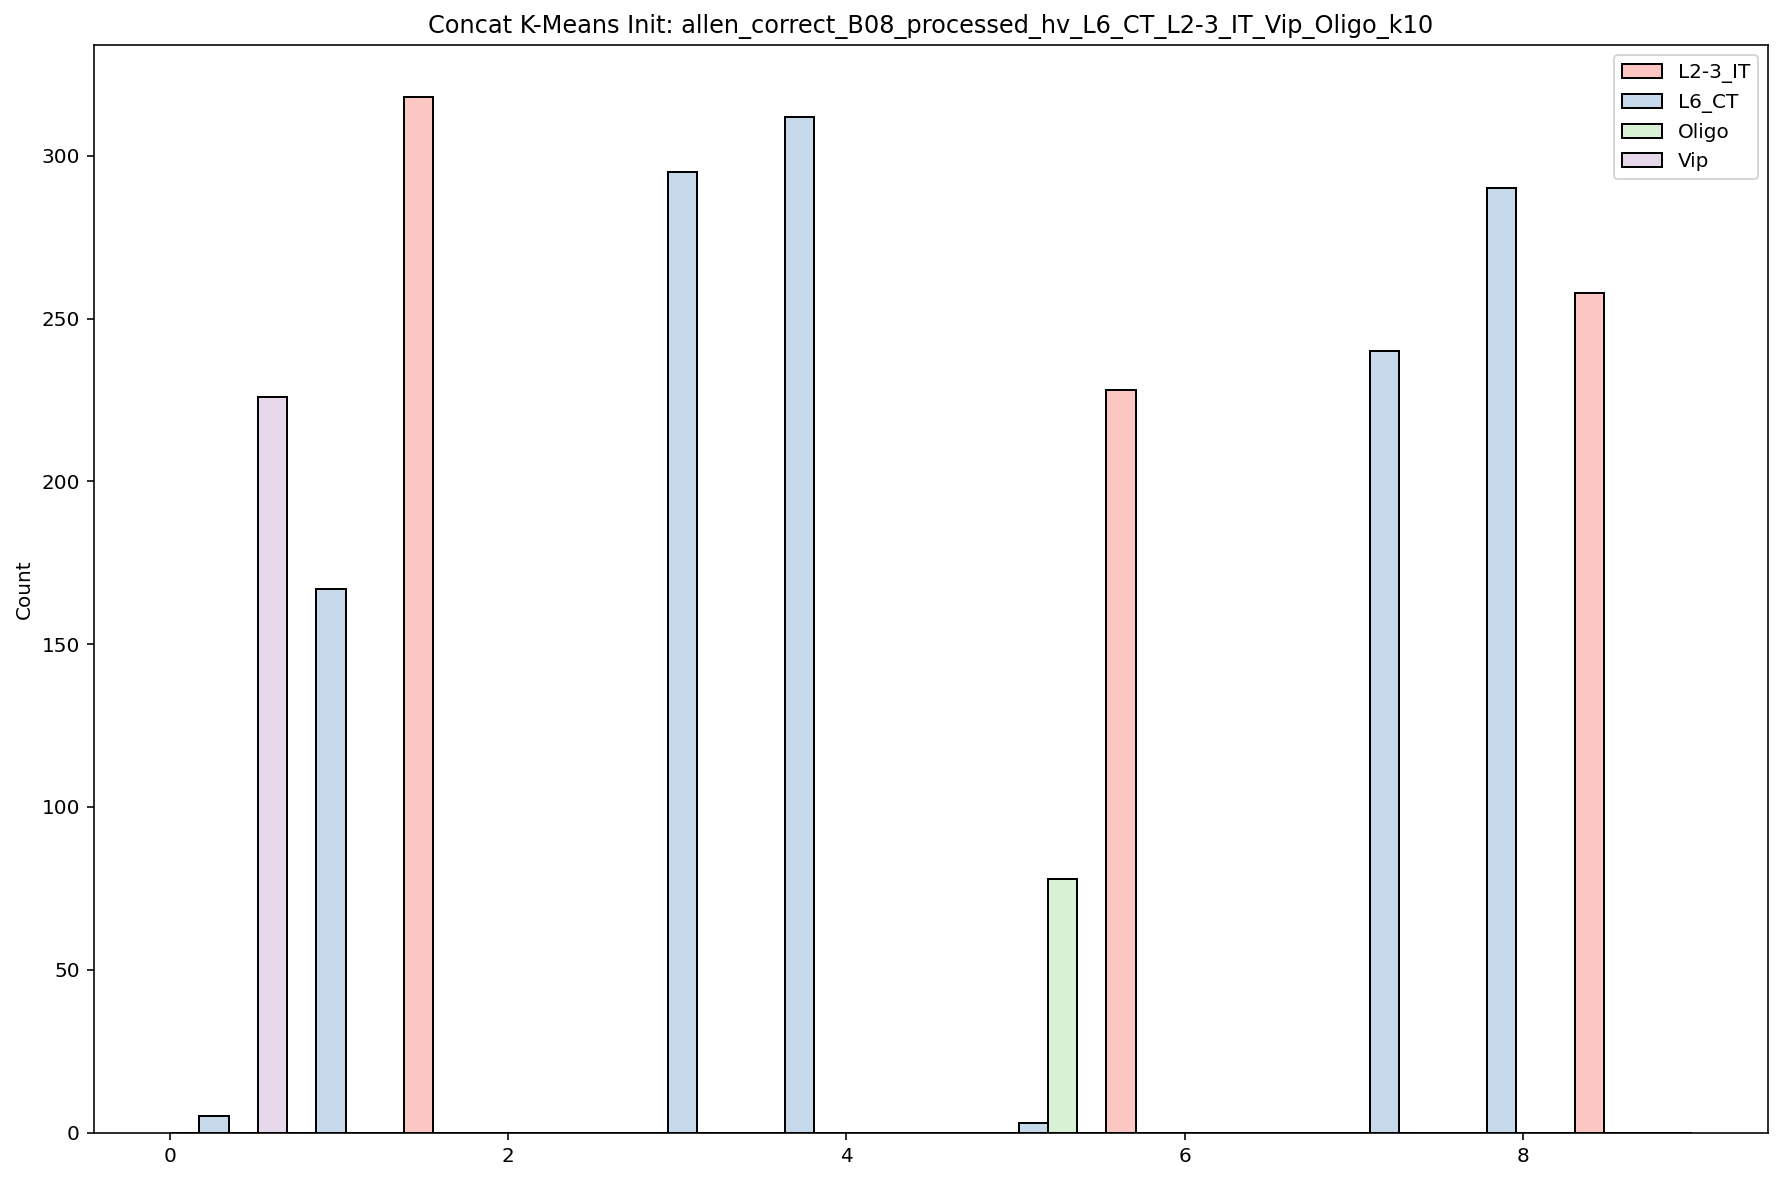

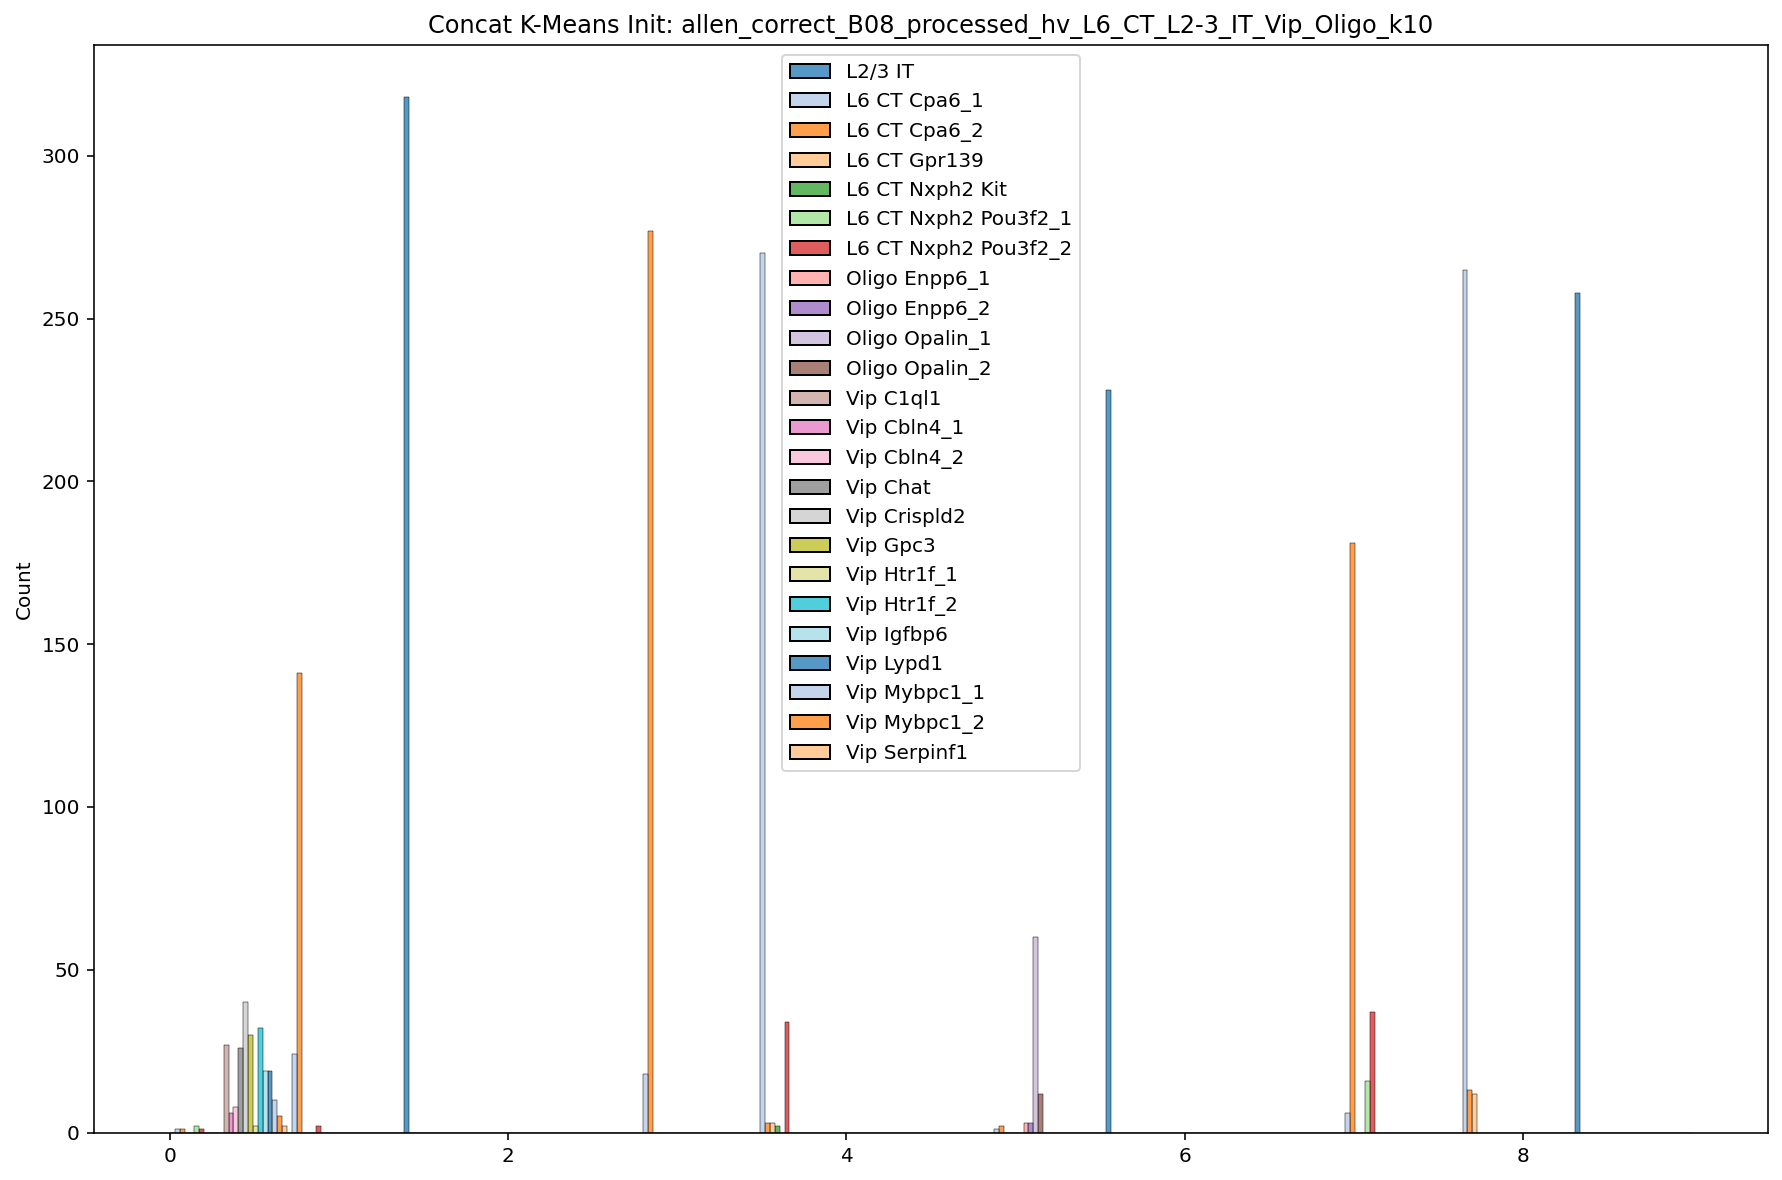

In [125]:
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    
    
    kmeans = KMeans(n_clusters=ks[which%num_ks], random_state=0).fit(concat)
    labs = kmeans.labels_

    labels = labs
    all_groups_kmeans += [labs]
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('Concat K-Means Init: '+dataset_names[i])

    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('Concat K-Means Init: '+dataset_names[which])
    
    

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

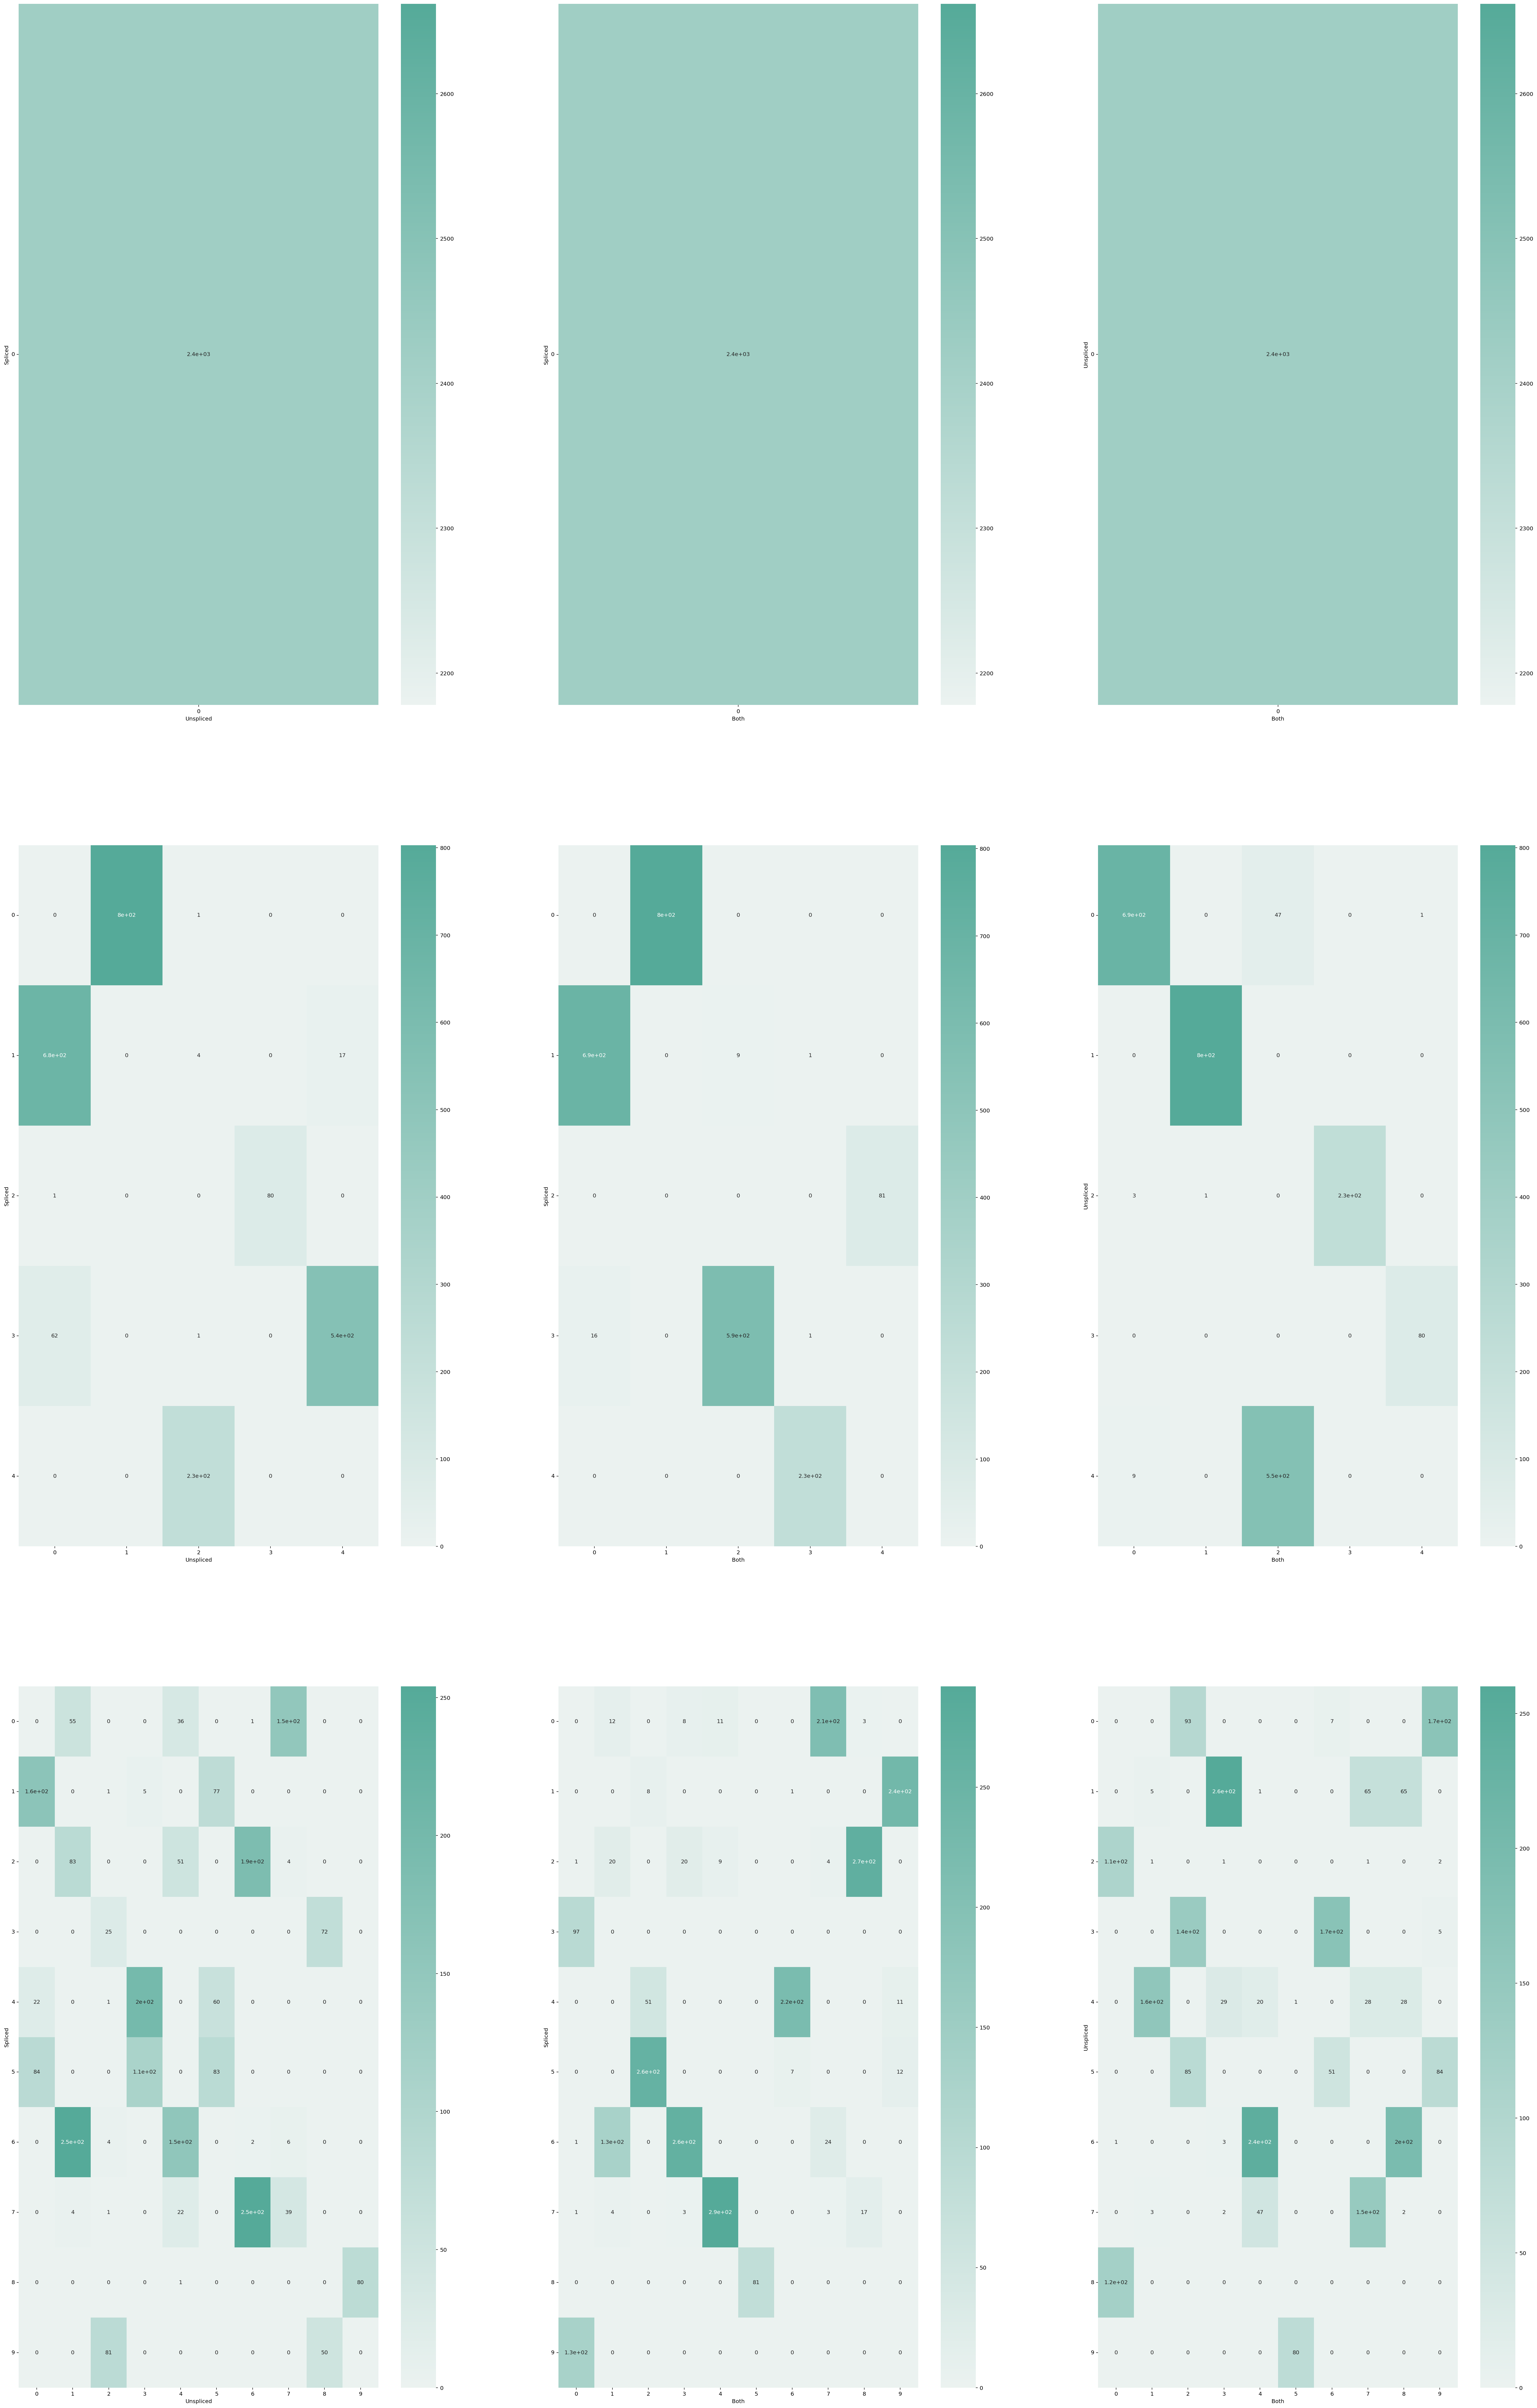

In [126]:
#compare overlap of all k-means assignments

num_per_set = len(chosen)*num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,80))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups_kmeans[p[1]*(num_per_set)+i]
        true = all_groups_kmeans[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

Show leiden clusters

In [127]:
num_ks

3

In [128]:
neigh = 30
all_groups = []
res = [0.25,1.0,2.0]

INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2000 features observed, 1

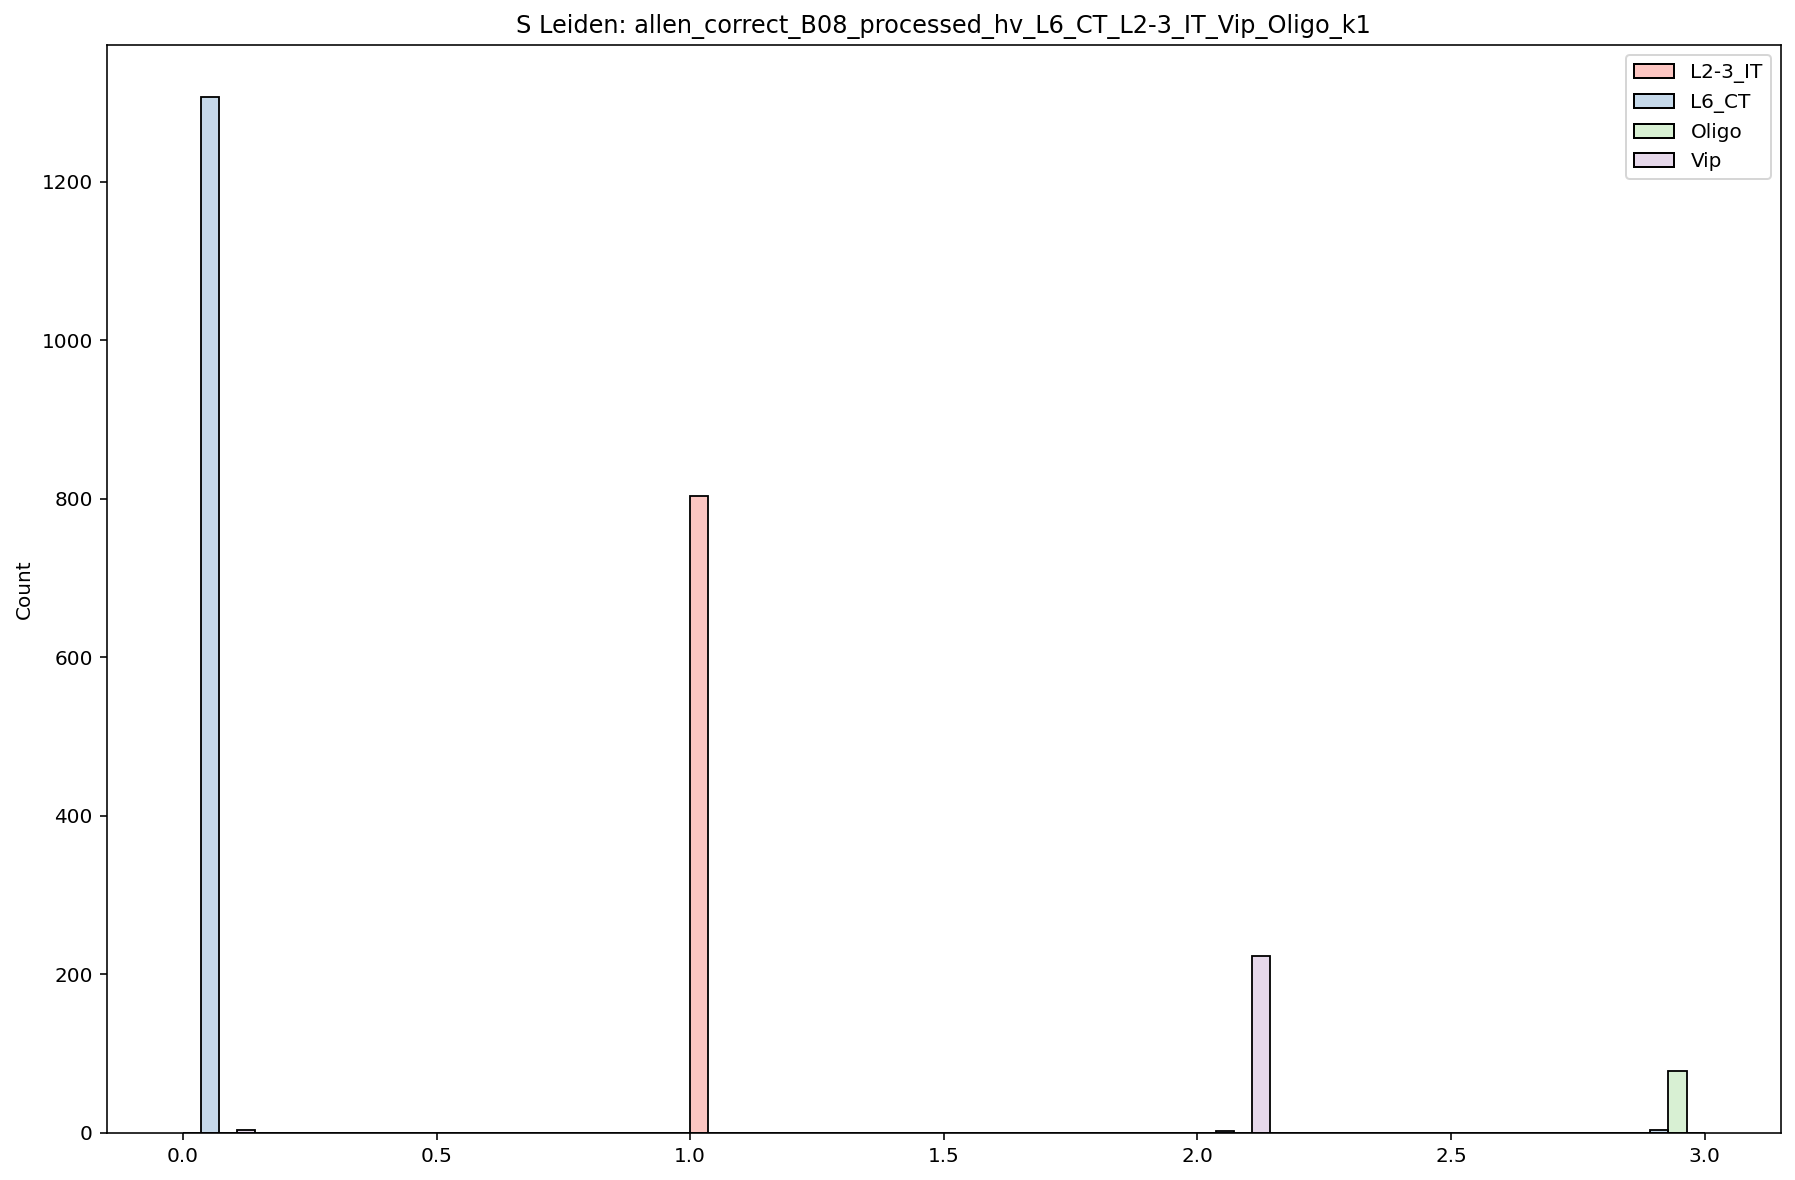

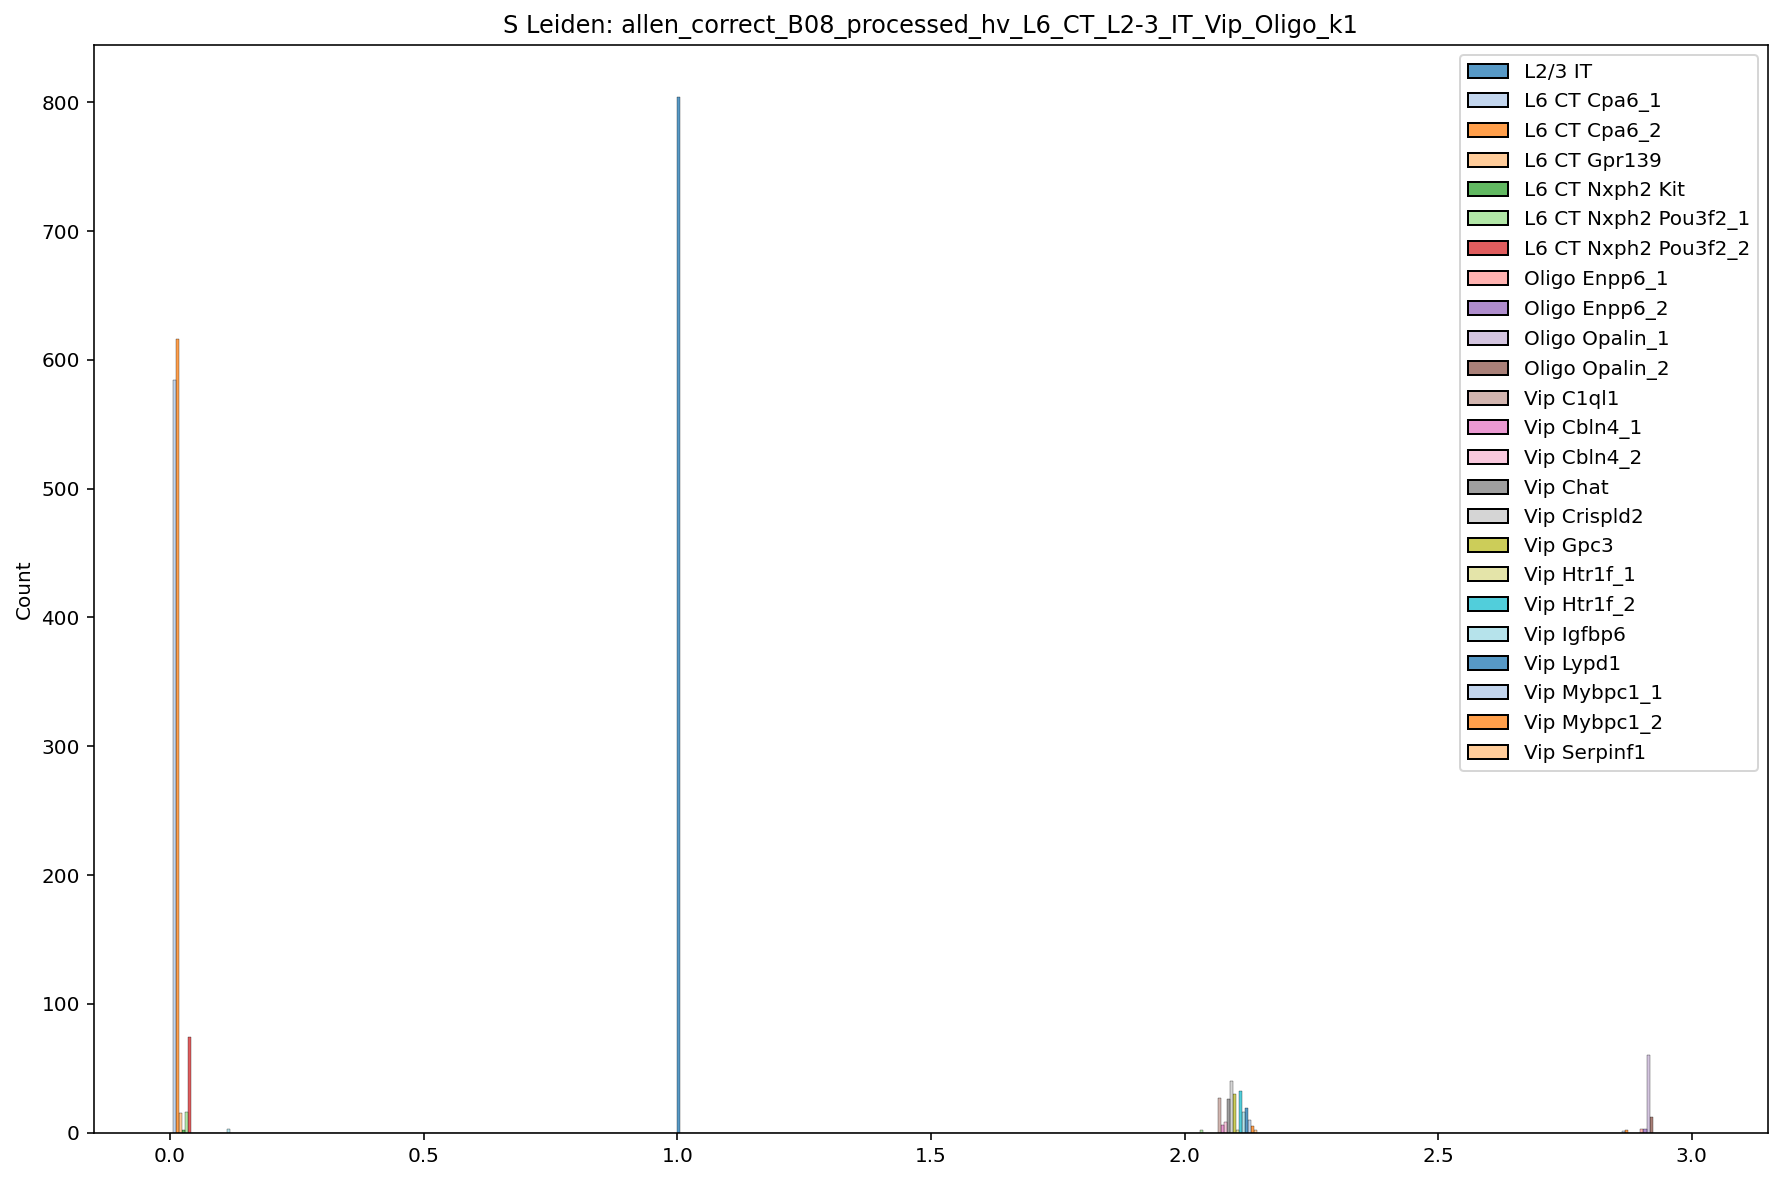

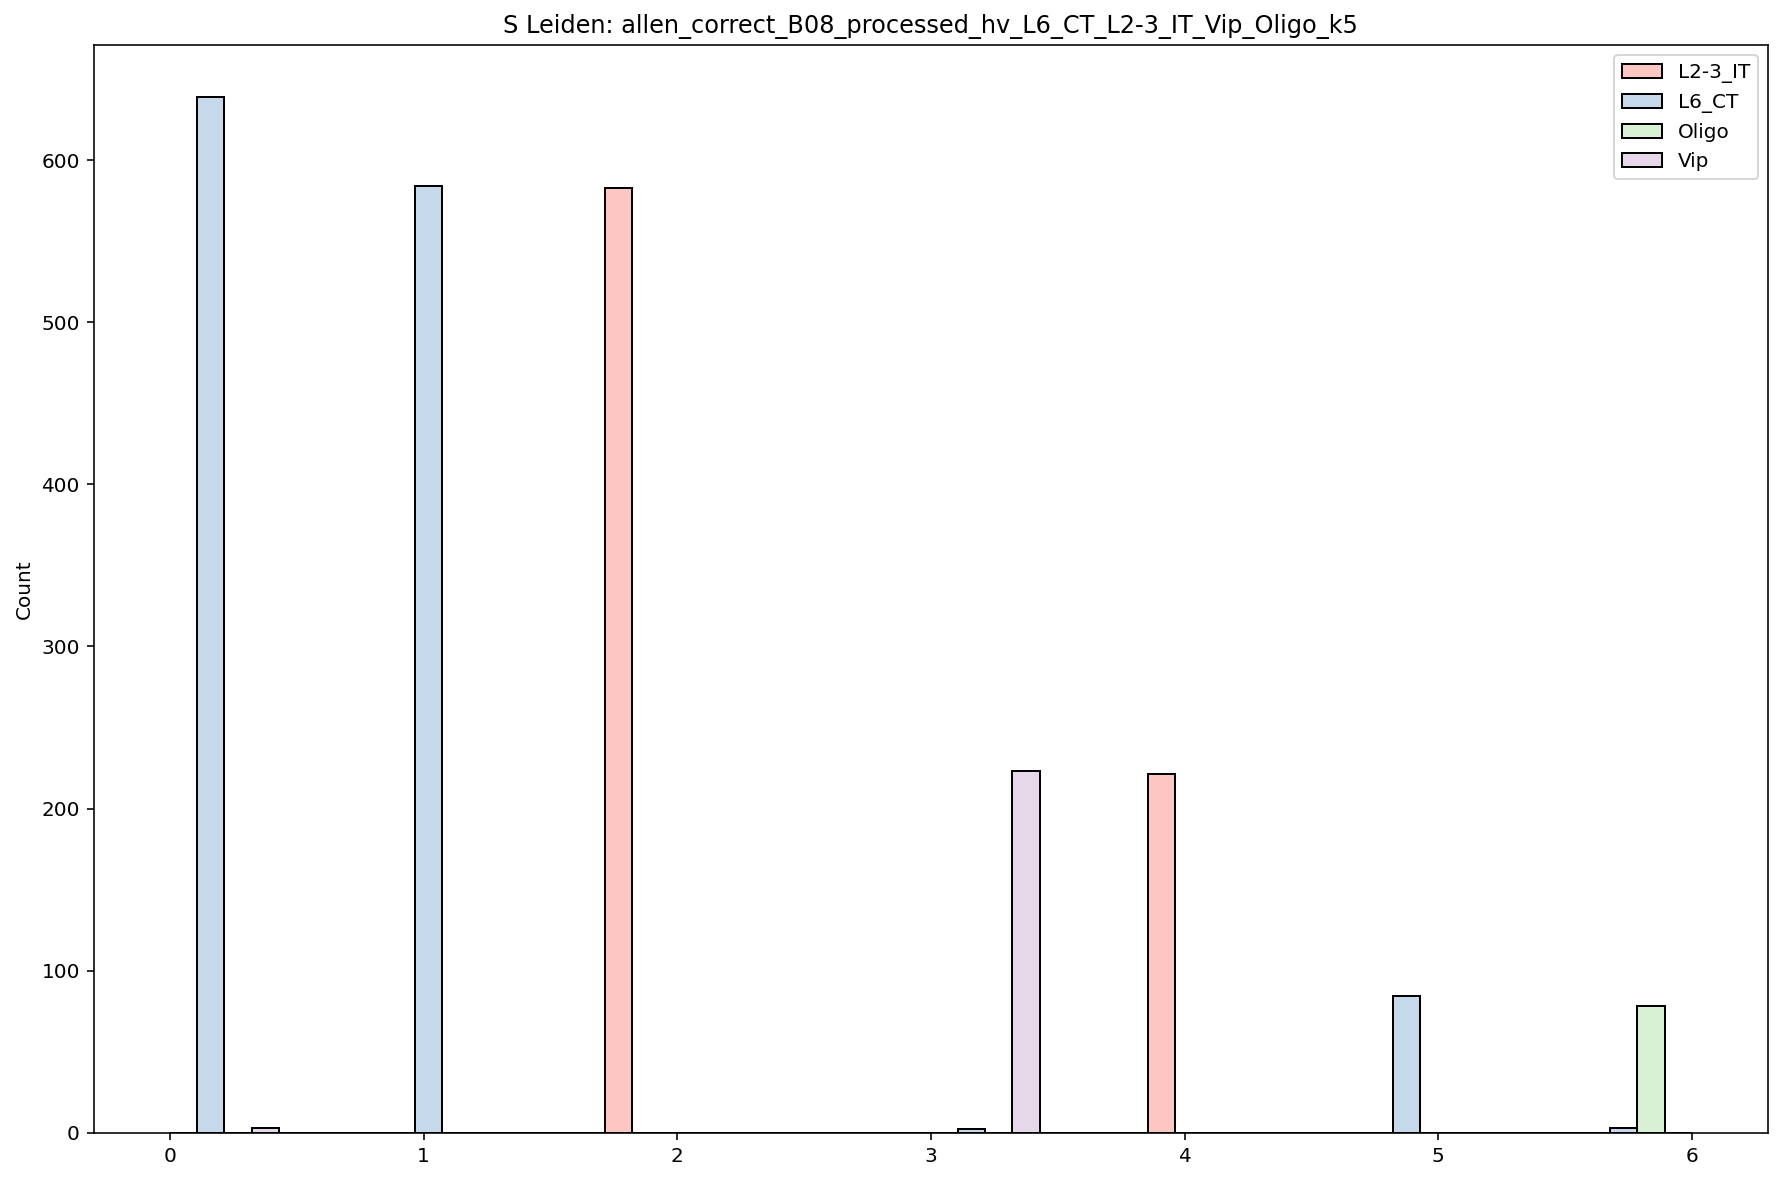

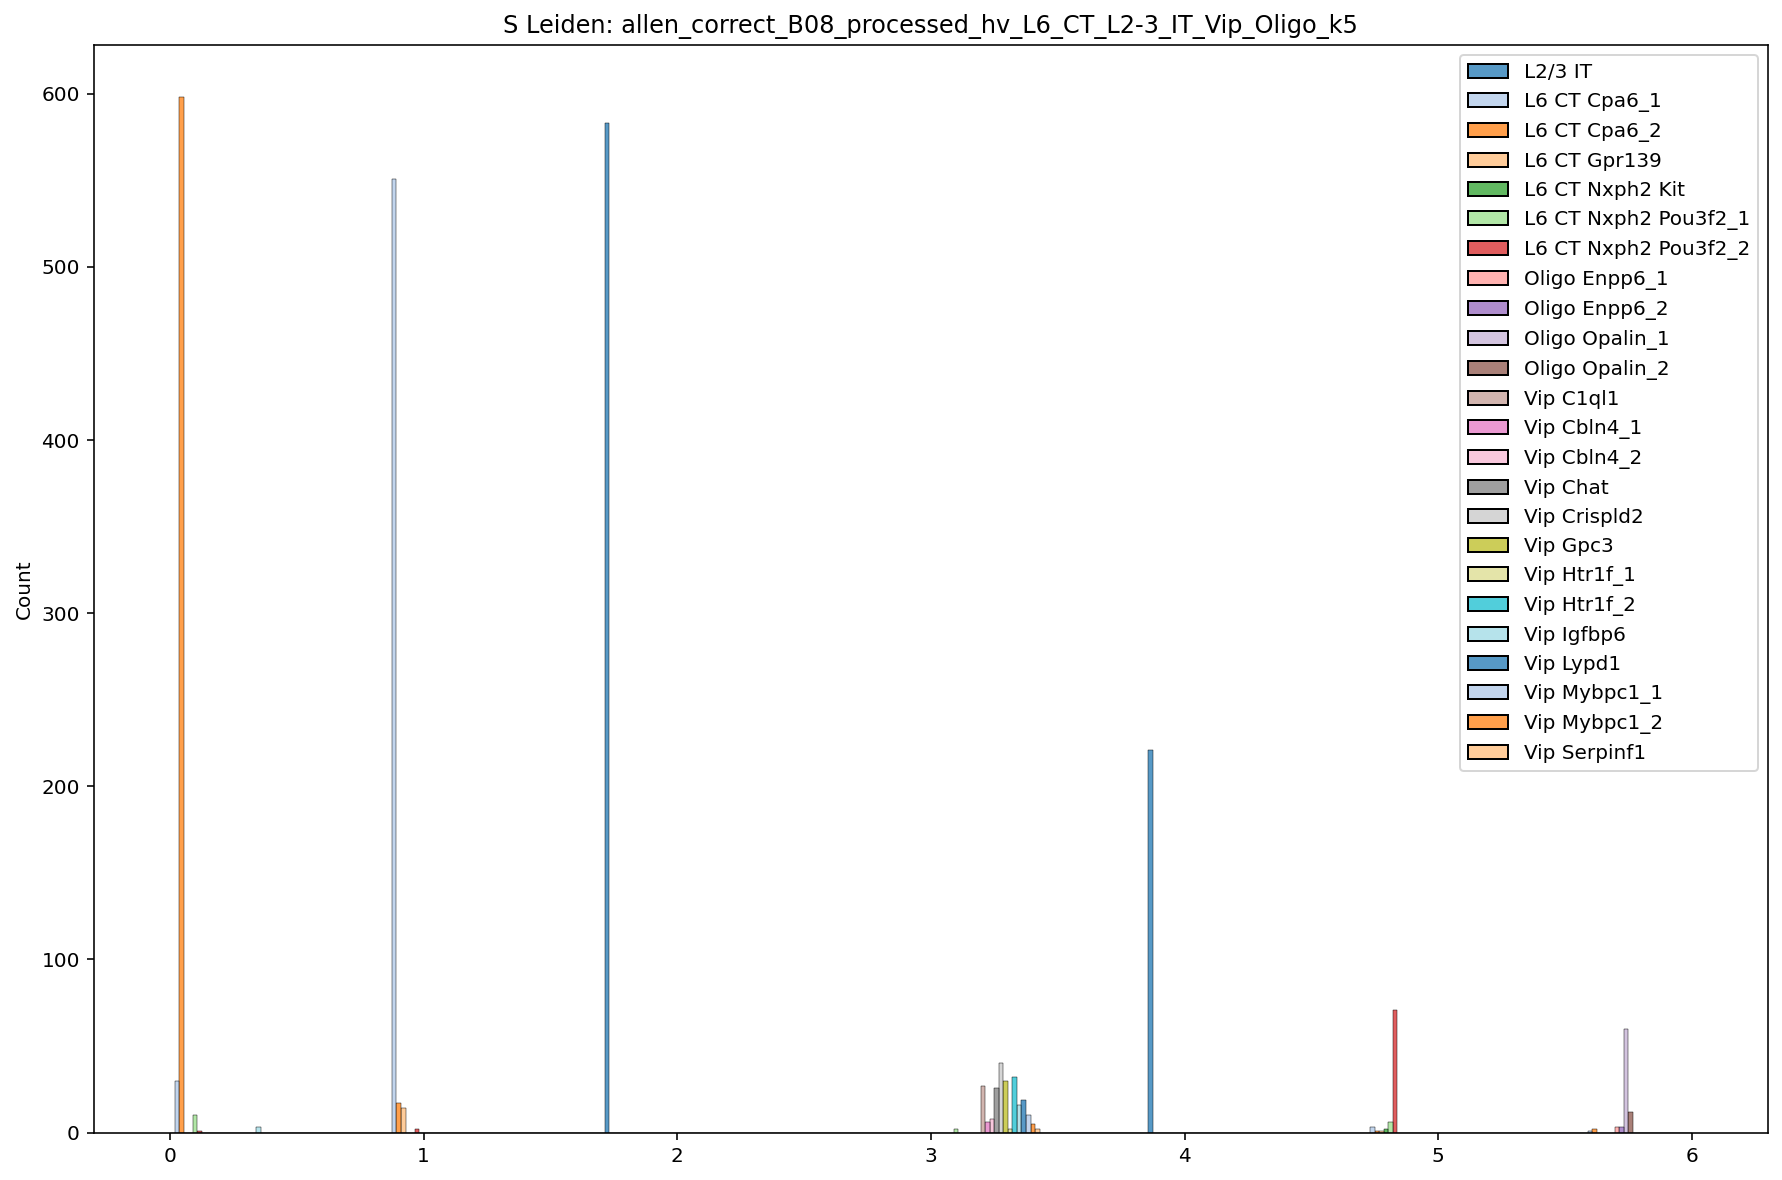

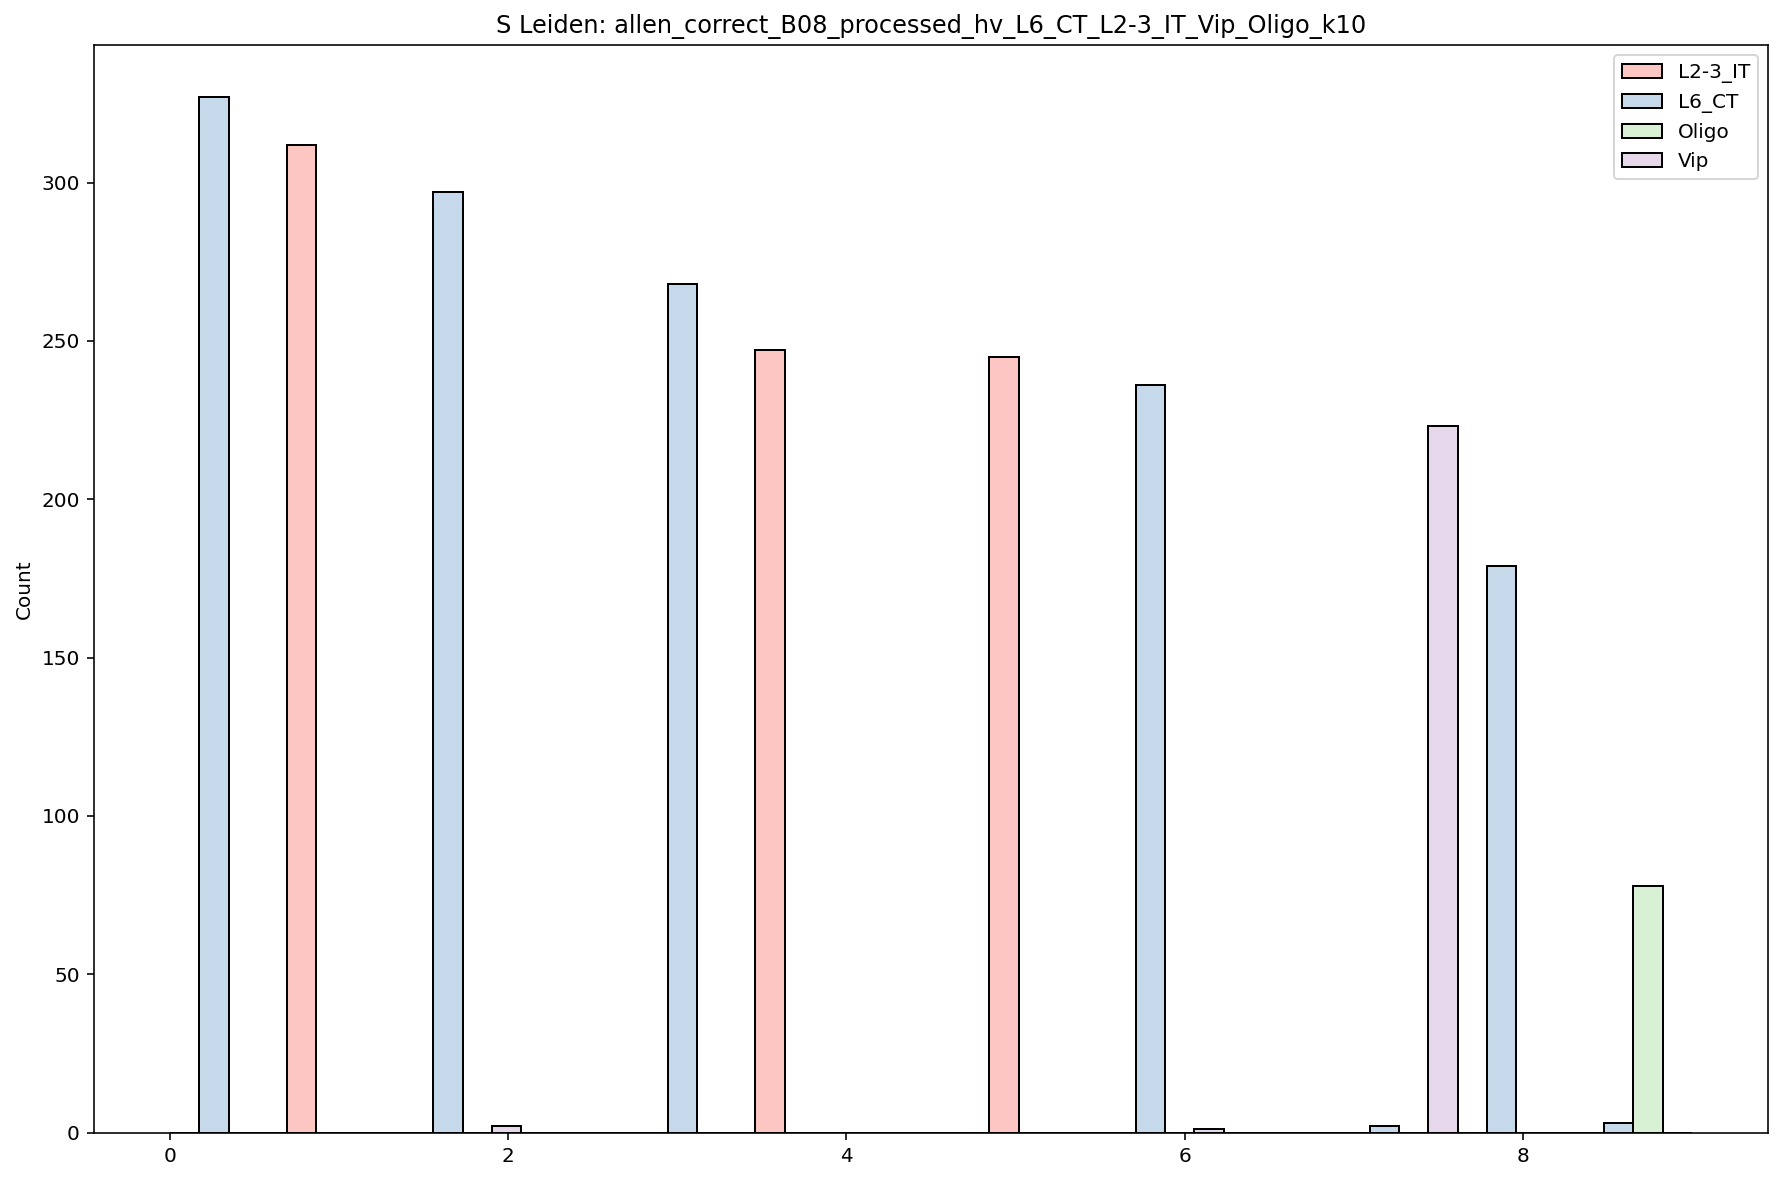

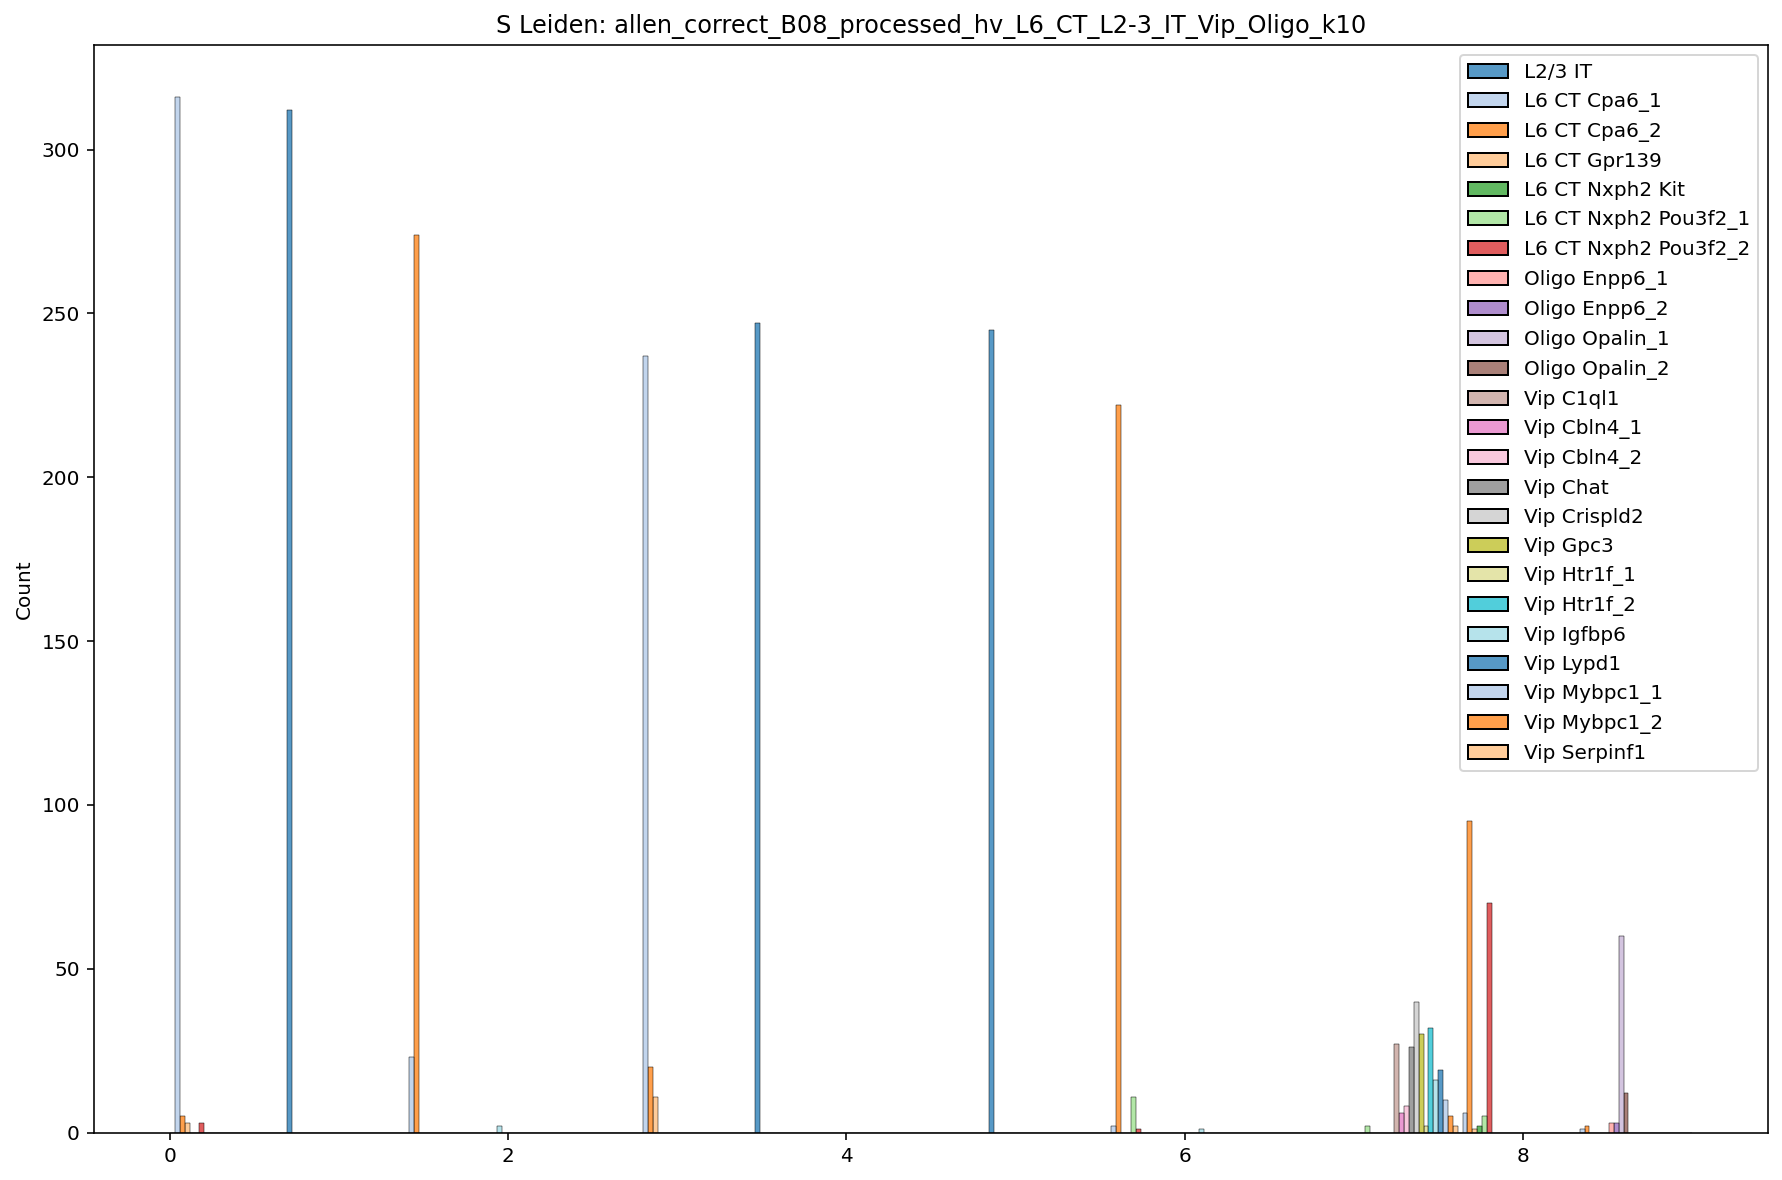

In [129]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[1,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[i])
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('S Leiden: '+dataset_names[which])
    
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2000 features observed, 1

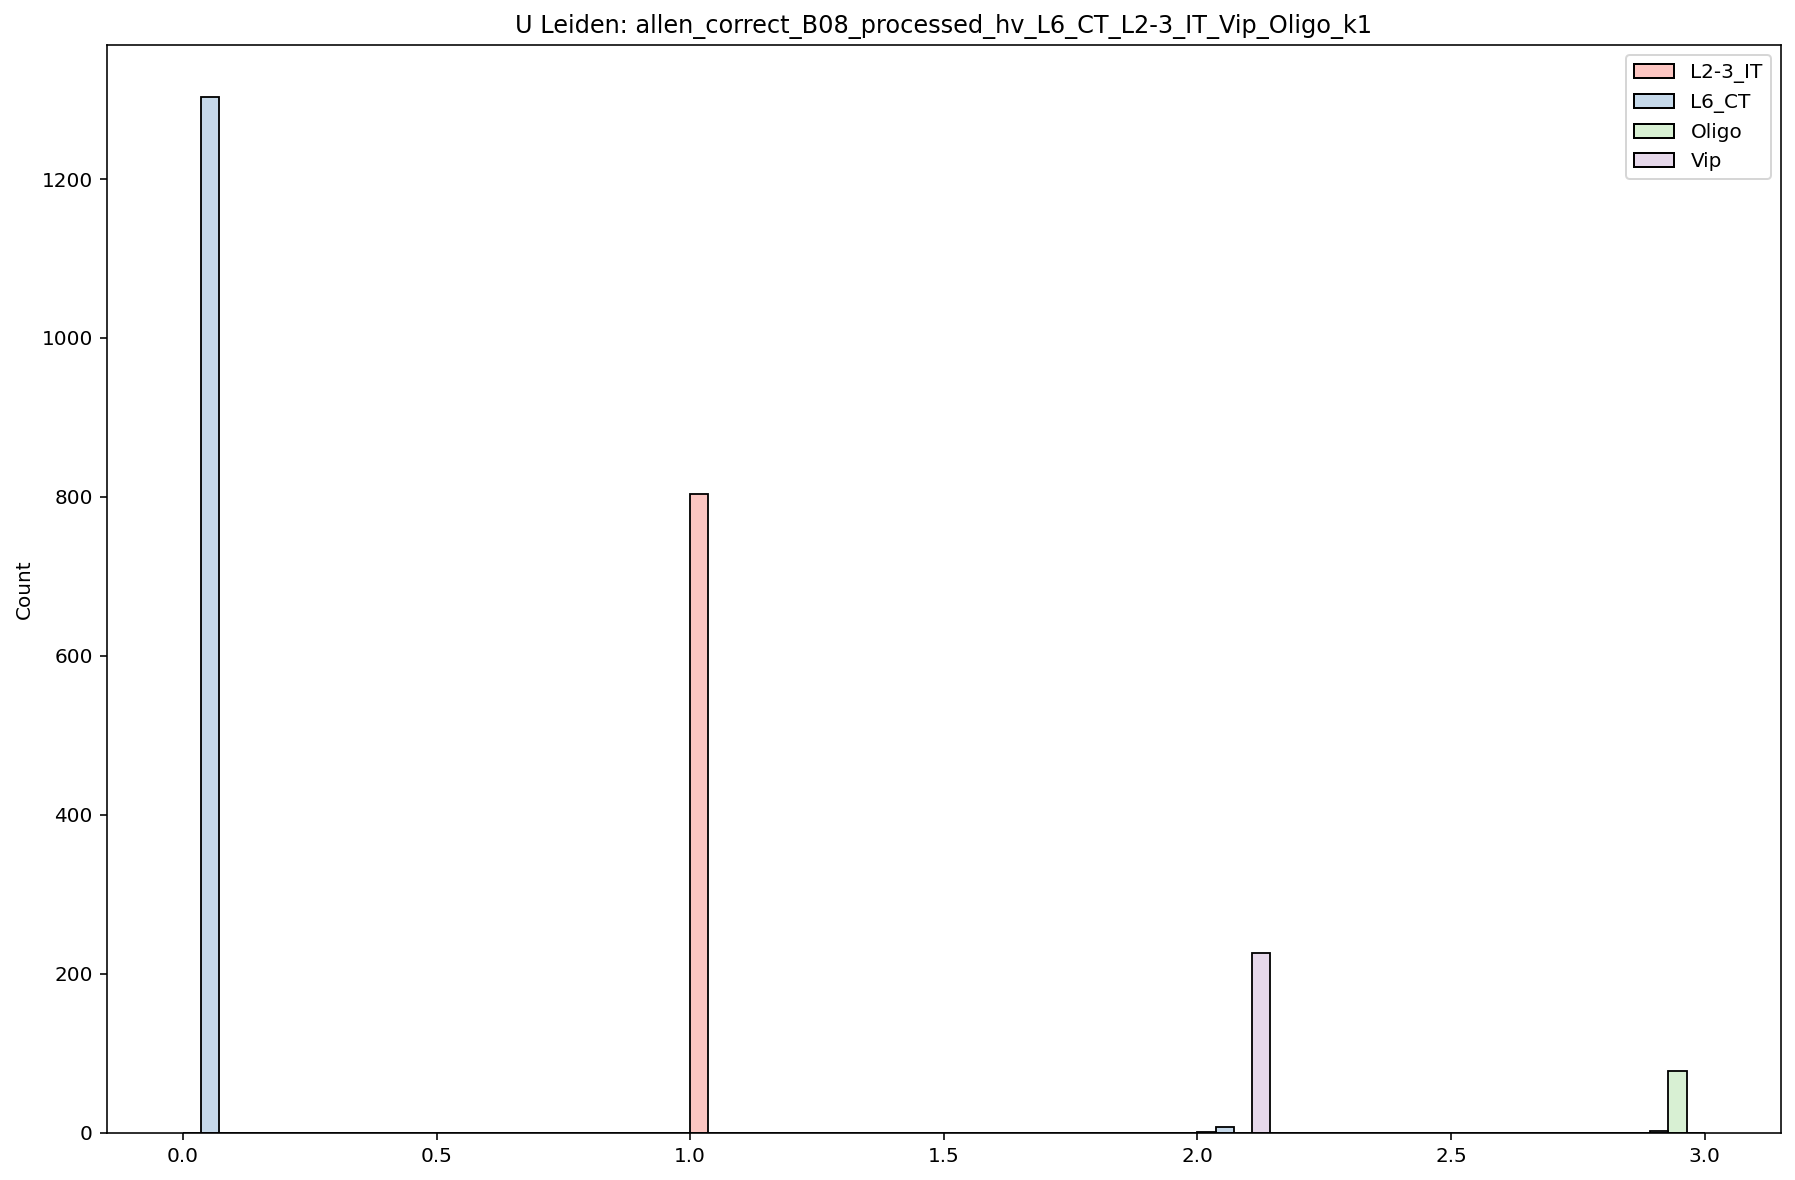

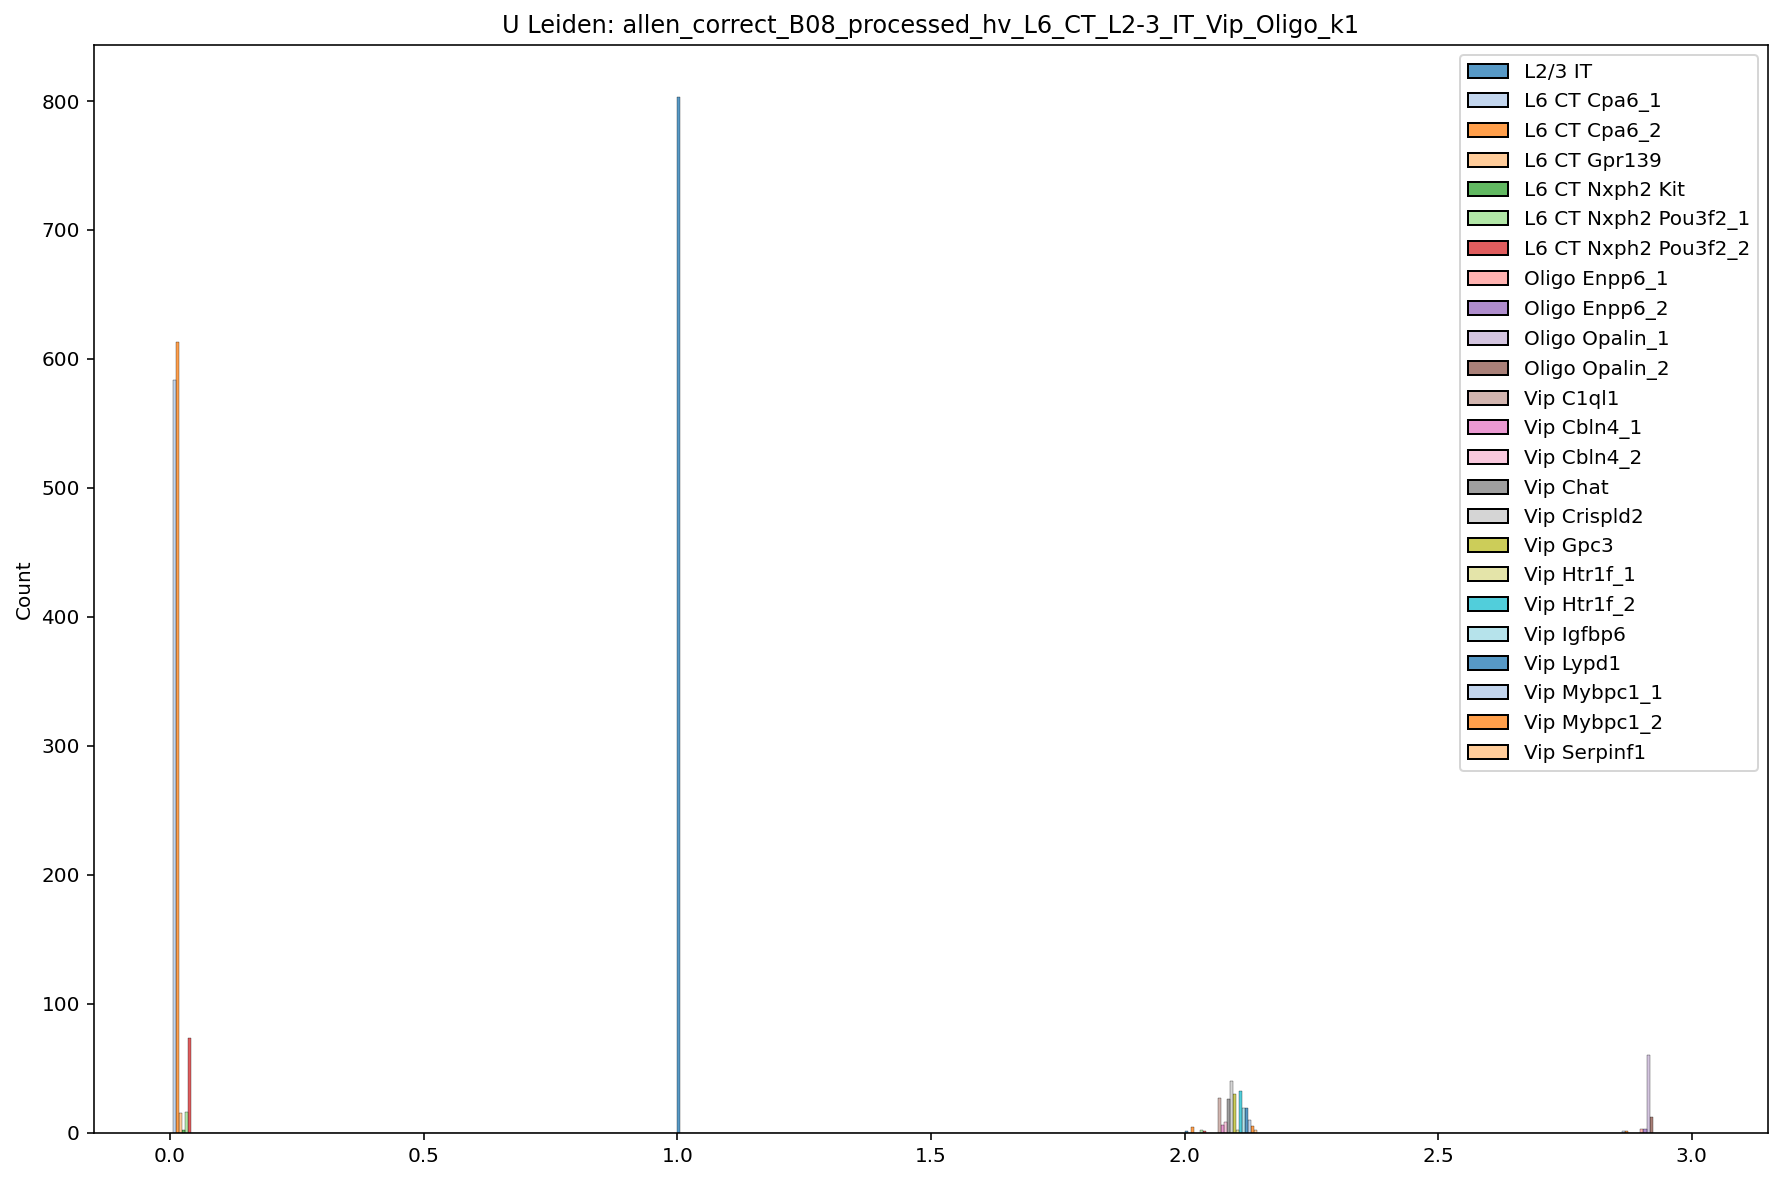

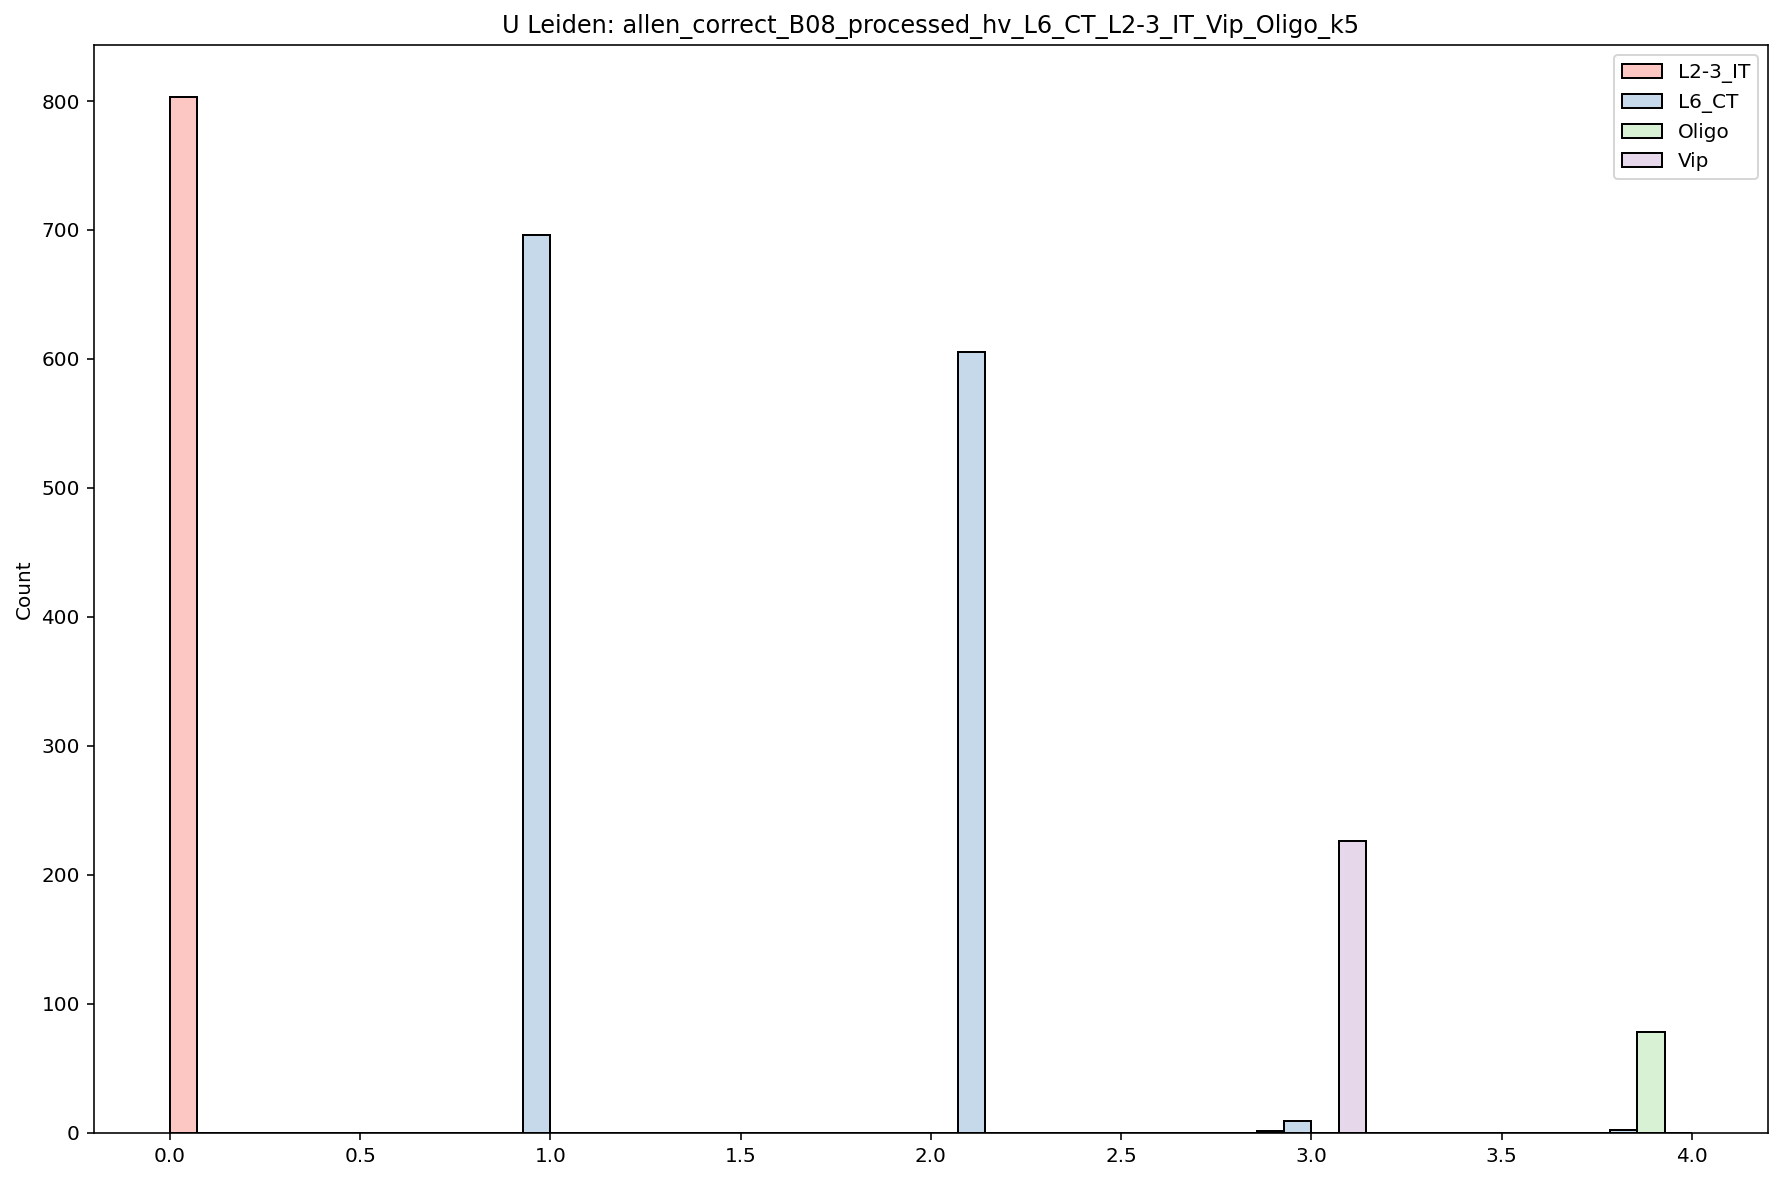

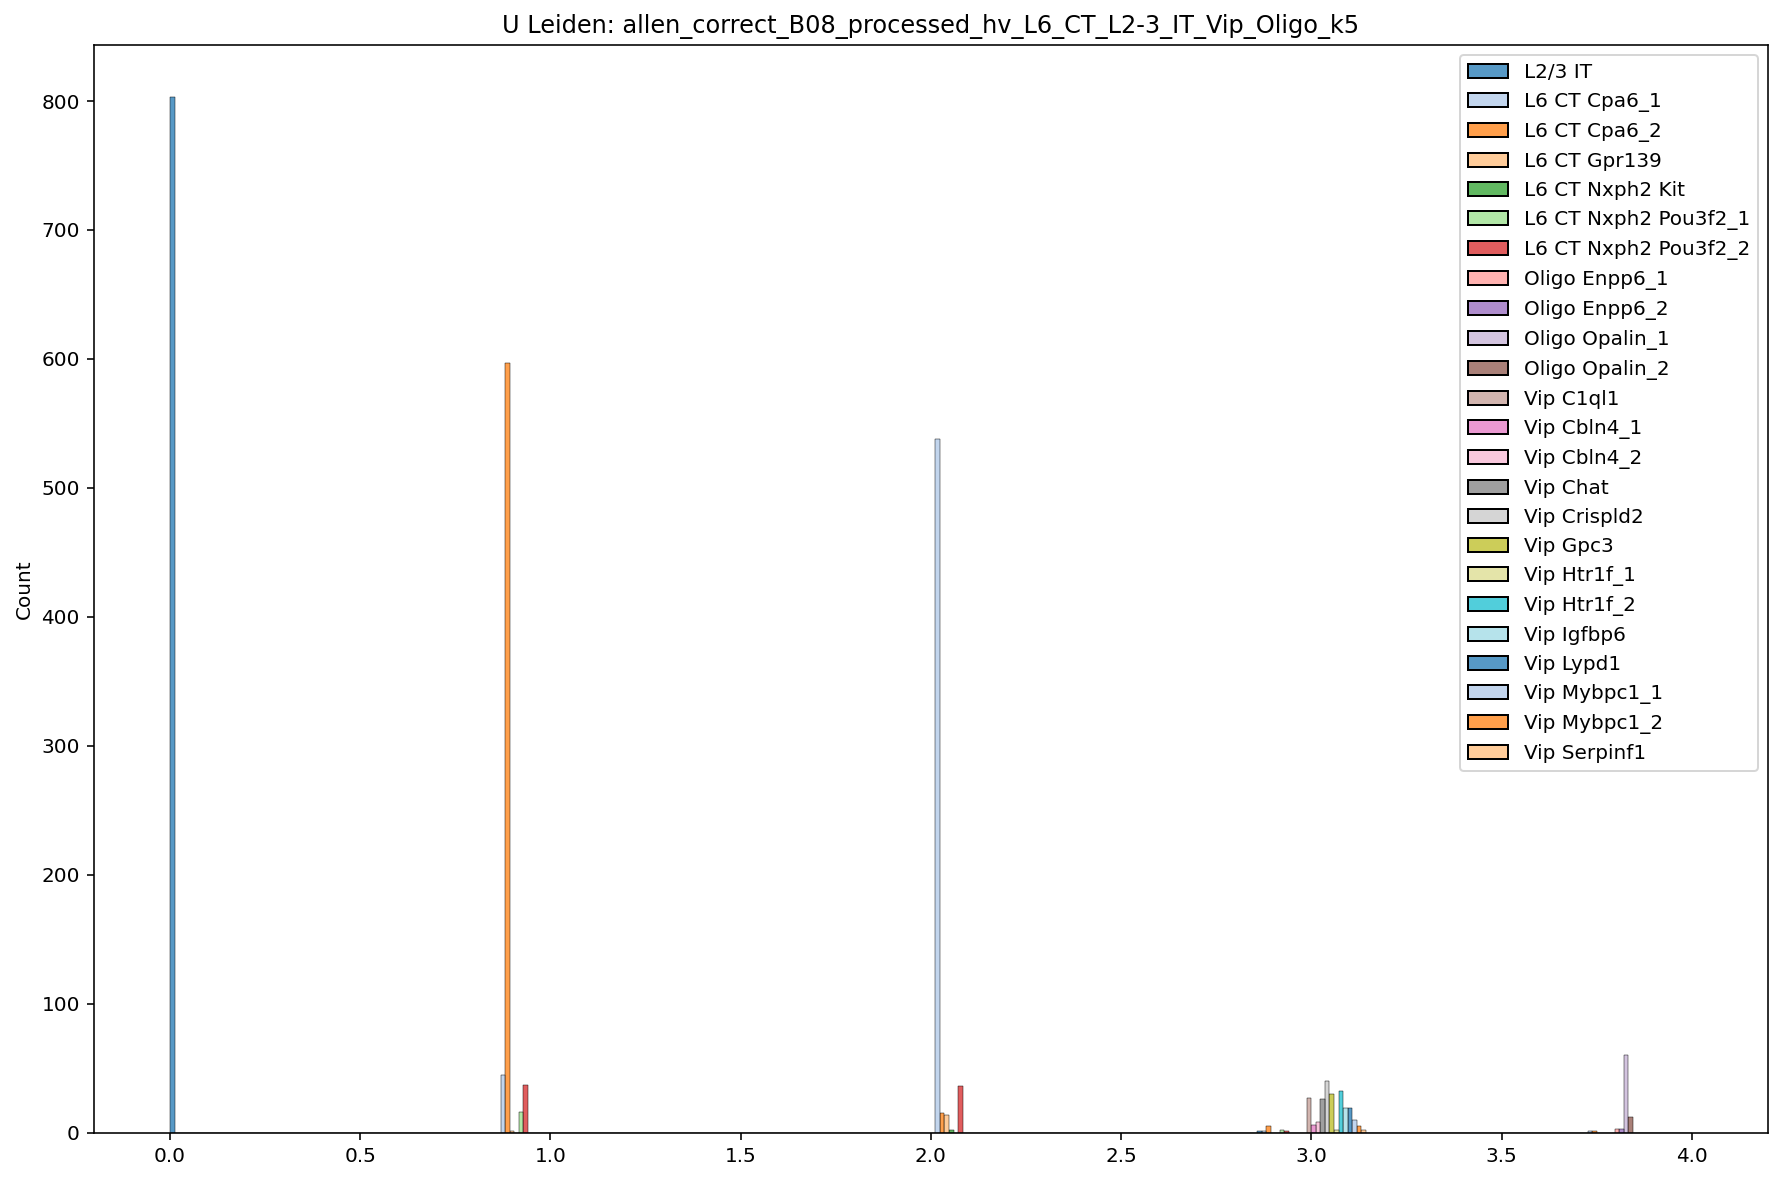

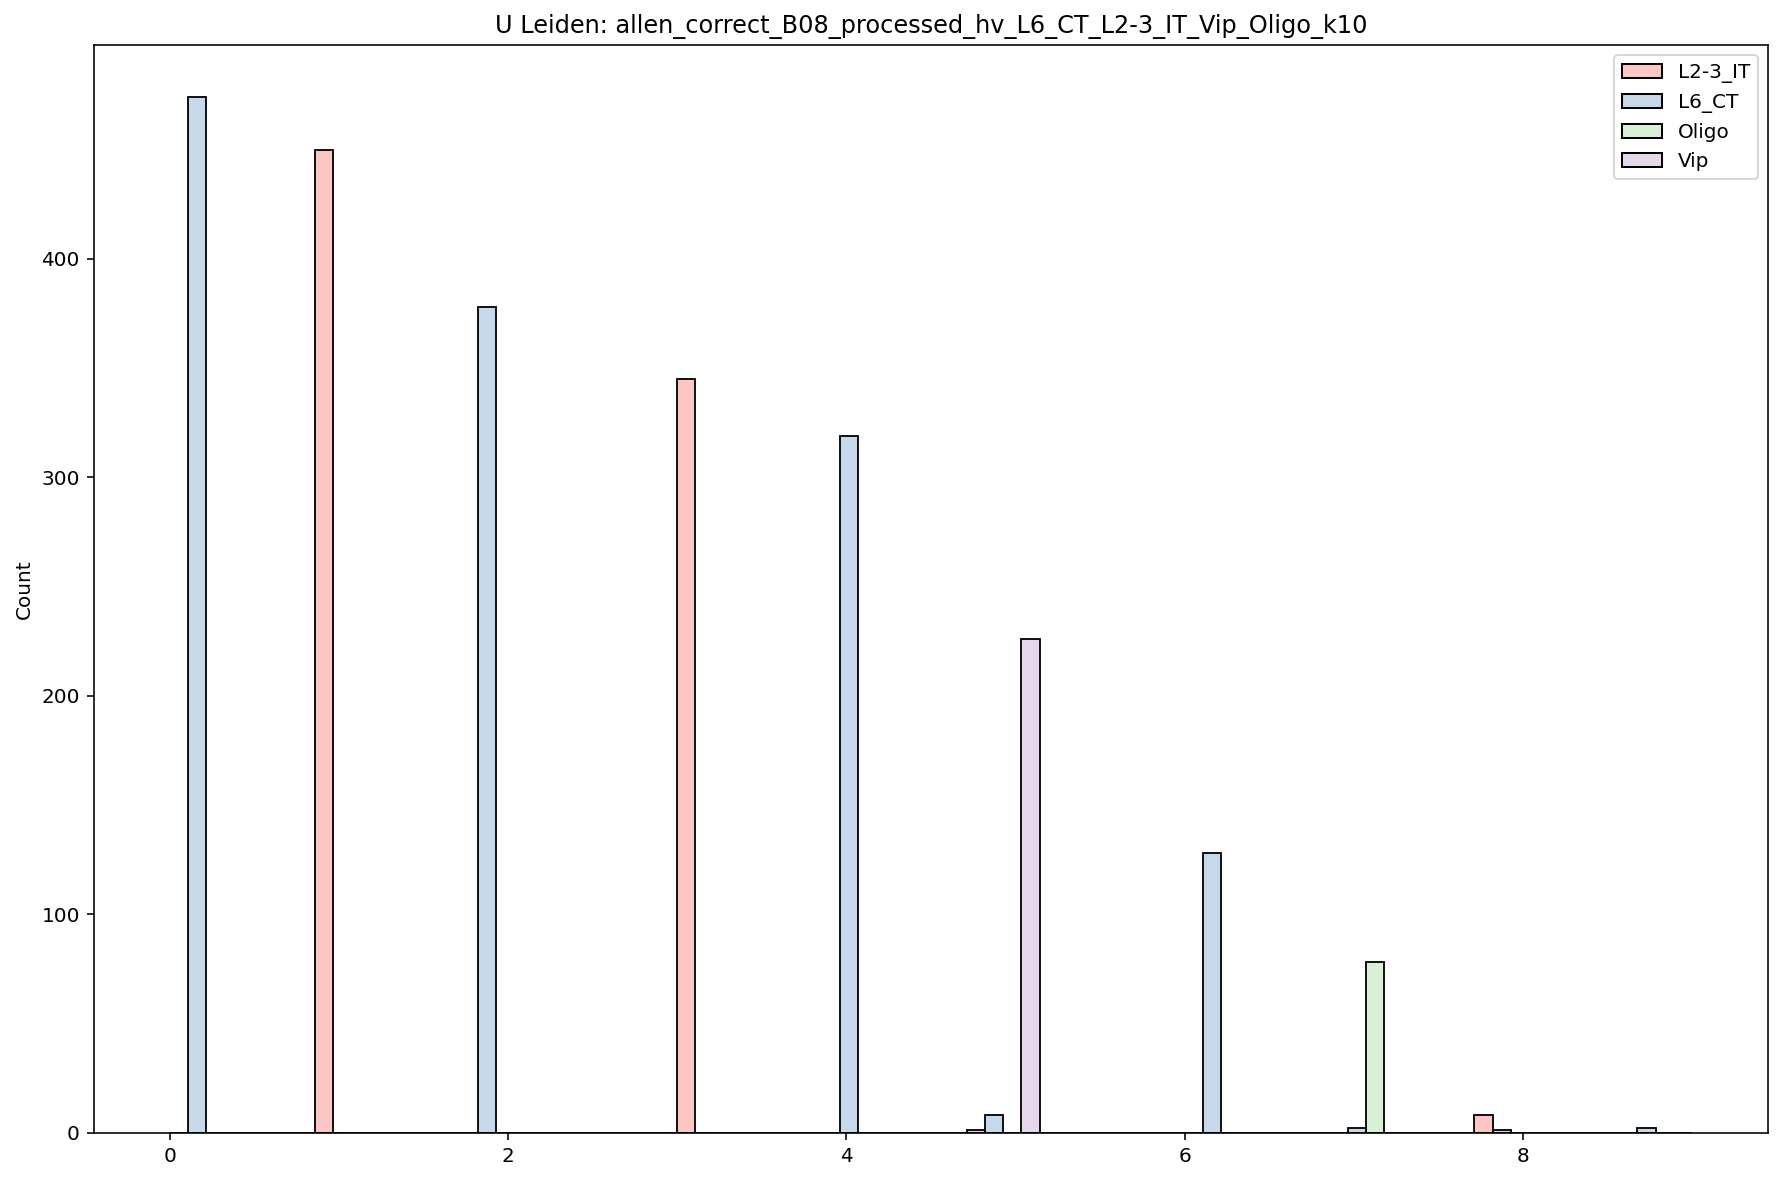

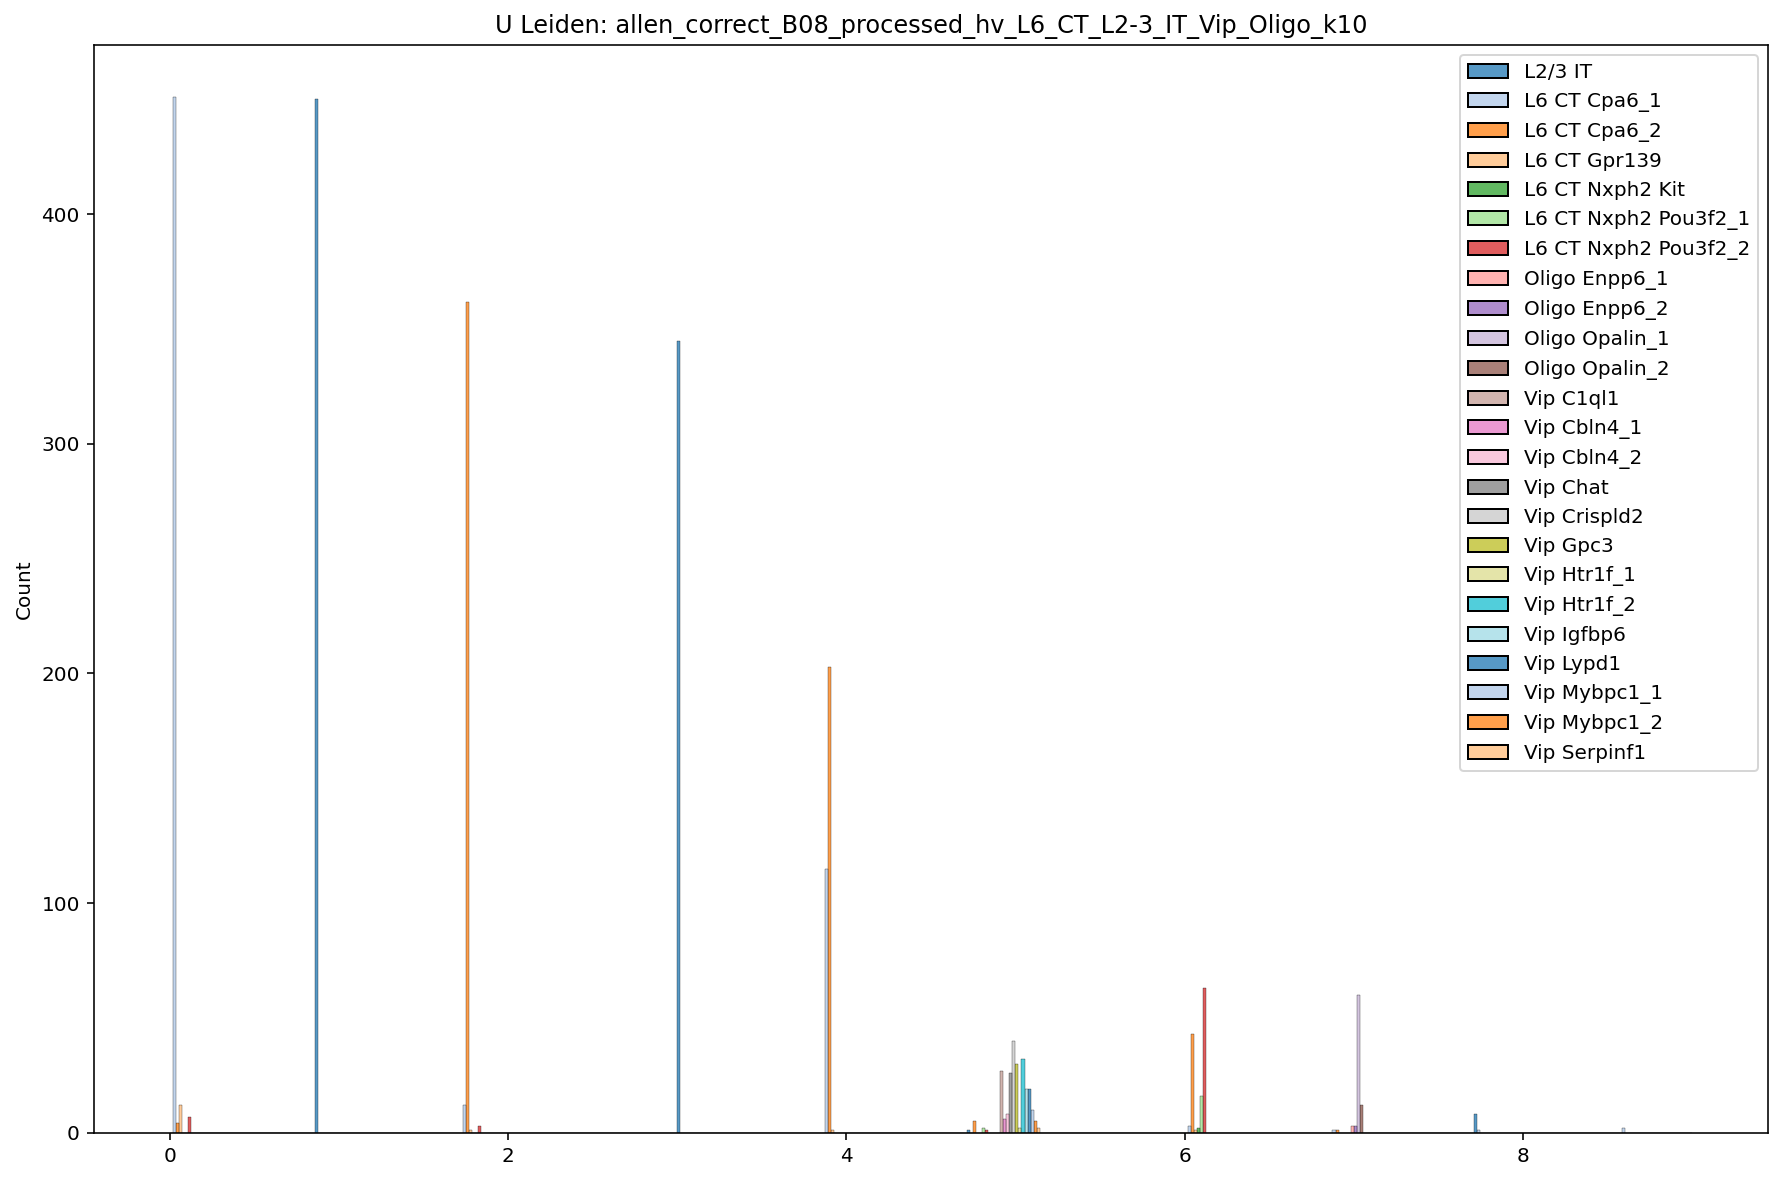

In [130]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    S = search_data.layers[0,:,:]
    S_t = S.T
    tots = np.sum(S_t,axis=1)
    divids = (1e4/tots)[:,None]
    S_t = S_t*divids
    S_t = np.log1p(S_t)

    A = kneighbors_graph(S_t, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[i])
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('U Leiden: '+dataset_names[which])
    
    
    
    


INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2000 features observed, 1

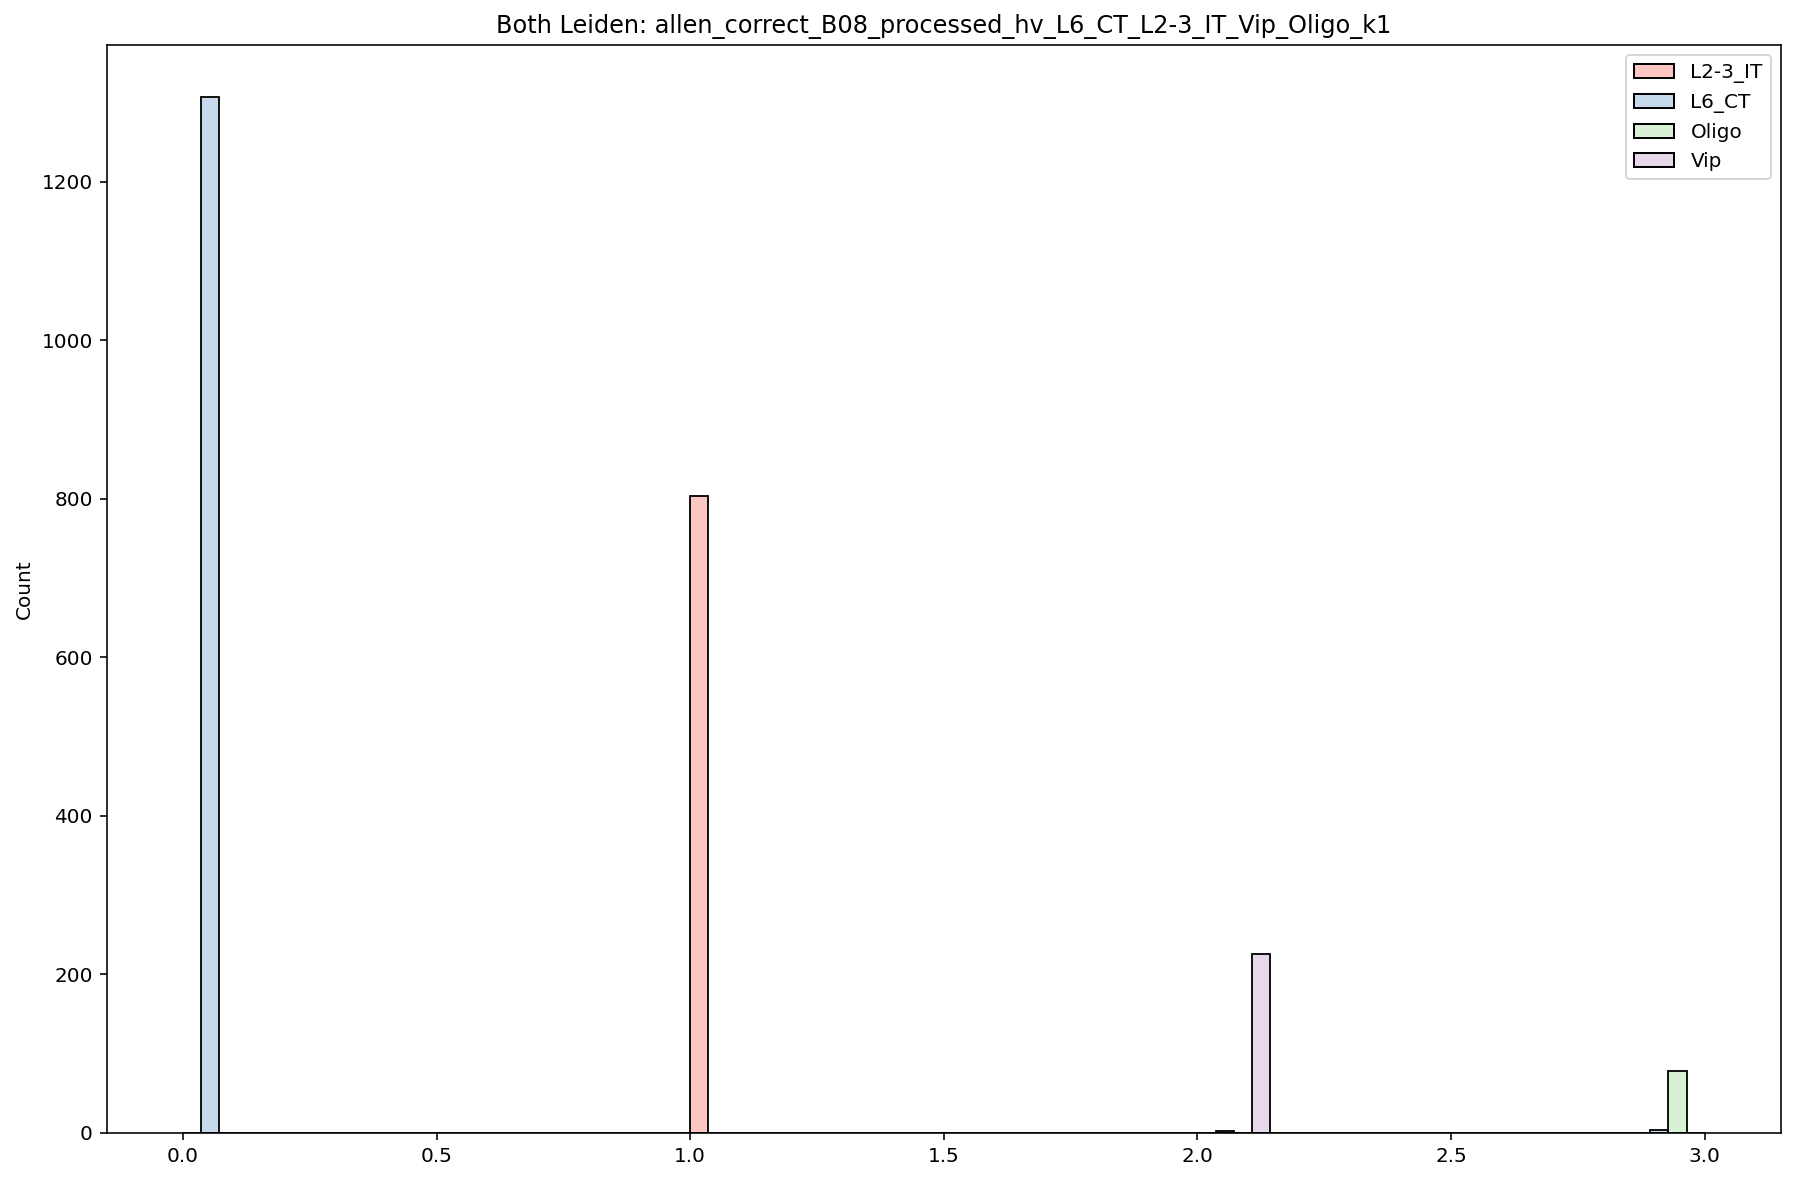

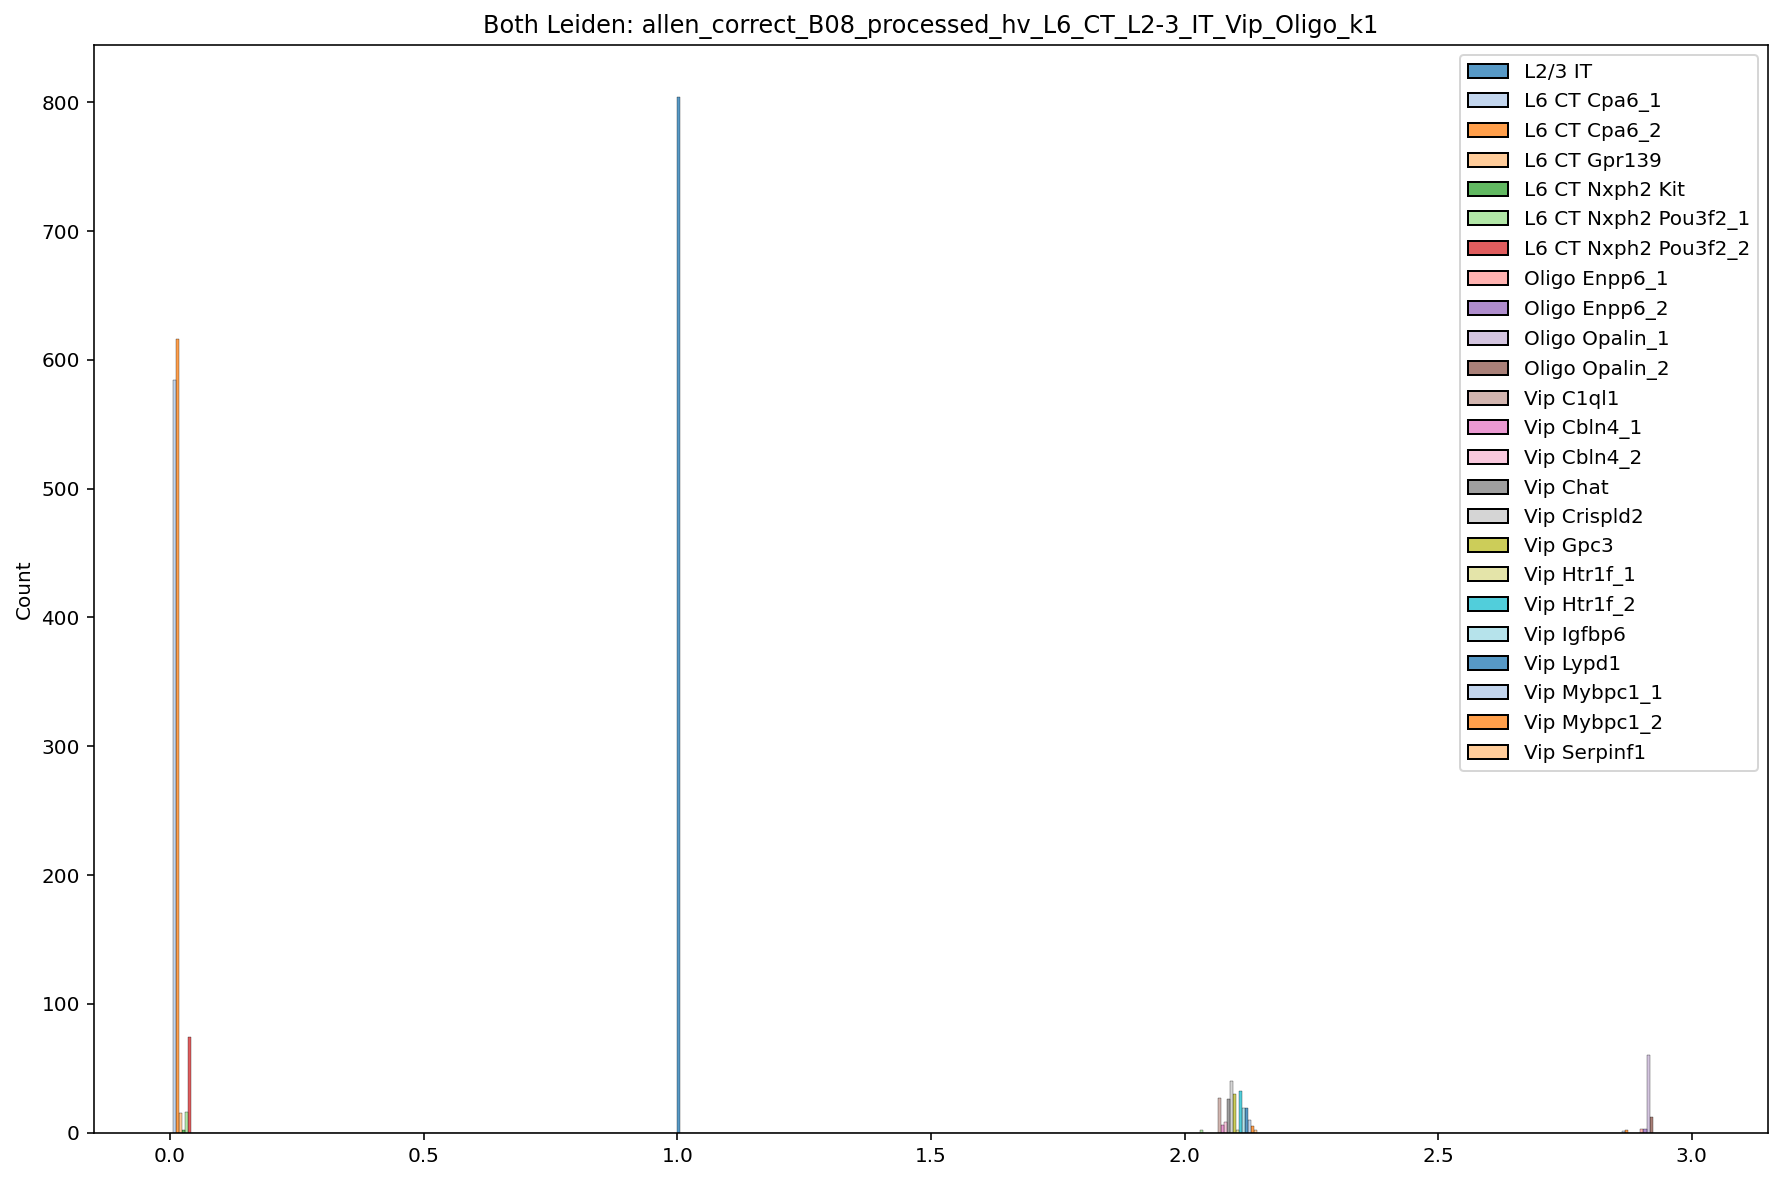

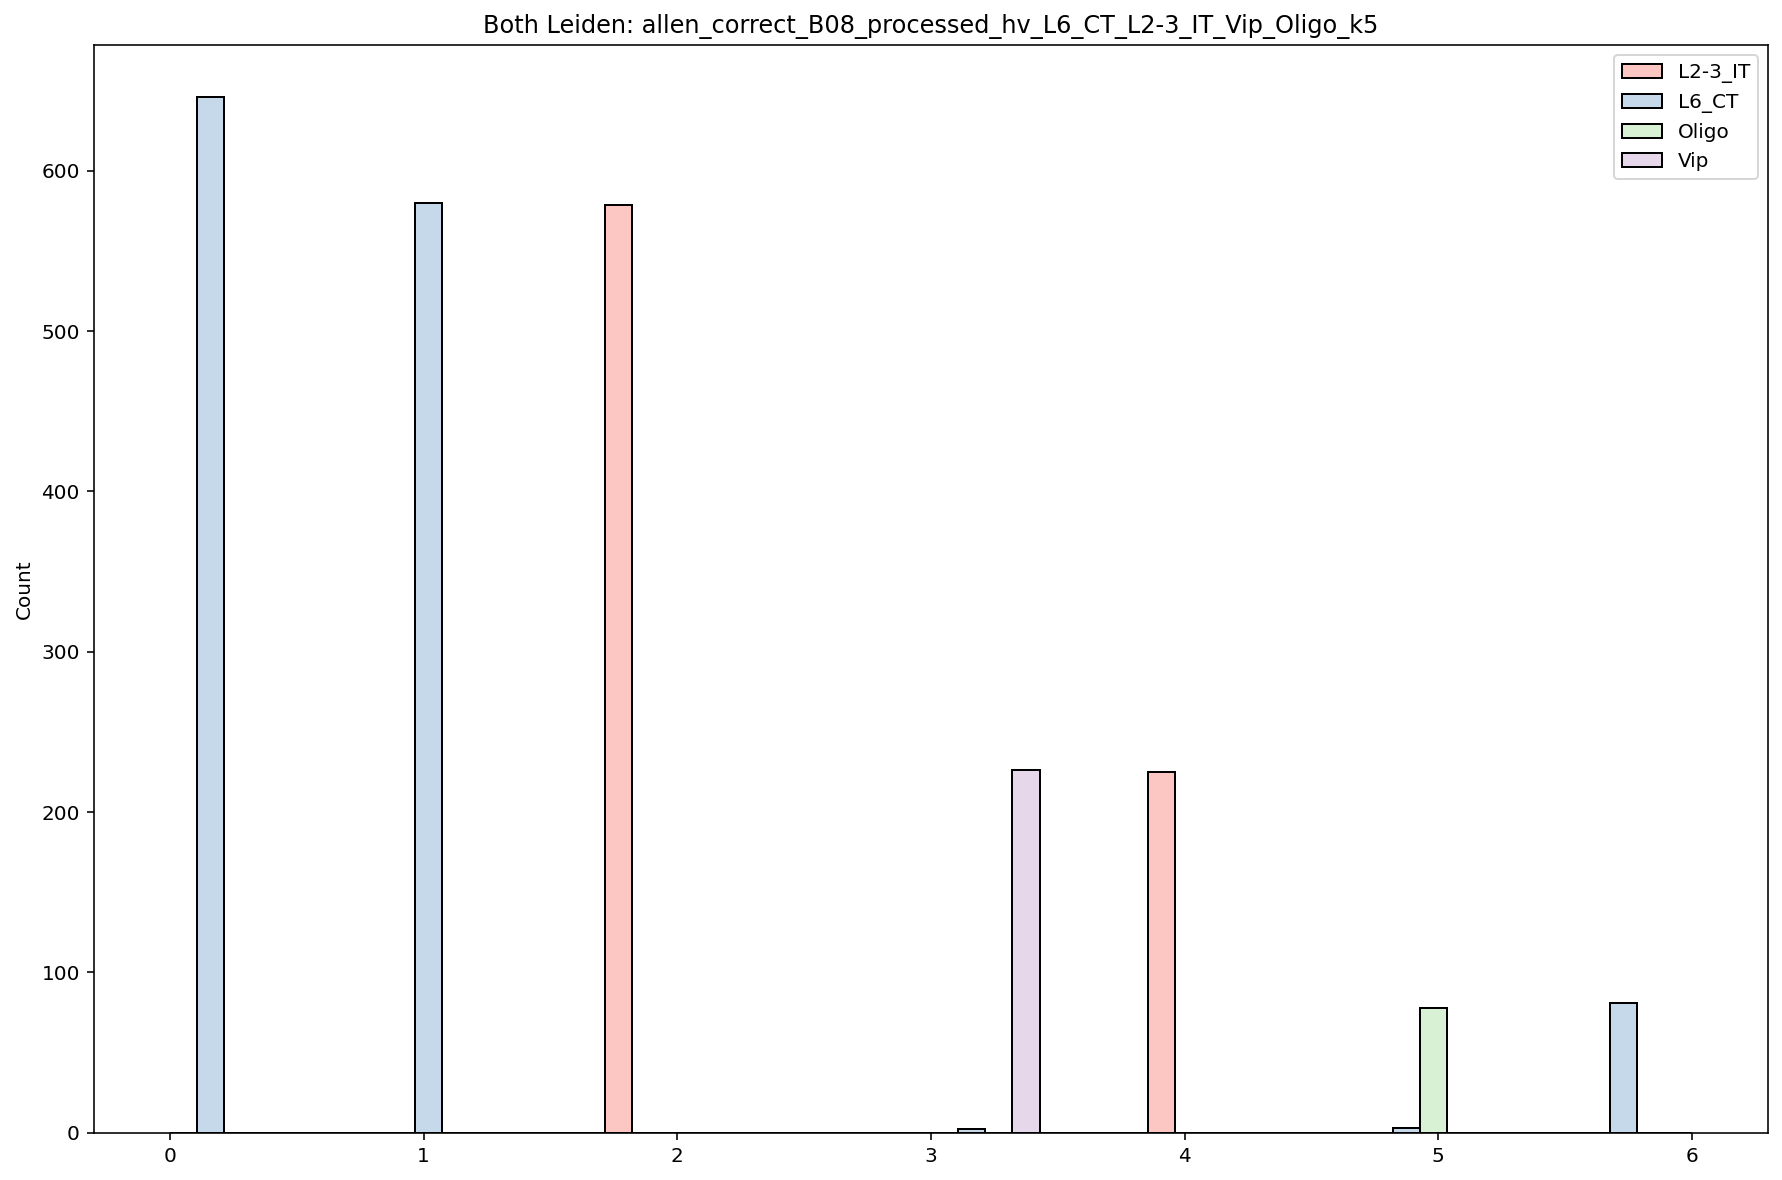

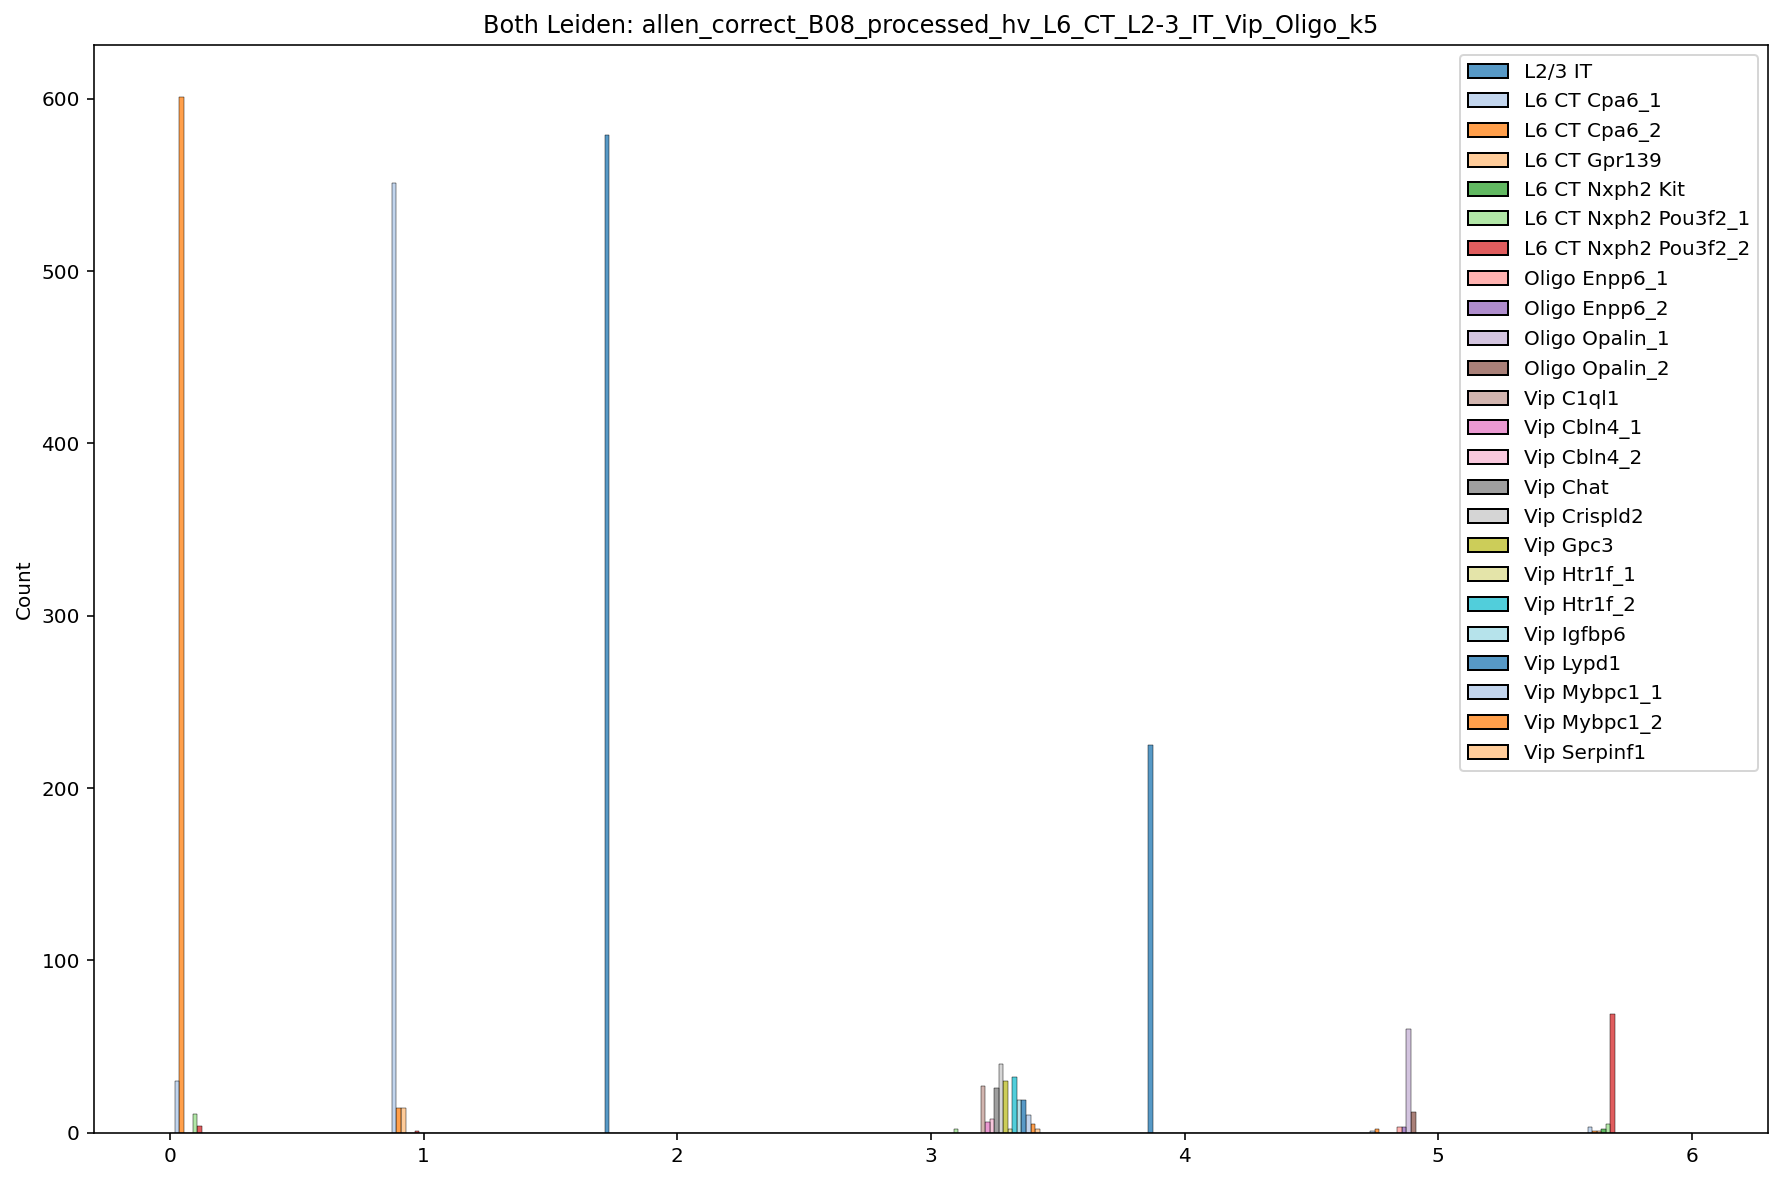

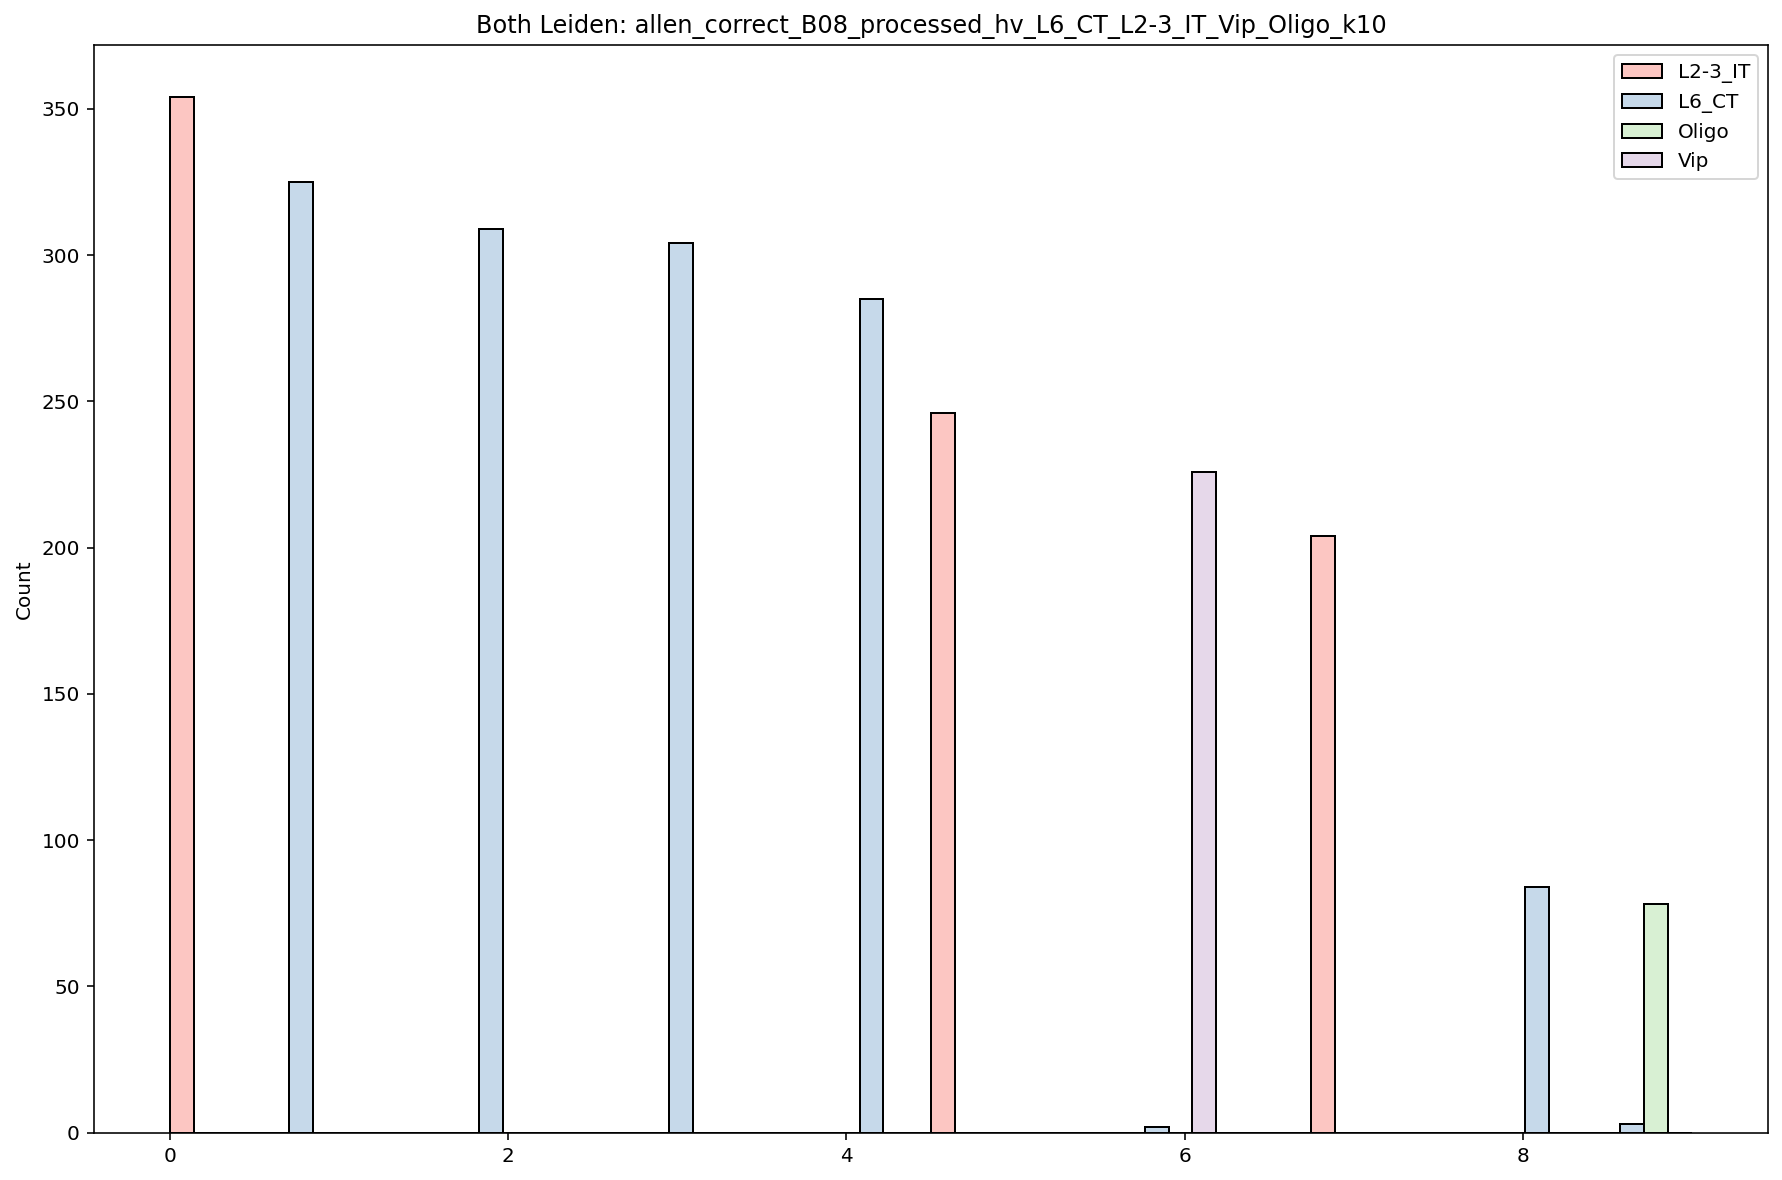

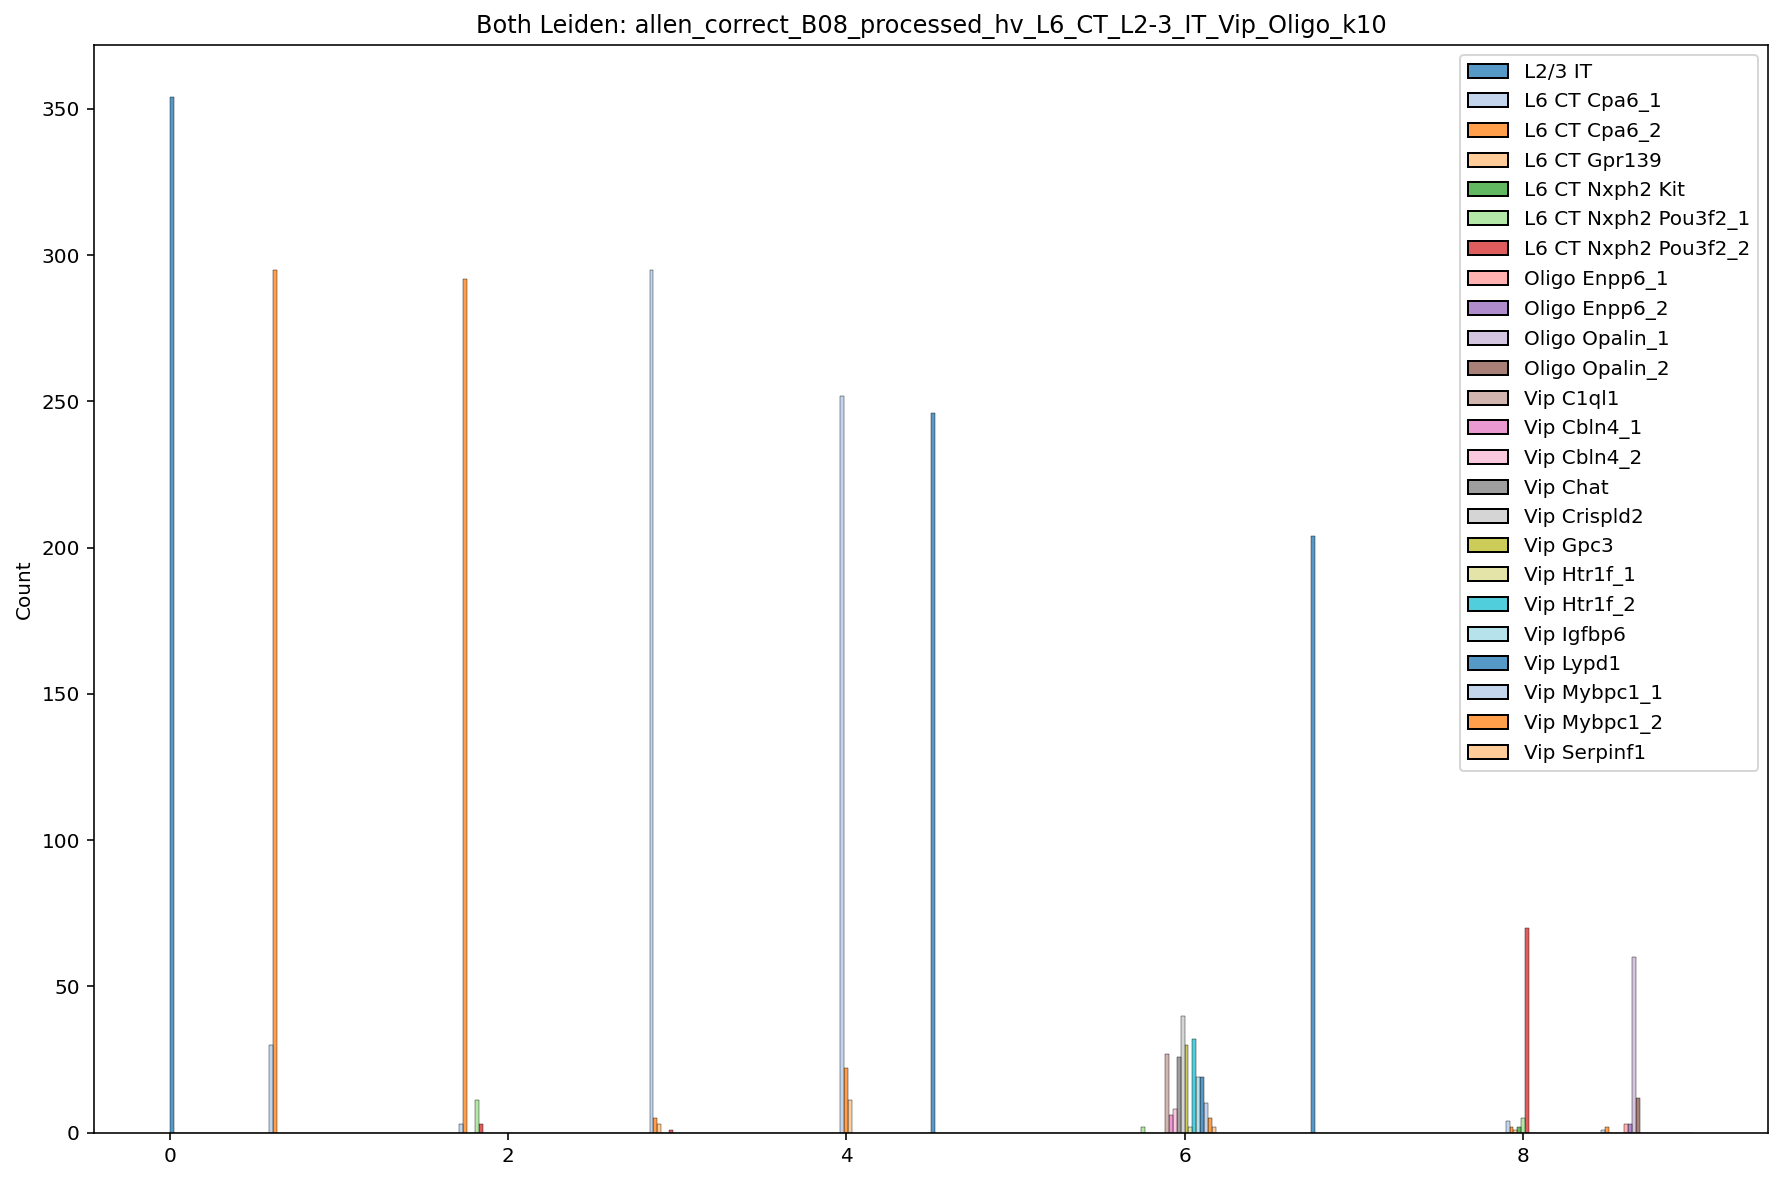

In [131]:
#From https://github.com/scverse/scanpy/blob/ed3b277b2f498e3cab04c9416aaddf97eec8c3e2/scanpy/tools/_leiden.py#L24-L177
for i in range(len(chosen)*num_ks):
    which = i
    search_data = monod.extract_data.extract_data(loom_filepaths[which], transcriptome_filepath, dataset_names[which],
                dataset_strings[which], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[which])
    #Spliced
    U = search_data.layers[0,:,:]
    U_t = U.T
    S = search_data.layers[1,:,:]
    S_t = S.T
    
    concat = np.concatenate((U_t, S_t), axis=1)

    tots = np.sum(concat,axis=1)
    divids = (1e4/tots)[:,None]
    concat = concat*divids
    concat = np.log1p(concat)

    A = kneighbors_graph(concat, neigh, mode='connectivity', include_self=True)
    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix):
        weights = weights.A1
    g = ig.Graph(directed=False) #True in scanpy, which is odd
    g.add_vertices(A.shape[0])  # this adds adjacency.shape[0] vertices
    g.add_edges(list(zip(sources, targets)))

    g.es['weight'] = weights
    
    partition_type = la.RBConfigurationVertexPartition
    
    
    part = la.find_partition(g, partition_type, 
                                    weights=np.array(g.es['weight']).astype(np.float64), 
                                    n_iterations=-1, resolution_parameter=res[i%num_ks])

    all_groups += [np.array(part.membership)]
    
    labels = np.array(part.membership)
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(assigns[which]), kde=False,palette='Pastel1',multiple="dodge")
    plt.title('Both Leiden: '+dataset_names[i])
    
    plt.figure(figsize=(15,10))
    sns.histplot(x=labels,hue=pd.Categorical(all_sub_assigns[which]), kde=False,palette='tab20',multiple="dodge")
    plt.title('Both Leiden: '+dataset_names[which])
    
    
    
    


In [132]:
len(all_groups)

9

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

(7, 7)
(7, 7)


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see ht

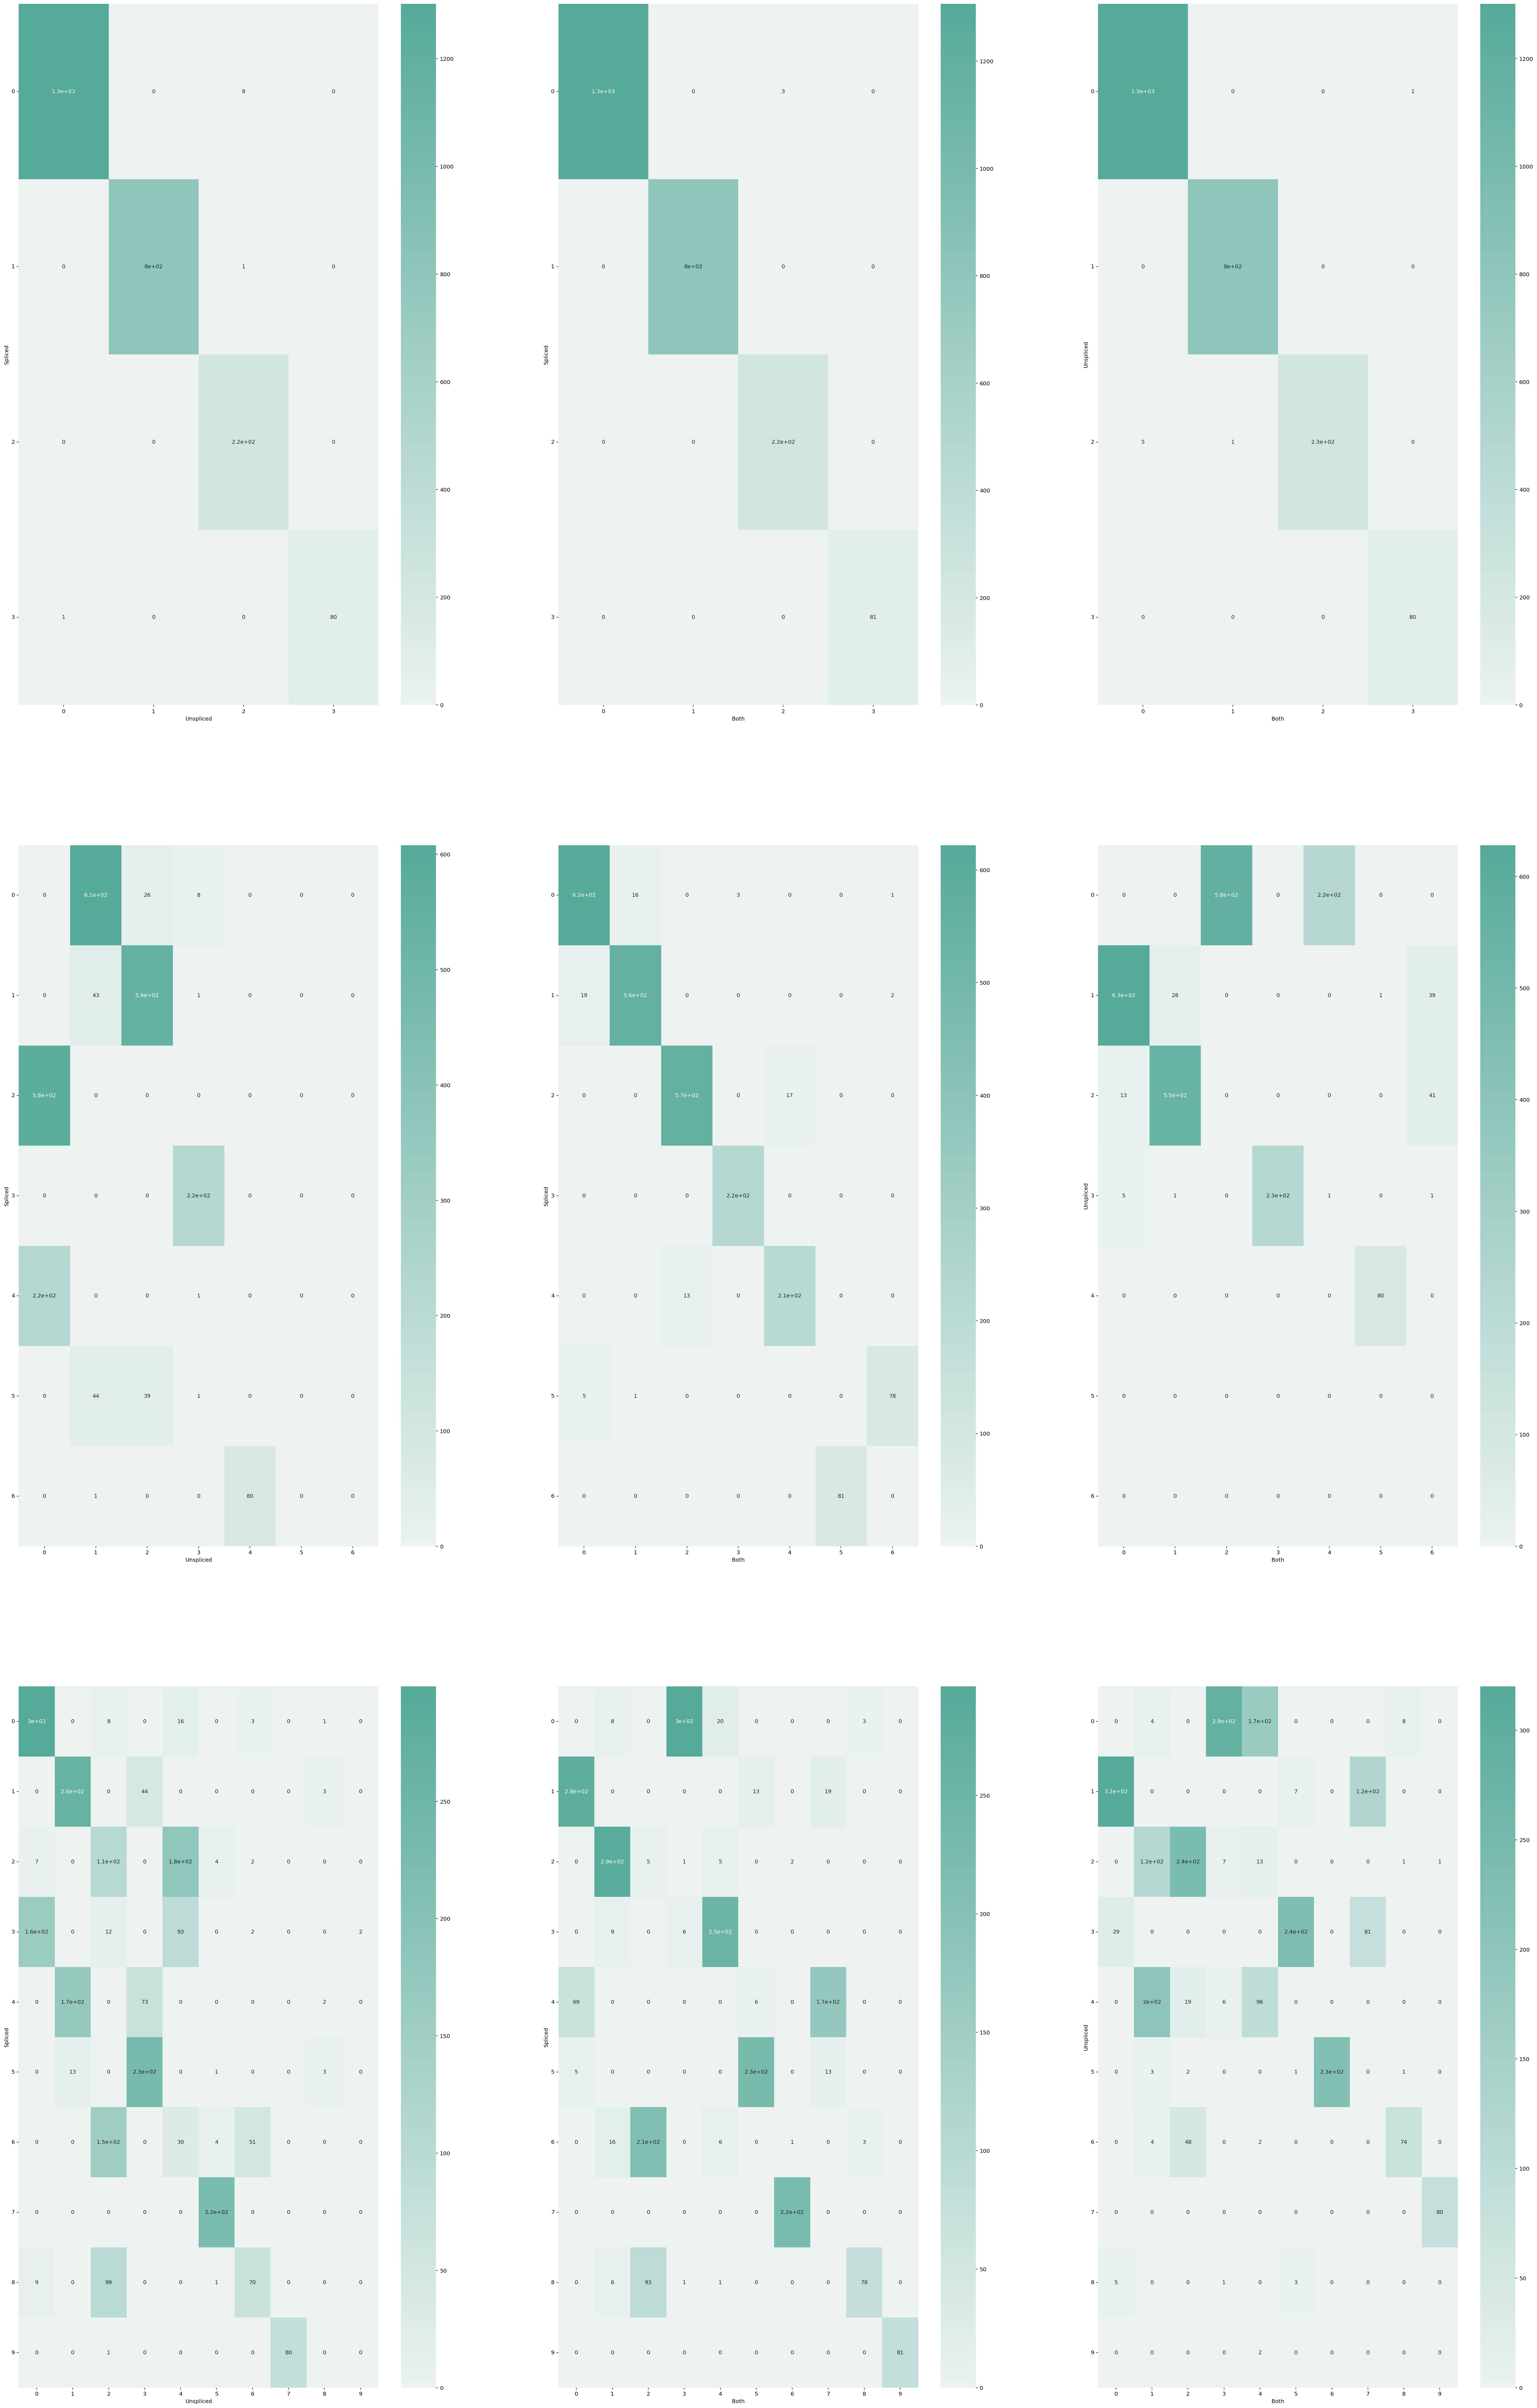

In [133]:
#compare overlap of all k-means assignments

num_per_set = len(chosen)*num_ks

pairs = [(0,1),(0,2),(1,2)]
labs = [('Spliced','Unspliced'),('Spliced','Both'),('Unspliced','Both')]
#Plot confmats
fig, ax = plt.subplots(nrows=num_per_set, ncols=len(pairs), figsize=(50,80))
    
for i in range(0,num_per_set):
    
    for j in range(len(pairs)):
        
        p = pairs[j]
        
        assign = all_groups[p[1]*(num_per_set)+i]
        true = all_groups[p[0]*(num_per_set)+i]

        true_copy = list(true)
        assign_copy = list(assign)

        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    true_copy += [a]
                    assign_copy += [a]


        conmat = confusion_matrix(true_copy, assign_copy)
        val = np.mat(conmat) 
        classnames = list(set(true_copy))
        df_cm = pd.DataFrame(

                val, index=classnames, columns=classnames, 

            )


        if np.max(assign) > np.max(true): #FIX
            for a in np.unique(assign):
                if a > np.max(true):
                    print(df_cm.shape)
                    df_cm.loc[a,a] = df_cm.loc[a,a]-1


        heatmap = sns.heatmap(df_cm, annot=True, 
                              cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[i,j])
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)

        ax[i,j].set_ylabel(labs[j][0])
        ax[i,j].set_xlabel(labs[j][1])

    
plt.show()

## **Run MM/Monod Inference**

v----------- Only Run Once -----------v

In [134]:
#Define bounds, 
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-9, -4] #-7.5, -2
samp_ub = [-4, 1.5] #-5.5, 0
# gridsize = [5,6]
gridsize = [10,11]


In [135]:
dataset_names

['allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k1',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5',
 'allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10',
 'allen_correct_B08_processed_hv_L6_CT',
 'allen_correct_B08_processed_hv_L2-3_IT',
 'allen_correct_B08_processed_hv_Vip',
 'allen_correct_B08_processed_hv_Oligo']

In [136]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-4,len(dataset_names)): #MAYBE RERUN???

    fitmodel = monod.cme_toolbox.CMEModel('Bursty',"Poisson") #'Poisson'

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string,viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)

INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [11:38<00:00,  6.35s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 699.8 seconds.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L2-3_IT
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.
INFO:root:Starting parallelized

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [13:15<00:00,  7.23s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 796.7 seconds.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [14:51<00:00,  8.10s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 892.0 seconds.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo/Bursty_Poisson_10x11 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo/Bursty_Poisson_10x11/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Oligo
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo/raw.sd.
INFO:root:Starting parallelized grid scan

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [1:09:30<00:00, 37.92s/it]


INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo/Bursty_Poisson_10x11/analysis_figures already exists.
INFO:root:Runtime: 4172.1 seconds.


In [137]:
result_strings = [i+'/Bursty_Poisson_10x11/grid_scan_results.res' for i in dataset_strings[(len(dataset_names)-4):(len(dataset_names))]]


INFO:root:Grid scan results loaded from ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_10x11/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_Oligo/Bursty_Poisson_10x11/grid_scan_results.res.
-7.333333333333333 -1.25
-7.888888888888889 -2.9
-7.888888888888889 -2.9
-6.777777777777778 -1.25


Text(0, 0.5, '$\\log_{10} \\lambda_M$')

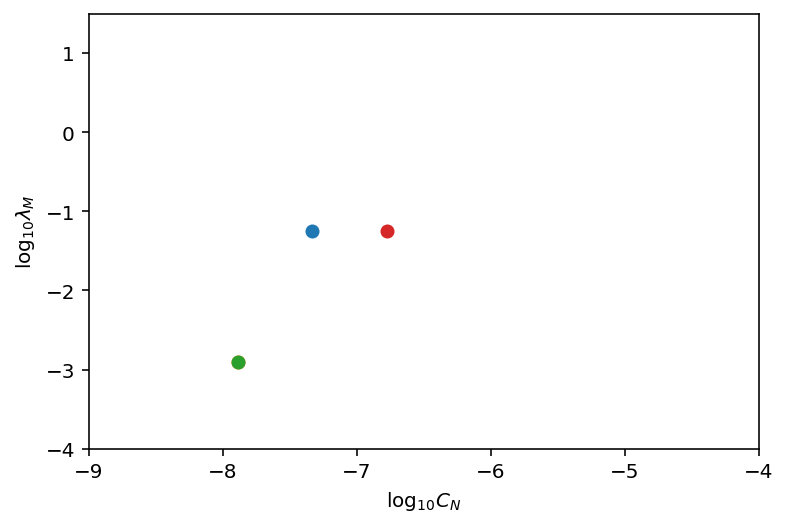

In [138]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
plt.figure()
for r in sr:
    r.find_sampling_optimum()
    plt.scatter(r.samp_optimum[0],r.samp_optimum[1])
    print(r.samp_optimum[0],r.samp_optimum[1])
    
plt.xlim([-9,-4])
plt.ylim([-4,1.5])

plt.xlabel(r'$\log_{10} C_N$')
plt.ylabel(r'$\log_{10} \lambda_M$')

In [139]:
#Find closest technical param in grid, to centroid of technical params on plot
arbitrary_params = np.asarray([-7.3,-1]) #-8,-2.5
arbitrary_ind = np.argmin(((sr[0].sp.sampl_vals-arbitrary_params)**2).sum(1))
arbitrary_pars = sr[0].sp.sampl_vals[arbitrary_ind]
print(arbitrary_pars)
print(arbitrary_ind)

(-7.333333333333333, -1.25)
38


^----------- Only Run Once -----------^

In [146]:
#Define bounds, choose 'centroid'
phys_lb = [-2.0, -1.8, -1.8 ] #-1.0, -1.8, -1.8
phys_ub = [4.2, 2.5, 2.5] #4.2, 2.5, 3.5
samp_lb = [-7.888888888888889, -2.9] #-7.333333, -1.25
samp_ub = [-7.888888888888889, -2.9] #-7.333333, -1.25
# gridsize = [5,6]
gridsize = [1,1]


In [372]:
#Run Monod as control on separate groups
result_strings = []
#for i in range(1,2): #n_datasets
for i in range(len(dataset_names)-4,len(dataset_names)):

    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')

    inference_parameters = monod.inference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})

    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])

    full_result_string = inference_parameters.fit_all_grid_points(30,search_data)

    result_strings.append(full_result_string)
    

INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Vip
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:48<00:00, 48.82s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 49.6 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_Lamp5


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:17<00:00, 77.40s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 78.1 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L5-6_NP


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.71s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 31.5 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:59<00:00, 59.59s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 60.5 seconds.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L2-3_IT


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230423_025_allen_B08_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.
INFO:root:Starting parallelized grid scan.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:04<00:00, 64.01s/it]

INFO:root:Parallelized grid scan complete.
INFO:root:All grid point data cleaned from disk.
INFO:root:Directory ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/analysis_figures already exists.
INFO:root:Runtime: 64.8 seconds.


In [373]:
result_strings = [i+'/Bursty_Poisson_1x1/grid_scan_results.res' for i in dataset_strings[len(dataset_names)-6:len(dataset_names)-1]]


In [374]:
sr = [monod.analysis.load_search_results(i) for i in result_strings]
sr

INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/Bursty_Poisson_1x1/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/Bursty_Poisson_1x1/grid_scan_results.res.


In [454]:
#Raw ds files (with spliced/unspliced counts)
raws = [i+'/raw.sd' for i in dataset_strings[len(dataset_names)-6:-1]] #0:len(chosen)*num_ks
sd = [monod.analysis.load_search_data(i) for i in raws]
sd

INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Vip/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_Lamp5/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L5-6_NP/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L6_CT/raw.sd.
INFO:root:Search data loaded from ./fits/gg_230423_025_allen_B08_MM_1/allen_correct_B08_processed_hv_L2-3_IT/raw.sd.


**Mixture Model**

In [147]:
epochs = 20

In [150]:
result_strings = []
for i in range(len(chosen)*num_ks -1,0,-1): #rlen(chosen)*num_ks
    
    fitmodel = monod.cme_toolbox.CMEModel('Bursty','Poisson')
    
    inference_parameters = monod.mminference.InferenceParameters(phys_lb,phys_ub,samp_lb,samp_ub,gridsize,\
                dataset_strings[i],fitmodel,k=ks[i%num_ks],epochs=epochs,use_lengths = True,
                gradient_params = {'max_iterations':20,'init_pattern':'moments','num_restarts':1})
    
    search_data = monod.extract_data.extract_data(loom_filepaths[i], transcriptome_filepath, dataset_names[i],
                dataset_strings[i], dir_string, viz=False, dataset_attr_names=attribute_names,cf=cf[i])
    
    inference_parameters.fit_all_grid_points(30,search_data)


INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10/Bursty_Poisson_1x1 created.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10
INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k10/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:59<00:00, 47.97s/it]


INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [13:16<00:00, 79.68s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.00245306 0.03668106 0.24508069 0.01445426 0.16590369 0.12804267
 0.1059016  0.1815299  0.0355268  0.08442626]
Q Function:  -3405562.2415079908

INFO:root:EM Epoch 2/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [07:31<00:00, 50.20s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 8.26446421e-04 1.66787811e-01 1.65289297e-03
 1.51425311e-01 1.78739978e-01 4.39873673e-02 3.27654552e-01
 3.34710747e-02 9.54545669e-02]
Q Function:  -3216679.629575236

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:03<00:00, 45.40s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 1.72720435e-01 1.23966983e-03
 1.49069722e-01 1.82335236e-01 2.89443616e-03 3.62814880e-01
 3.34710747e-02 9.54545455e-02]
Q Function:  -3199818.636633803

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [09:41<00:00, 96.98s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 1.77010531e-01 4.13223139e-10
 1.37809301e-01 1.93595657e-01 4.13223139e-10 3.61419219e-01
 3.34710747e-02 9.66942149e-02]
Q Function:  -3197113.2212673826

INFO:root:EM Epoch 5/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [07:41<00:00, 76.87s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 1.37115646e-01 4.13223139e-10
 2.04004617e-01 1.27400341e-01 4.13223139e-10 4.01727328e-01
 3.34710747e-02 9.62809918e-02]
Q Function:  -3207250.9195037205

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:50<00:00, 58.45s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 7.57315374e-02 4.13223139e-10
 2.75165665e-01 5.58260685e-02 4.13223139e-10 4.63111438e-01
 3.34710747e-02 9.66942148e-02]
Q Function:  -3203941.433381556

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:50<00:00, 82.13s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 2.72578643e-03 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.36117187e-01
 3.34710747e-02 9.58677686e-02]
Q Function:  -3189714.3488906315

INFO:root:EM Epoch 8/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [10:02<00:00, 150.59s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38431448e-01
 3.34710747e-02 9.62792944e-02]
Q Function:  -3158090.93431676

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:14<00:00, 93.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842973e-01
 3.34710747e-02 9.58677686e-02]
Q Function:  -3146872.6710993676

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:51<00:00, 87.76s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.8381840154

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:40<00:00, 130.01s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [08:32<00:00, 128.04s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:54<00:00, 88.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:21<00:00, 110.35s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:26<00:00, 111.65s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 16/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:34<00:00, 98.58s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:38<00:00, 114.60s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 18/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:02<00:00, 90.70s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:21<00:00, 110.36s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:55<00:00, 103.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [4.13223139e-10 4.13223139e-10 4.13223139e-10 4.13223139e-10
 3.31818181e-01 4.13223139e-10 4.13223139e-10 5.38842958e-01
 3.34710747e-02 9.58677835e-02]
Q Function:  -3127010.838184016

INFO:root:Non-parallelized grid scan complete.
INFO:root:Directory ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/Bursty_Poisson_1x1 already exists.
INFO:root:Global inference parameters stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/Bursty_Poisson_1x1/parameters.pr.
INFO:root:Beginning data extraction.
INFO:root:Dataset: allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5


INFO:root:2000 features observed, 1990 match genome annotations. 1978 were unique.
INFO:root:Gene list extracted from ./fits/gg_230503_025_allen_B08_sizes_MM_1/genes.csv.
INFO:root:Search data stored to ./fits/gg_230503_025_allen_B08_sizes_MM_1/allen_correct_B08_processed_hv_L6_CT_L2-3_IT_Vip_Oligo_k5/raw.sd.
INFO:root:Starting non-parallelized grid scan.
INFO:root:M Step Initial Run: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:45<00:00, 69.14s/it]

INFO:root:Parallelized MLE fits complete.
INFO:root:EM Epoch 1/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [12:26<00:00, 149.28s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.32902336 0.48307454 0.03471338 0.05494185 0.09824687]
Q Function:  -3192120.043726635

INFO:root:EM Epoch 2/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:39<00:00, 67.83s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [0.33181818 0.53298895 0.03347107 0.00502819 0.09669361]
Q Function:  -3191526.7125810646

INFO:root:EM Epoch 3/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:01<00:00, 105.26s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38588628e-01 3.34710747e-02 4.13223140e-10
 9.61221152e-02]
Q Function:  -3196692.736342946

INFO:root:EM Epoch 4/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:31<00:00, 82.97s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690906e-01 3.34710747e-02 4.13223140e-10
 9.60198371e-02]
Q Function:  -3156057.296403944

INFO:root:EM Epoch 5/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:02<00:00, 105.50s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844986163

INFO:root:EM Epoch 6/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:35<00:00, 83.89s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.2974705077

INFO:root:EM Epoch 7/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:50<00:00, 87.52s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 8/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:36<00:00, 99.07s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 9/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:34<00:00, 83.66s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 10/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:11<00:00, 107.79s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 11/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:46<00:00, 86.56s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 12/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:14<00:00, 93.53s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 13/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:24<00:00, 96.14s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 14/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:35<00:00, 83.95s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 15/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:19<00:00, 94.95s/it]


INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 16/20: 
INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:01<00:00, 105.30s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 17/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:36<00:00, 84.10s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 18/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [05:36<00:00, 84.16s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:EM Epoch 19/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [07:31<00:00, 112.96s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38433371e-01 3.34710747e-02 4.13223140e-10
 9.62773724e-02]
Q Function:  -3133363.844984673

INFO:root:EM Epoch 20/20: 


INFO:root:Starting parallelized MLE param fits for EM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [06:06<00:00, 91.60s/it]

INFO:root:Parallelized MLE fits complete.
mstep self.weights:  [3.31818182e-01 5.38690723e-01 3.34710747e-02 4.13223140e-10
 9.60200199e-02]
Q Function:  -3156057.297470508

INFO:root:Non-parallelized grid scan complete.


## **Analysis of Results**

In [151]:
#Plot cluster concordance with true labels and distribution of clusters 
#Maybe also return true_dict?
def vis_assign(true,assign,title='',figsize=(18, 5)):
    true_dict = dict(zip(np.unique(list(true)),range(len(np.unique(list(true))))))
    true = [true_dict[x] for x in true]                
    
    true_copy = list(true)

    
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): #FIX
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1

    #Plot assignment distributions
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    sns.histplot(x=assign,hue=true, kde=False,ax=ax[0],palette='Pastel1',multiple="dodge")
    ax[0].set_xlabel('MM Assignment')
    ax[0].set_title(title)
    
    #Plot confustion matrix
    heatmap = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("light:#5A9", as_cmap=True),ax=ax[1])
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0)
    ax[1].set_ylabel('Original label')
    ax[1].set_xlabel('Assigned label')
    
    
    plt.show()

    

In [152]:
#Plot  aics and loss over time for each k iteration

def vis_metrics(results,title,ks,figsize=(18, 5),s=50):
    num_ks = len(results)
    sets = []
    nlls = []
    res = pd.DataFrame()
    aics = pd.DataFrame()
    klds = pd.DataFrame()
    
    aic = []
    fin_k = []
    kls = []
    
    epoch = len(results[0].all_qs)
    epos = list(range(1,epoch+1))*num_ks
    
    for i in range(num_ks):
        
        nlls += list(-1*np.array(results[i].all_qs))
        sets += [ks[i]]*epoch
        aic += [results[i].aic] #-2*n_cells*clus
        fin_k += [len(np.unique(results[i].assigns))]
        #kls += [np.mean([np.mean(results[i].klds[:,k]) for k in np.unique(results[i].assigns)])]
        
        kls += list(np.mean(np.sum(np.array(results[i].all_klds)[:,:,list(np.unique(results[i].assigns))],axis=1),axis=1))
        
        
    
    
    
    res['NLL'] = nlls
    res['KLD'] = kls
    res['epoch'] = epos
    res['setting'] = ['k='+str(j) for j in sets]
    
    aics['AIC'] = aic
    aics['k'] = [str(j) for j in ks ]
    aics['fin_k'] = fin_k
    

    
    
    #Plot klds over time
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    sns.lineplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='NLL',hue='setting', 
                    ax=ax[0],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('NLL')
    ax[0].set_title(title)
    
    
    #Plot klds
    sns.lineplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',
                   alpha=0.7,legend=False)
    sns.scatterplot(data=res,x='epoch',y='KLD',hue='setting', 
                    ax=ax[1],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('KLD')

    
    
    #Plot aics
    sns.scatterplot(data=aics,x='fin_k',y='AIC',hue='k', ax=ax[2],palette='Dark2',s=s,
                   alpha=0.7,edgecolor='black')
    ax[2].set_xlabel('Final k')
    ax[2].set_ylabel('-AIC')
    ax[2].legend(
          title='k')
    
    
 
    plt.show()
    
    
    


### **Read in Results**

In [153]:
#Mixture Model results
import pickle 
results = [i+'/Bursty_Poisson_1x1/grid_point_0.gp' for i in dataset_strings[0:len(chosen)*num_ks]] #0:len(chosen)*num_ks
grid_point_results = []
for r in results:
    with open(r, "rb") as ipfs:
        grid_point_results += [pickle.load(ipfs)]

    

In [154]:
assign_dict = dict(zip(np.unique(list(assigns[0])),range(len(np.unique(list(assigns[0]))))))
new_assigns = [assign_dict[x] for x in assigns[0]]


print(assign_dict)


{'L2-3_IT': 0, 'L6_CT': 1, 'Oligo': 2, 'Vip': 3}


In [155]:
all_new_assigns = [new_assigns]*num_ks

### **Plot Cluster Assignment and Loss**

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


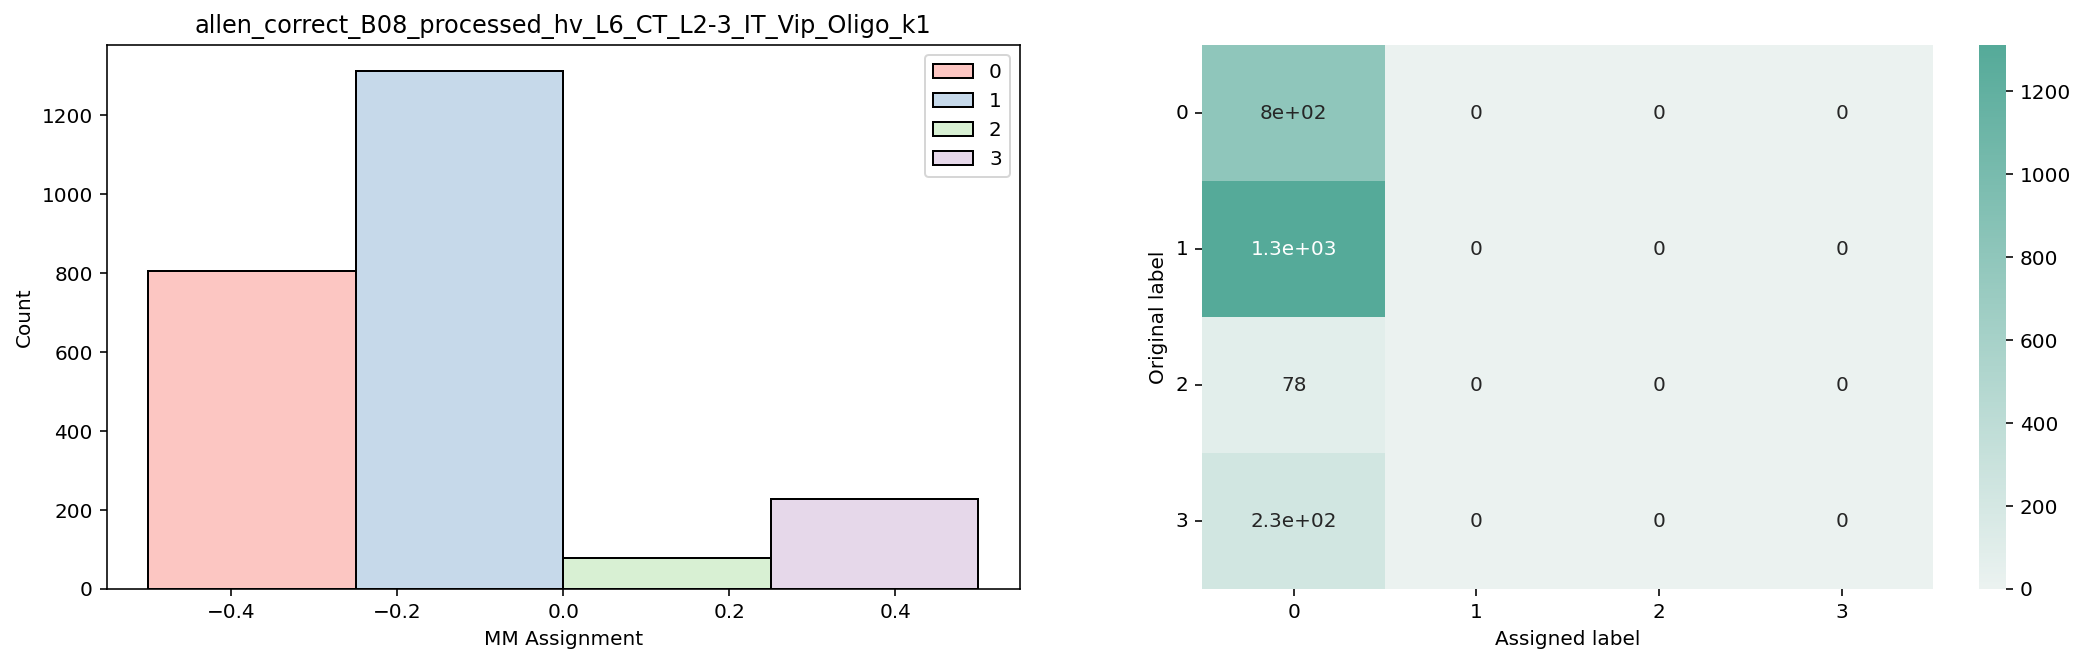

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(5, 5)


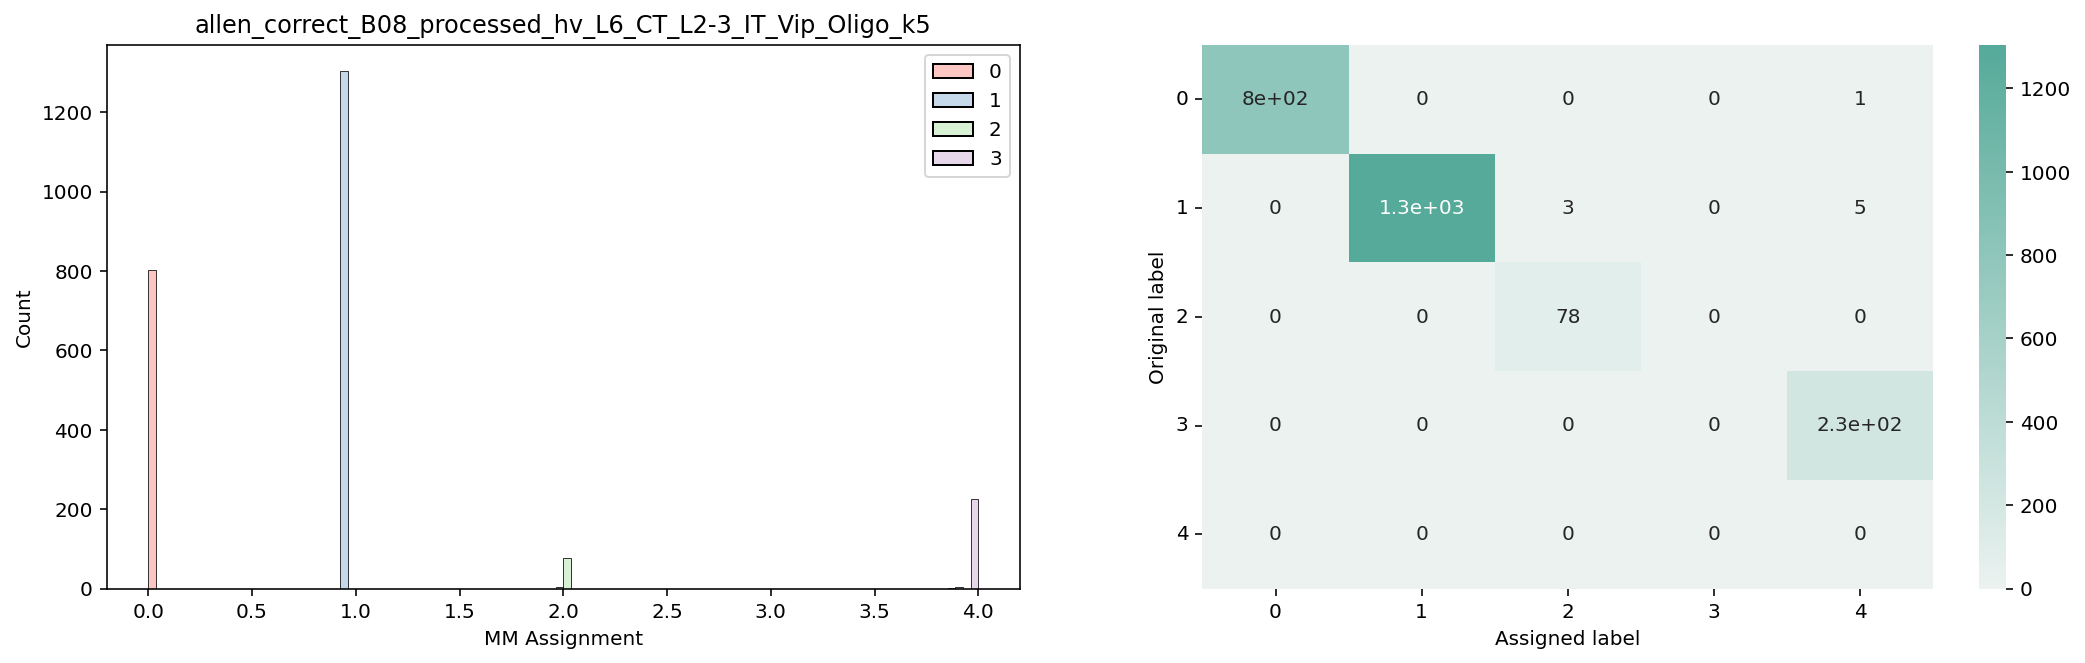

/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


(8, 8)
(8, 8)
(8, 8)
(8, 8)


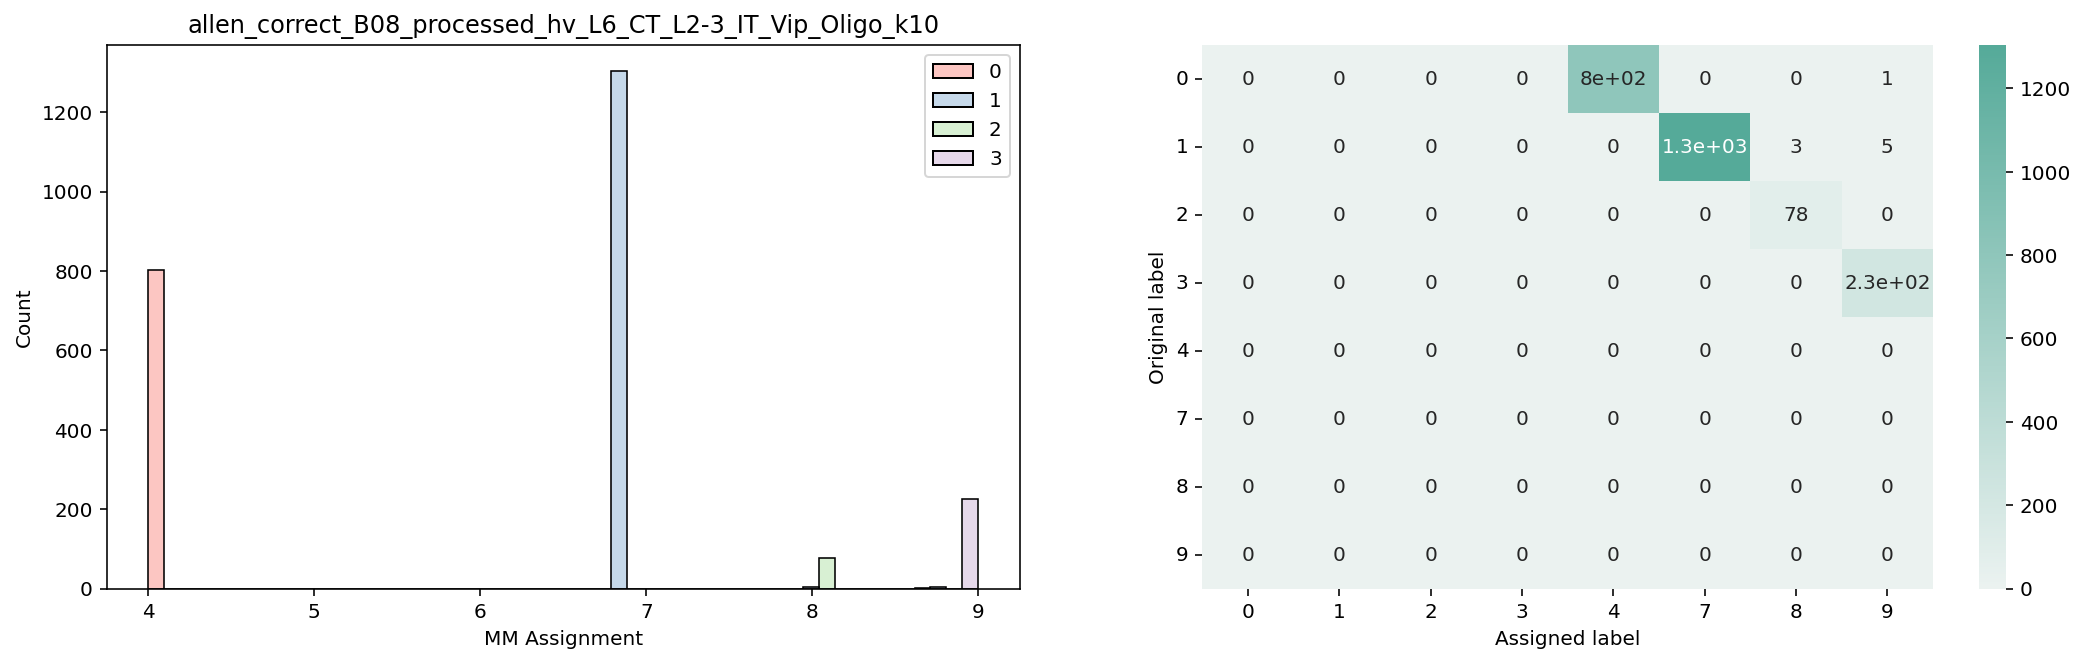

In [156]:
for i in range(len(grid_point_results)):
    r = grid_point_results[i]
    title = r.inference_string.replace('./fits/gg_230503_025_allen_B08_sizes_MM_1/','') #./fits/gg_230413_025_allen_B08_MM_1
    title = title.replace('/Bursty_Poisson_1x1','')
    vis_assign(np.array(all_new_assigns[i]),r.assigns,title)


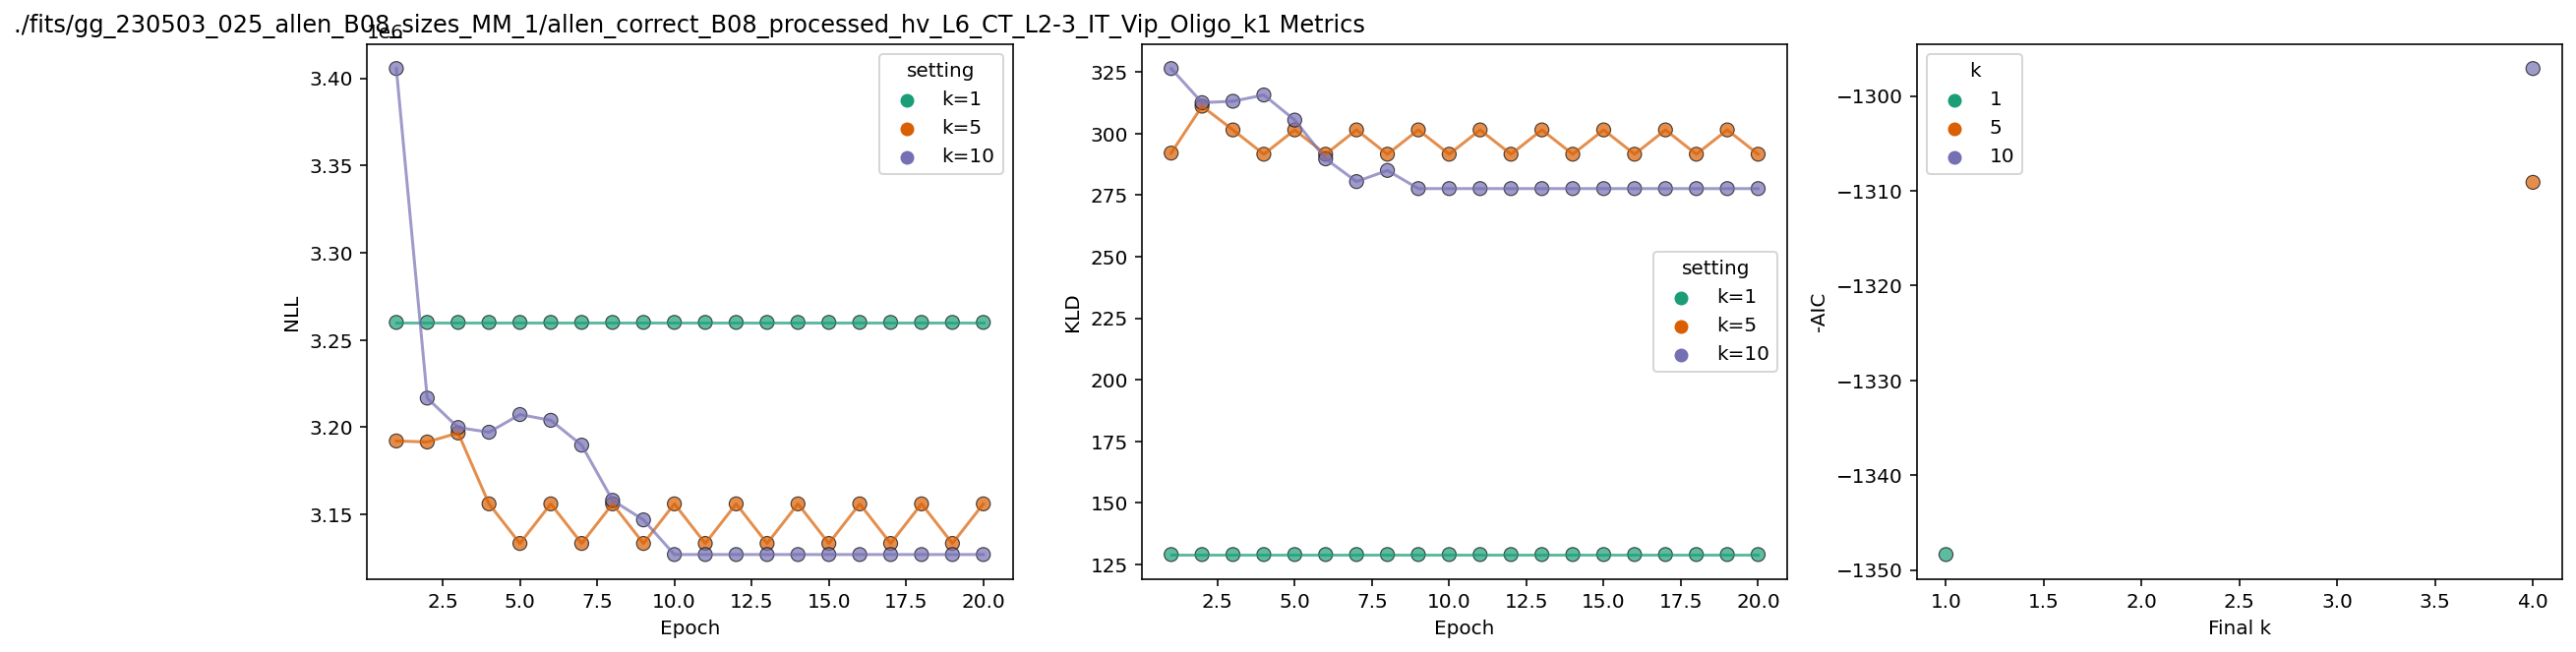

In [157]:
for i in range(0, len(grid_point_results), num_ks):
    r = grid_point_results[i:i+num_ks]
    title = dataset_strings[i]+' Metrics'
    vis_metrics(r,title,ks,figsize=(20,5))